# Training ResNet-Encoder–LSTM-Decoder model



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision.transforms import Resize

from tqdm import tqdm
import imageio
import gc

from sklearn.model_selection import train_test_split

from ResNet import ResNetEncoderPretrained

In [2]:
import Levenshtein

## Auxiliary 

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
cfg = dict()
# some parameters
cfg['n_channels'] = 50
cfg['input_channels'] = 1
cfg['output_channels'] = 6
cfg['dropout'] = 0.2
#cfg['fc_intermediate_len'] = 100 # ? 128

# resizing images
cfg['x_size'] = 150 
cfg['y_size'] = 300 

# for decoder
cfg['attention_dim'] = 256
cfg['embedding_dim'] = 256
cfg['decoder_dim'] = 512
cfg['max_len'] = 275

# for training
cfg['train_dataset_file'] = 'data/decoder/train.csv'
cfg['valid_dataset_file'] = 'data/decoder/valid.csv'

## Preprocessing data

Getting tokenized InChI strings from https://www.kaggle.com/yasufuminakama/inchi-preprocess-2/.

In [99]:
train = pd.read_pickle('preprocessing_output/train2.pkl')
train

,image_id,InChI,InChI_1,InChI_text,InChI_length
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,C13H20OS,C 13 H 20 O S /c 1 - 9 ( 2 ) 8 - 15 - 13 - 6 -...,59
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,C21H30O4,C 21 H 30 O 4 /c 1 - 12 ( 22 ) 25 - 14 - 6 - 8...,108
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,C24H23N5O4,C 24 H 23 N 5 O 4 /c 1 - 14 - 13 - 15 ( 7 - 8 ...,112
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...,C17H24N2O4S,C 17 H 24 N 2 O 4 S /c 1 - 12 ( 20 ) 18 - 13 (...,108
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...,C10H19N3O2S,C 10 H 19 N 3 O 2 S /c 1 - 15 - 10 ( 14 ) 12 -...,72
...,...,...,...,...,...
2424181,ffffe824f539,InChI=1S/C10H12F2N2O3/c1-17-7-2-5(3-8(15)16)9(...,C10H12F2N2O3,C 10 H 12 F 2 N 2 O 3 /c 1 - 17 - 7 - 2 - 5 ( ...,71
2424182,ffffea1ebdfa,InChI=1S/C19H20F2N4O3S/c1-10(8-20)28-14-7-12(2...,C19H20F2N4O3S,C 19 H 20 F 2 N 4 O 3 S /c 1 - 10 ( 8 - 20 ) 2...,119
2424183,ffffee2b4534,InChI=1S/C22H26Cl2N2O4S/c1-16-6-2-3-10-21(16)3...,C22H26Cl2N2O4S,C 22 H 26 Cl 2 N 2 O 4 S /c 1 - 16 - 6 - 2 - 3...,114
2424184,fffff0b6eea6,InChI=1S/C17H26N2O6S/c1-23-16-12-14(4-5-15(16)...,C17H26N2O6S,C 17 H 26 N 2 O 6 S /c 1 - 23 - 16 - 12 - 14 (...,90


In [5]:
class Tokenizer(object):
    
    def __init__(self):
        self.stoi = {}
        self.itos = {}

    def __len__(self):
        return len(self.stoi)
    
    def fit_on_texts(self, texts):
        vocab = set()
        for text in texts:
            vocab.update(text.split(' '))
        vocab = sorted(vocab)
        vocab.append('<sos>')
        vocab.append('<eos>')
        vocab.append('<pad>')
        for i, s in enumerate(vocab):
            self.stoi[s] = i
        self.itos = {item[1]: item[0] for item in self.stoi.items()}
        
    def text_to_sequence(self, text):
        sequence = []
        sequence.append(self.stoi['<sos>'])
        for s in text.split(' '):
            sequence.append(self.stoi[s])
        sequence.append(self.stoi['<eos>'])
        return sequence
    
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequence = self.text_to_sequence(text)
            sequences.append(sequence)
        return sequences

    def sequence_to_text(self, sequence):
        return ''.join(list(map(lambda i: self.itos[i], sequence)))
    
    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = self.sequence_to_text(sequence)
            texts.append(text)
        return texts
    
    def predict_caption(self, sequence):
        caption = ''
        for i in sequence:
            if i == self.stoi['<eos>'] or i == self.stoi['<pad>']:
                break
            caption += self.itos[i]
        return caption
    
    def predict_captions(self, sequences):
        captions = []
        for sequence in sequences:
            caption = self.predict_caption(sequence)
            captions.append(caption)
        return captions

tokenizer = torch.load('preprocessing_output/tokenizer2.pth')
print(f"tokenizer.stoi: {tokenizer.stoi}")

tokenizer.stoi: {'(': 0, ')': 1, '+': 2, ',': 3, '-': 4, '/b': 5, '/c': 6, '/h': 7, '/i': 8, '/m': 9, '/s': 10, '/t': 11, '0': 12, '1': 13, '10': 14, '100': 15, '101': 16, '102': 17, '103': 18, '104': 19, '105': 20, '106': 21, '107': 22, '108': 23, '109': 24, '11': 25, '110': 26, '111': 27, '112': 28, '113': 29, '114': 30, '115': 31, '116': 32, '117': 33, '118': 34, '119': 35, '12': 36, '120': 37, '121': 38, '122': 39, '123': 40, '124': 41, '125': 42, '126': 43, '127': 44, '128': 45, '129': 46, '13': 47, '130': 48, '131': 49, '132': 50, '133': 51, '134': 52, '135': 53, '136': 54, '137': 55, '138': 56, '139': 57, '14': 58, '140': 59, '141': 60, '142': 61, '143': 62, '144': 63, '145': 64, '146': 65, '147': 66, '148': 67, '149': 68, '15': 69, '150': 70, '151': 71, '152': 72, '153': 73, '154': 74, '155': 75, '156': 76, '157': 77, '158': 78, '159': 79, '16': 80, '161': 81, '163': 82, '165': 83, '167': 84, '17': 85, '18': 86, '19': 87, '2': 88, '20': 89, '21': 90, '22': 91, '23': 92, '24': 9

Splitting train and validation

In [101]:
train_dataset, valid_dataset = train_test_split(train, test_size=0.2, random_state=33)
train_dataset.to_csv('data/decoder/train.csv',index=False)
valid_dataset.to_csv('data/decoder/valid.csv',index=False)

del train_dataset
del valid_dataset
del train

train_dataset = pd.read_csv('data/decoder/train.csv')
train_dataset

## Define datasets

In [6]:
def load_pic(image_id, is_train=True):
    _ = 'train' if is_train else 'test'
    directory = 'original_data/{}/{}/{}/{}/'.format(_, image_id[0], image_id[1], image_id[2])
    return torch.Tensor(imageio.imread(directory + image_id + '.png') )

In [7]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, file, x_size=256, y_size=256, n_of_samples=None):
        data = pd.read_csv(file)
        self.n_of_samples = n_of_samples if n_of_samples else data.shape[0]
        self.data = data[:self.n_of_samples].drop(columns=['InChI_1', 'InChI_length'])
        
        self.x_size = x_size
        self.y_size = y_size
        self.resize = Resize(size=(x_size,y_size))
    
    def __len__(self):
        return self.n_of_samples
    
    def __getitem__(self, index):
        pic = load_pic(self.data['image_id'][index]).unsqueeze(0) # C=1 channel
        pic = self.resize(pic) / 255.
        label = self.data['InChI_text'][index]
        encoded_label = torch.LongTensor(tokenizer.text_to_sequence(label))
        return pic, encoded_label, encoded_label.shape[0]

In [8]:
# Is used to form batches in DataLoader of Dataset __getitem__
# Needed to create uniformly padded sequences for decoder
def CollateFunction(batch):
    images = []
    encoded_labels = []
    label_lengths = []
    for (image, encoded_label, label_length) in batch:
        images.append(image)
        encoded_labels.append(encoded_label)
        label_lengths.append(label_length)
    images = torch.stack(images)
    encoded_labels = nn.utils.rnn.pad_sequence(encoded_labels, batch_first=True,
                                               padding_value=tokenizer.stoi["<pad>"])
    #label_lengths = torch.stack(label_lengths).reshape(-1, 1)
    label_lengths = torch.LongTensor(label_lengths).reshape(-1, 1)
    return images, encoded_labels, label_lengths

In [9]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, file, x_size=256, y_size=256):
        self.data = pd.read_csv(file)
        self.x_size = x_size
        self.y_size = y_size
        self.resize = Resize(size=(x_size,y_size))
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        pic = load_pic(self.data['image_id'][index]).unsqueeze(0) # C=1 channel
        pic = self.resize(pic) / 255.
        return pic

## Define model

Taken from the same link.

In [20]:
class Attention(nn.Module):
    """
    Attention network for calculate attention value
    """
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: input size of encoder network
        :param decoder_dim: input size of decoder network
        :param attention_dim: input size of attention network
        """
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)
        return attention_weighted_encoding, alpha


class DecoderWithAttention(nn.Module):
    """
    Decoder network with attention network used for training
    """

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=512, dropout=0.2): # 0.5
        """
        :param attention_dim: input size of attention network
        :param embed_dim: input size of embedding network
        :param decoder_dim: input size of decoder network
        :param vocab_size: total number of characters used in training
        :param encoder_dim: input size of encoder network
        :param dropout: dropout rate
        """
        super(DecoderWithAttention, self).__init__()
        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout
        self.device = device
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network
        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.squeeze(-1)
        #mean_encoder_out = encoder_out.mean(dim=0)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        :param encoder_out: output of encoder network
        :param encoded_captions: transformed sequence from character to integer
        :param caption_lengths: length of transformed sequence
        """
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size
        
        encoder_out = encoder_out.squeeze() # FIXME ? 
        #encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]
        # embedding transformed sequence for vector
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)
        # initialize hidden state and cell state of LSTM cell
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        # set decode length by caption length - 1 because of omitting start token
        decode_lengths = (caption_lengths - 1).tolist()
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(self.device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(self.device)
        # predict sequence
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])            
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t], h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            #alphas[:batch_size_t, t, :] = alpha
        return predictions, encoded_captions, decode_lengths, alphas, sort_ind
    
    def predict(self, encoder_out, decode_lengths, tokenizer):
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size
        encoder_out = encoder_out.squeeze() # ? fixme
        #encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)
        # embed start tocken for LSTM input
        start_tockens = torch.ones(batch_size, dtype=torch.long).to(self.device) * tokenizer.stoi["<sos>"]
        embeddings = self.embedding(start_tockens)
        # initialize hidden state and cell state of LSTM cell
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        predictions = torch.zeros(batch_size, decode_lengths, vocab_size).to(self.device)
        # predict sequence
        for t in range(decode_lengths):
            attention_weighted_encoding, alpha = self.attention(encoder_out, h)
            gate = self.sigmoid(self.f_beta(h))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings, attention_weighted_encoding], dim=1),
                (h, c))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:, t, :] = preds
            if np.argmax(preds.detach().cpu().numpy()) == tokenizer.stoi["<eos>"]:
                break
            embeddings = self.embedding(torch.argmax(preds, -1))
        return predictions

## Training functions

In [10]:
def train_epoch(data_loader, encoder, decoder, optimizer, criterion):
    encoder.train()
    decoder.train()
    for (images, labels, label_lengths) in tqdm(data_loader): # labels already encoded
        
        # 1. Move batch to GPU (if available)
        images = images.to(device)
        labels = labels.to(device)
        label_lengths = label_lengths.to(device)
        
        # 2. Zeroing gradients.
        optimizer.zero_grad()
        
        # 3. Forward pass
        features = encoder(images)
        #predictions = decoder(features, labels, label_lengths)
        predictions, caps_sorted, decode_lengths, alphas, sort_ind = decoder(features, labels, label_lengths)
        targets = caps_sorted[:, 1:]
        predictions = nn.utils.rnn.pack_padded_sequence(predictions, decode_lengths, batch_first=True).data
        targets = nn.utils.rnn.pack_padded_sequence(targets, decode_lengths, batch_first=True).data
        
        # 4. Calculate loss.
        loss = criterion(predictions, targets)
        print('batch_loss', loss.item()) # debug
        
        # 5. Calculate gradients and perform optimization step.
        loss.backward() # clip_grad_norm may be used after this
        optimizer.step()

In [18]:
def eval_performance(encoder, decoder, data_loader, batch_size, max_count=float('+inf')):
    
    encoder.eval()
    decoder.eval()
    count = 0
    loss  = 0.
    edit_dist = 0
    
    for (images, labels, label_lengths) in data_loader:
        batch_size = images.shape[0]
        
        # make predictions (run forward)
        images = images.to(device)
        with torch.no_grad():
            features = encoder(images)
            # FIXME FOR STANDARD KAGGLE MODEL
            features = features.reshape(images.shape[0], 2, 2, 128)
            predictions = decoder.predict(features, cfg['max_len'], tokenizer)
        
        # transform predictions to text
        predicted_sequences = torch.argmax(predictions.detach().cpu(), -1).numpy()
        #     predictions: batch_size x cfg['max_len'] x len(tokenizer)
        #     predicted_sequences = batch_size x cfg['max_len']
        text_predictions = tokenizer.predict_captions(predicted_sequences)
        #print('Text predictions:')
        #print(text_predictions)
        text_targets = tokenizer.predict_captions(labels.detach().cpu().numpy())
        if count == 0:
            print(text_predictions[0])
        # calc metrics
        for i in range(batch_size):
            edit_dist += Levenshtein.distance(text_predictions[i], text_targets[i])
        #loss += loss_function(predictions, labels)

        count += batch_size
        if count > max_count:
            break
    loss = loss / count
    edit_dist = edit_dist / count
    return loss, edit_dist

In [72]:
def train_model(encoder, decoder, n_epochs, batch_size, history, finetune_encoder=False):
    
    # 1. Initialize and prepare data
    dataset_train = TrainDataset(file=cfg['train_dataset_file'], 
                                 x_size=cfg['x_size'], y_size=cfg['y_size'], n_of_samples=1000)
    dataset_valid = TrainDataset(file=cfg['valid_dataset_file'],
                                 x_size=cfg['x_size'], y_size=cfg['y_size'], n_of_samples=1000)
    
    data_train_loader = torch.utils.data.DataLoader(dataset_train, batch_size,
                                                   num_workers=6, persistent_workers=True, pin_memory=True,
                                                   collate_fn=CollateFunction)
    data_valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size,
                                                    num_workers=2, persistent_workers=False, pin_memory=False,
                                                   collate_fn=CollateFunction)
    # 2. Initialize loss and optimizer parameters
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.stoi["<pad>"]) # like in the link
    
    params_to_optimize = list(decoder.parameters())
    if finetune_encoder:
        params_to_optimize.extend(encoder.parameters())
    
    optimizer = torch.optim.Adam(params_to_optimize, lr=0.00001)
    
    # 3. Move model to GPU (if available)
    encoder.to(device)
    decoder.to(device)
    
    # 4. Train for n_epochs, calculating loss/metrics and saving model parameters
    for i in range(n_epochs):
        print('Starting epoch {}'.format(i))
        
        train_epoch(data_train_loader, encoder, decoder, optimizer, criterion)
        
        # save model
        torch.save(decoder.state_dict(), 'data/decoder/decoder_v1_epoch_{}.model'.format(i))
        if finetune_encoder:
            torch.save(encoder.state_dict(), 'data/decoder/encoder_v1_epoch_{}.model'.format(i))
        
        # print and save metrics
        train_loss, train_metric = eval_performance(encoder, decoder, data_train_loader,
                                                    batch_size, max_count=15)
        valid_loss, valid_metric = 0.1, 0.1 #eval_performance(encoder, decoder, data_valid_loader, batch_size)
        print('Train loss:\t{:f}, \t test loss:\t{:f}'.format(train_loss, valid_loss))
        print('Levenshtein distance: on train:\t{},\t on test:\t{}'.format(train_metric, valid_metric))
        history[i,0] = train_loss
        history[i,1] = valid_loss
        history[i,2] = train_metric
        history[i,3] = valid_metric

## Initializing and training

In [73]:
gc.collect()
torch.cuda.empty_cache()

In [74]:
encoder = ResNetEncoderPretrained('data/resnet_multiple_epoch_4_finetune.model').to(device)

In [75]:
decoder = DecoderWithAttention(cfg['attention_dim'], cfg['embedding_dim'], cfg['decoder_dim'], 
                               vocab_size=len(tokenizer), dropout=cfg['dropout']).to(device)

In [76]:
N_EPOCHS = 4
history = np.zeros((N_EPOCHS, 4))

In [77]:
%%time
train_model(encoder, decoder, N_EPOCHS, batch_size=10, history=history, finetune_encoder=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Starting epoch 0
batch_loss 5.295003890991211


  1%|          | 1/100 [00:00<00:53,  1.85it/s]

batch_loss 5.275502681732178


  2%|▏         | 2/100 [00:00<00:47,  2.07it/s]

batch_loss 5.260140419006348


  3%|▎         | 3/100 [00:01<00:42,  2.26it/s]

batch_loss 5.241138935089111


  4%|▍         | 4/100 [00:01<00:39,  2.40it/s]

batch_loss 5.2173004150390625


  5%|▌         | 5/100 [00:02<00:40,  2.37it/s]

batch_loss 5.2146124839782715


  6%|▌         | 6/100 [00:02<00:37,  2.52it/s]

batch_loss 5.1931915283203125


  7%|▋         | 7/100 [00:02<00:35,  2.62it/s]

batch_loss 5.173024654388428


  8%|▊         | 8/100 [00:03<00:36,  2.56it/s]

batch_loss 5.1620588302612305


  9%|▉         | 9/100 [00:03<00:36,  2.50it/s]

batch_loss 5.142887592315674


 10%|█         | 10/100 [00:03<00:34,  2.61it/s]

batch_loss 5.120909214019775


 11%|█         | 11/100 [00:04<00:33,  2.68it/s]

batch_loss 5.086022853851318


 12%|█▏        | 12/100 [00:04<00:33,  2.61it/s]

batch_loss 5.105474948883057


 13%|█▎        | 13/100 [00:04<00:32,  2.72it/s]

batch_loss 5.093523979187012


 14%|█▍        | 14/100 [00:05<00:30,  2.81it/s]

batch_loss 5.084072113037109


 15%|█▌        | 15/100 [00:05<00:29,  2.83it/s]

batch_loss 5.0252556800842285


 16%|█▌        | 16/100 [00:06<00:31,  2.69it/s]

batch_loss 5.032132625579834


 17%|█▋        | 17/100 [00:06<00:30,  2.74it/s]

batch_loss 5.032677173614502


 18%|█▊        | 18/100 [00:06<00:29,  2.76it/s]

batch_loss 5.00205135345459


 19%|█▉        | 19/100 [00:07<00:28,  2.80it/s]

batch_loss 4.986095905303955


 20%|██        | 20/100 [00:07<00:27,  2.87it/s]

batch_loss 4.981171131134033


 21%|██        | 21/100 [00:07<00:27,  2.87it/s]

batch_loss 4.937386512756348


 22%|██▏       | 22/100 [00:08<00:28,  2.72it/s]

batch_loss 4.929110527038574


 23%|██▎       | 23/100 [00:08<00:27,  2.80it/s]

batch_loss 4.924543380737305


 24%|██▍       | 24/100 [00:08<00:27,  2.75it/s]

batch_loss 4.902798652648926


 25%|██▌       | 25/100 [00:09<00:26,  2.78it/s]

batch_loss 4.85968017578125


 26%|██▌       | 26/100 [00:09<00:26,  2.83it/s]

batch_loss 4.8674445152282715


 27%|██▋       | 27/100 [00:09<00:25,  2.89it/s]

batch_loss 4.832211017608643


 28%|██▊       | 28/100 [00:10<00:24,  2.88it/s]

batch_loss 4.833569049835205


 29%|██▉       | 29/100 [00:10<00:25,  2.80it/s]

batch_loss 4.765077114105225


 30%|███       | 30/100 [00:11<00:25,  2.72it/s]

batch_loss 4.800626754760742


 31%|███       | 31/100 [00:11<00:24,  2.83it/s]

batch_loss 4.7995147705078125


 32%|███▏      | 32/100 [00:11<00:23,  2.86it/s]

batch_loss 4.722526550292969


 33%|███▎      | 33/100 [00:12<00:24,  2.69it/s]

batch_loss 4.749760627746582


 34%|███▍      | 34/100 [00:12<00:24,  2.69it/s]

batch_loss 4.723870754241943


 35%|███▌      | 35/100 [00:12<00:24,  2.69it/s]

batch_loss 4.712981700897217


 36%|███▌      | 36/100 [00:13<00:24,  2.64it/s]

batch_loss 4.667555332183838


 37%|███▋      | 37/100 [00:13<00:23,  2.68it/s]

batch_loss 4.69164514541626


 38%|███▊      | 38/100 [00:13<00:22,  2.72it/s]

batch_loss 4.594959259033203


 39%|███▉      | 39/100 [00:14<00:24,  2.53it/s]

batch_loss 4.580879211425781


 40%|████      | 40/100 [00:14<00:22,  2.64it/s]

batch_loss 4.565512657165527


 41%|████      | 41/100 [00:15<00:21,  2.77it/s]

batch_loss 4.6185808181762695


 42%|████▏     | 42/100 [00:15<00:21,  2.74it/s]

batch_loss 4.508068561553955


 43%|████▎     | 43/100 [00:15<00:21,  2.70it/s]

batch_loss 4.5682830810546875


 44%|████▍     | 44/100 [00:16<00:19,  2.81it/s]

batch_loss 4.4179582595825195


 45%|████▌     | 45/100 [00:16<00:20,  2.63it/s]

batch_loss 4.345760822296143


 46%|████▌     | 46/100 [00:17<00:20,  2.60it/s]

batch_loss 4.456296920776367


 48%|████▊     | 48/100 [00:17<00:18,  2.82it/s]

batch_loss 4.53425931930542
batch_loss 4.400796413421631


 49%|████▉     | 49/100 [00:18<00:17,  2.91it/s]

batch_loss 4.293593883514404


 50%|█████     | 50/100 [00:18<00:17,  2.83it/s]

batch_loss 4.248909950256348


 51%|█████     | 51/100 [00:18<00:17,  2.79it/s]

batch_loss 4.334366798400879


 52%|█████▏    | 52/100 [00:19<00:17,  2.81it/s]

batch_loss 4.336876392364502


 53%|█████▎    | 53/100 [00:19<00:16,  2.83it/s]

batch_loss 4.35268497467041


 54%|█████▍    | 54/100 [00:19<00:16,  2.87it/s]

batch_loss 4.3185834884643555


 55%|█████▌    | 55/100 [00:20<00:15,  2.83it/s]

batch_loss 4.30940055847168


 56%|█████▌    | 56/100 [00:20<00:15,  2.77it/s]

batch_loss 4.12845516204834


 57%|█████▋    | 57/100 [00:20<00:15,  2.70it/s]

batch_loss 4.19834566116333


 58%|█████▊    | 58/100 [00:21<00:16,  2.62it/s]

batch_loss 4.1375298500061035


 59%|█████▉    | 59/100 [00:21<00:15,  2.70it/s]

batch_loss 4.243359088897705


 60%|██████    | 60/100 [00:22<00:14,  2.76it/s]

batch_loss 4.178056716918945


 61%|██████    | 61/100 [00:22<00:14,  2.77it/s]

batch_loss 4.357820987701416


 62%|██████▏   | 62/100 [00:22<00:13,  2.81it/s]

batch_loss 4.1024169921875


 63%|██████▎   | 63/100 [00:23<00:13,  2.77it/s]

batch_loss 4.134792804718018


 64%|██████▍   | 64/100 [00:23<00:12,  2.85it/s]

batch_loss 4.0743255615234375


 65%|██████▌   | 65/100 [00:23<00:12,  2.77it/s]

batch_loss 4.082837104797363


 66%|██████▌   | 66/100 [00:24<00:12,  2.83it/s]

batch_loss 4.131782054901123


 67%|██████▋   | 67/100 [00:24<00:11,  2.85it/s]

batch_loss 4.182507514953613


 68%|██████▊   | 68/100 [00:24<00:11,  2.87it/s]

batch_loss 4.034366130828857


 69%|██████▉   | 69/100 [00:25<00:11,  2.76it/s]

batch_loss 4.117635726928711


 70%|███████   | 70/100 [00:25<00:10,  2.83it/s]

batch_loss 4.0438408851623535


 71%|███████   | 71/100 [00:25<00:10,  2.85it/s]

batch_loss 4.024463176727295


 72%|███████▏  | 72/100 [00:26<00:09,  2.87it/s]

batch_loss 4.076912879943848


 73%|███████▎  | 73/100 [00:26<00:09,  2.89it/s]

batch_loss 4.001161098480225


 74%|███████▍  | 74/100 [00:26<00:08,  2.96it/s]

batch_loss 4.004453182220459


 75%|███████▌  | 75/100 [00:27<00:08,  2.92it/s]

batch_loss 4.089517116546631


 76%|███████▌  | 76/100 [00:27<00:08,  2.92it/s]

batch_loss 4.008954048156738


 77%|███████▋  | 77/100 [00:27<00:07,  2.95it/s]

batch_loss 3.941967010498047


 78%|███████▊  | 78/100 [00:28<00:07,  2.94it/s]

batch_loss 3.8912553787231445


 79%|███████▉  | 79/100 [00:28<00:07,  2.97it/s]

batch_loss 3.9571521282196045


 80%|████████  | 80/100 [00:29<00:07,  2.80it/s]

batch_loss 3.9912736415863037


 81%|████████  | 81/100 [00:29<00:06,  2.81it/s]

batch_loss 3.928435802459717


 82%|████████▏ | 82/100 [00:29<00:06,  2.80it/s]

batch_loss 3.829596996307373


 83%|████████▎ | 83/100 [00:30<00:05,  2.90it/s]

batch_loss 3.894676685333252


 84%|████████▍ | 84/100 [00:30<00:05,  2.85it/s]

batch_loss 3.93034291267395


 85%|████████▌ | 85/100 [00:30<00:05,  2.89it/s]

batch_loss 3.8841536045074463


 86%|████████▌ | 86/100 [00:31<00:04,  2.88it/s]

batch_loss 3.919631242752075


 87%|████████▋ | 87/100 [00:31<00:04,  2.88it/s]

batch_loss 3.864941358566284


 88%|████████▊ | 88/100 [00:31<00:04,  2.89it/s]

batch_loss 3.8713393211364746


 89%|████████▉ | 89/100 [00:32<00:04,  2.71it/s]

batch_loss 3.8627188205718994


 90%|█████████ | 90/100 [00:32<00:03,  2.69it/s]

batch_loss 3.9041810035705566


 91%|█████████ | 91/100 [00:32<00:03,  2.73it/s]

batch_loss 3.8296499252319336


 92%|█████████▏| 92/100 [00:33<00:02,  2.78it/s]

batch_loss 3.797076940536499


 93%|█████████▎| 93/100 [00:33<00:02,  2.74it/s]

batch_loss 3.8287594318389893


 94%|█████████▍| 94/100 [00:33<00:02,  2.82it/s]

batch_loss 3.836479425430298


 95%|█████████▌| 95/100 [00:34<00:01,  2.82it/s]

batch_loss 3.792120933532715


 96%|█████████▌| 96/100 [00:34<00:01,  2.80it/s]

batch_loss 3.850050687789917


 97%|█████████▋| 97/100 [00:35<00:01,  2.83it/s]

batch_loss 3.872439384460449


 98%|█████████▊| 98/100 [00:35<00:00,  2.91it/s]

batch_loss 3.8946163654327393


 99%|█████████▉| 99/100 [00:35<00:00,  2.87it/s]

batch_loss 3.870708465576172


  0%|          | 0/100 [00:00<?, ?it/s]

CC---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Train loss:	0.000000, 	 test loss:	0.100000
Levenshtein distance: on train:	258.1,	 on test:	0.1
Starting epoch 1
batch_loss 3.846306085586548


  1%|          | 1/100 [00:00<00:37,  2.61it/s]

batch_loss 3.728055715560913


  2%|▏         | 2/100 [00:00<00:35,  2.73it/s]

batch_loss 3.8299026489257812


  3%|▎         | 3/100 [00:01<00:34,  2.77it/s]

batch_loss 3.8156304359436035


  4%|▍         | 4/100 [00:01<00:34,  2.80it/s]

batch_loss 3.7574479579925537


  5%|▌         | 5/100 [00:01<00:35,  2.70it/s]

batch_loss 3.7298007011413574


  6%|▌         | 6/100 [00:02<00:33,  2.83it/s]

batch_loss 3.7666170597076416


  7%|▋         | 7/100 [00:02<00:32,  2.88it/s]

batch_loss 3.799253225326538


  8%|▊         | 8/100 [00:02<00:32,  2.81it/s]

batch_loss 3.786313056945801


  9%|▉         | 9/100 [00:03<00:33,  2.72it/s]

batch_loss 3.7637579441070557


 10%|█         | 10/100 [00:03<00:32,  2.77it/s]

batch_loss 3.6920032501220703


 11%|█         | 11/100 [00:03<00:31,  2.80it/s]

batch_loss 3.6520657539367676


 12%|█▏        | 12/100 [00:04<00:32,  2.70it/s]

batch_loss 3.6682803630828857


 13%|█▎        | 13/100 [00:04<00:31,  2.80it/s]

batch_loss 3.7049498558044434


 14%|█▍        | 14/100 [00:05<00:30,  2.81it/s]

batch_loss 3.661471128463745


 15%|█▌        | 15/100 [00:05<00:30,  2.83it/s]

batch_loss 3.695964813232422


 16%|█▌        | 16/100 [00:05<00:31,  2.70it/s]

batch_loss 3.6857471466064453


 17%|█▋        | 17/100 [00:06<00:30,  2.69it/s]

batch_loss 3.7357120513916016


 18%|█▊        | 18/100 [00:06<00:30,  2.70it/s]

batch_loss 3.6492908000946045


 19%|█▉        | 19/100 [00:06<00:29,  2.75it/s]

batch_loss 3.66426157951355


 20%|██        | 20/100 [00:07<00:28,  2.80it/s]

batch_loss 3.7035067081451416


 21%|██        | 21/100 [00:07<00:27,  2.83it/s]

batch_loss 3.6543548107147217


 22%|██▏       | 22/100 [00:07<00:28,  2.71it/s]

batch_loss 3.698148012161255


 23%|██▎       | 23/100 [00:08<00:27,  2.78it/s]

batch_loss 3.624061346054077


 24%|██▍       | 24/100 [00:08<00:27,  2.76it/s]

batch_loss 3.671020984649658


 25%|██▌       | 25/100 [00:08<00:26,  2.80it/s]

batch_loss 3.569774866104126


 26%|██▌       | 26/100 [00:09<00:25,  2.86it/s]

batch_loss 3.6669394969940186


 27%|██▋       | 27/100 [00:09<00:25,  2.91it/s]

batch_loss 3.5935964584350586


 28%|██▊       | 28/100 [00:09<00:24,  2.93it/s]

batch_loss 3.664616346359253


 29%|██▉       | 29/100 [00:10<00:24,  2.85it/s]

batch_loss 3.5633082389831543


 31%|███       | 31/100 [00:11<00:23,  2.93it/s]

batch_loss 3.5502779483795166
batch_loss 3.5496809482574463


 32%|███▏      | 32/100 [00:11<00:22,  3.03it/s]

batch_loss 3.6907107830047607


 33%|███▎      | 33/100 [00:11<00:23,  2.83it/s]

batch_loss 3.5856173038482666


 34%|███▍      | 34/100 [00:12<00:23,  2.82it/s]

batch_loss 3.6194722652435303


 35%|███▌      | 35/100 [00:12<00:22,  2.83it/s]

batch_loss 3.673778533935547


 36%|███▌      | 36/100 [00:12<00:23,  2.76it/s]

batch_loss 3.6161177158355713


 37%|███▋      | 37/100 [00:13<00:22,  2.80it/s]

batch_loss 3.5594544410705566


 38%|███▊      | 38/100 [00:13<00:21,  2.87it/s]

batch_loss 3.6528525352478027


 39%|███▉      | 39/100 [00:13<00:22,  2.73it/s]

batch_loss 3.5586750507354736


 40%|████      | 40/100 [00:14<00:21,  2.84it/s]

batch_loss 3.541506052017212


 41%|████      | 41/100 [00:14<00:20,  2.91it/s]

batch_loss 3.6162595748901367


 42%|████▏     | 42/100 [00:14<00:20,  2.84it/s]

batch_loss 3.5951337814331055


 43%|████▎     | 43/100 [00:15<00:20,  2.77it/s]

batch_loss 3.5427374839782715


 44%|████▍     | 44/100 [00:15<00:19,  2.86it/s]

batch_loss 3.628249406814575


 45%|████▌     | 45/100 [00:16<00:20,  2.67it/s]

batch_loss 3.5584423542022705


 46%|████▌     | 46/100 [00:16<00:20,  2.65it/s]

batch_loss 3.6484787464141846


 48%|████▊     | 48/100 [00:17<00:18,  2.83it/s]

batch_loss 3.5702831745147705
batch_loss 3.515913248062134


 49%|████▉     | 49/100 [00:17<00:17,  2.93it/s]

batch_loss 3.5471229553222656


 50%|█████     | 50/100 [00:17<00:17,  2.85it/s]

batch_loss 3.480043411254883


 51%|█████     | 51/100 [00:18<00:17,  2.84it/s]

batch_loss 3.5351028442382812


 52%|█████▏    | 52/100 [00:18<00:16,  2.85it/s]

batch_loss 3.556389570236206


 53%|█████▎    | 53/100 [00:18<00:16,  2.91it/s]

batch_loss 3.5471935272216797


 54%|█████▍    | 54/100 [00:19<00:15,  2.97it/s]

batch_loss 3.549024820327759


 55%|█████▌    | 55/100 [00:19<00:15,  2.96it/s]

batch_loss 3.6148369312286377


 56%|█████▌    | 56/100 [00:19<00:14,  2.94it/s]

batch_loss 3.518937349319458


 57%|█████▋    | 57/100 [00:20<00:15,  2.86it/s]

batch_loss 3.5673017501831055


 58%|█████▊    | 58/100 [00:20<00:15,  2.74it/s]

batch_loss 3.4729175567626953


 59%|█████▉    | 59/100 [00:20<00:14,  2.78it/s]

batch_loss 3.517641544342041


 60%|██████    | 60/100 [00:21<00:14,  2.84it/s]

batch_loss 3.538012742996216


 61%|██████    | 61/100 [00:21<00:13,  2.83it/s]

batch_loss 3.633579730987549


 62%|██████▏   | 62/100 [00:22<00:13,  2.85it/s]

batch_loss 3.524285316467285


 63%|██████▎   | 63/100 [00:22<00:13,  2.80it/s]

batch_loss 3.4532063007354736


 64%|██████▍   | 64/100 [00:22<00:12,  2.87it/s]

batch_loss 3.5576891899108887


 65%|██████▌   | 65/100 [00:23<00:12,  2.78it/s]

batch_loss 3.458587408065796


 66%|██████▌   | 66/100 [00:23<00:11,  2.85it/s]

batch_loss 3.534832239151001


 67%|██████▋   | 67/100 [00:23<00:11,  2.87it/s]

batch_loss 3.528028726577759


 68%|██████▊   | 68/100 [00:24<00:11,  2.88it/s]

batch_loss 3.4905853271484375


 69%|██████▉   | 69/100 [00:24<00:11,  2.76it/s]

batch_loss 3.4368185997009277


 70%|███████   | 70/100 [00:24<00:10,  2.84it/s]

batch_loss 3.456761121749878


 71%|███████   | 71/100 [00:25<00:10,  2.86it/s]

batch_loss 3.4521968364715576


 72%|███████▏  | 72/100 [00:25<00:09,  2.87it/s]

batch_loss 3.4950952529907227


 73%|███████▎  | 73/100 [00:25<00:09,  2.90it/s]

batch_loss 3.4743247032165527


 74%|███████▍  | 74/100 [00:26<00:08,  2.96it/s]

batch_loss 3.477165699005127


 75%|███████▌  | 75/100 [00:26<00:08,  2.92it/s]

batch_loss 3.465796709060669


 76%|███████▌  | 76/100 [00:26<00:08,  2.93it/s]

batch_loss 3.4749178886413574


 77%|███████▋  | 77/100 [00:27<00:07,  2.94it/s]

batch_loss 3.473921775817871


 78%|███████▊  | 78/100 [00:27<00:07,  2.95it/s]

batch_loss 3.398974657058716


 79%|███████▉  | 79/100 [00:27<00:07,  2.97it/s]

batch_loss 3.513310432434082


 80%|████████  | 80/100 [00:28<00:07,  2.81it/s]

batch_loss 3.4712910652160645


 81%|████████  | 81/100 [00:28<00:06,  2.80it/s]

batch_loss 3.469543695449829


 82%|████████▏ | 82/100 [00:29<00:06,  2.79it/s]

batch_loss 3.381209373474121


 83%|████████▎ | 83/100 [00:29<00:05,  2.90it/s]

batch_loss 3.472569227218628


 84%|████████▍ | 84/100 [00:29<00:05,  2.86it/s]

batch_loss 3.4701459407806396


 85%|████████▌ | 85/100 [00:30<00:05,  2.89it/s]

batch_loss 3.4635236263275146


 86%|████████▌ | 86/100 [00:30<00:04,  2.87it/s]

batch_loss 3.5091233253479004


 87%|████████▋ | 87/100 [00:30<00:04,  2.87it/s]

batch_loss 3.445709466934204


 88%|████████▊ | 88/100 [00:31<00:04,  2.88it/s]

batch_loss 3.493173599243164


 89%|████████▉ | 89/100 [00:31<00:04,  2.71it/s]

batch_loss 3.507460832595825


 90%|█████████ | 90/100 [00:31<00:03,  2.68it/s]

batch_loss 3.5259034633636475


 91%|█████████ | 91/100 [00:32<00:03,  2.72it/s]

batch_loss 3.457836866378784


 92%|█████████▏| 92/100 [00:32<00:02,  2.76it/s]

batch_loss 3.4359054565429688


 93%|█████████▎| 93/100 [00:32<00:02,  2.73it/s]

batch_loss 3.4066693782806396


 94%|█████████▍| 94/100 [00:33<00:02,  2.80it/s]

batch_loss 3.488004684448242


 95%|█████████▌| 95/100 [00:33<00:01,  2.81it/s]

batch_loss 3.437589645385742


 96%|█████████▌| 96/100 [00:34<00:01,  2.79it/s]

batch_loss 3.5200488567352295


 97%|█████████▋| 97/100 [00:34<00:01,  2.81it/s]

batch_loss 3.3543856143951416


 98%|█████████▊| 98/100 [00:34<00:00,  2.90it/s]

batch_loss 3.499768018722534


 99%|█████████▉| 99/100 [00:35<00:00,  2.86it/s]

batch_loss 3.5502841472625732


  0%|          | 0/100 [00:00<?, ?it/s]

CCH--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Train loss:	0.000000, 	 test loss:	0.100000
Levenshtein distance: on train:	258.0,	 on test:	0.1
Starting epoch 2
batch_loss 3.4563536643981934


  1%|          | 1/100 [00:00<00:36,  2.72it/s]

batch_loss 3.386603593826294


  2%|▏         | 2/100 [00:00<00:34,  2.80it/s]

batch_loss 3.4723355770111084


  3%|▎         | 3/100 [00:01<00:34,  2.83it/s]

batch_loss 3.4893782138824463


  4%|▍         | 4/100 [00:01<00:33,  2.84it/s]

batch_loss 3.5053577423095703


  5%|▌         | 5/100 [00:01<00:34,  2.73it/s]

batch_loss 3.394343614578247


  6%|▌         | 6/100 [00:02<00:32,  2.86it/s]

batch_loss 3.4461019039154053


  7%|▋         | 7/100 [00:02<00:32,  2.90it/s]

batch_loss 3.4612550735473633


  8%|▊         | 8/100 [00:02<00:32,  2.82it/s]

batch_loss 3.5562243461608887


  9%|▉         | 9/100 [00:03<00:33,  2.73it/s]

batch_loss 3.442901134490967


 10%|█         | 10/100 [00:03<00:32,  2.78it/s]

batch_loss 3.42547345161438


 11%|█         | 11/100 [00:03<00:31,  2.81it/s]

batch_loss 3.4484002590179443


 12%|█▏        | 12/100 [00:04<00:32,  2.71it/s]

batch_loss 3.3874850273132324


 13%|█▎        | 13/100 [00:04<00:30,  2.81it/s]

batch_loss 3.435734748840332


 14%|█▍        | 14/100 [00:04<00:29,  2.89it/s]

batch_loss 3.390317440032959


 15%|█▌        | 15/100 [00:05<00:29,  2.90it/s]

batch_loss 3.4716765880584717


 16%|█▌        | 16/100 [00:05<00:30,  2.76it/s]

batch_loss 3.429013252258301


 17%|█▋        | 17/100 [00:06<00:29,  2.78it/s]

batch_loss 3.5084447860717773


 18%|█▊        | 18/100 [00:06<00:29,  2.82it/s]

batch_loss 3.3948686122894287


 19%|█▉        | 19/100 [00:06<00:28,  2.85it/s]

batch_loss 3.325868844985962


 20%|██        | 20/100 [00:07<00:27,  2.91it/s]

batch_loss 3.441922664642334


 21%|██        | 21/100 [00:07<00:27,  2.92it/s]

batch_loss 3.4192655086517334


 22%|██▏       | 22/100 [00:07<00:28,  2.77it/s]

batch_loss 3.4449713230133057


 23%|██▎       | 23/100 [00:08<00:27,  2.83it/s]

batch_loss 3.4114043712615967


 24%|██▍       | 24/100 [00:08<00:27,  2.80it/s]

batch_loss 3.43190598487854


 25%|██▌       | 25/100 [00:08<00:26,  2.83it/s]

batch_loss 3.3305835723876953


 26%|██▌       | 26/100 [00:09<00:25,  2.89it/s]

batch_loss 3.4316208362579346


 27%|██▋       | 27/100 [00:09<00:24,  2.94it/s]

batch_loss 3.3650705814361572


 28%|██▊       | 28/100 [00:09<00:24,  2.94it/s]

batch_loss 3.4411234855651855


 29%|██▉       | 29/100 [00:10<00:24,  2.85it/s]

batch_loss 3.387105941772461


 31%|███       | 31/100 [00:10<00:23,  2.93it/s]

batch_loss 3.2859067916870117
batch_loss 3.3019192218780518


 32%|███▏      | 32/100 [00:11<00:22,  3.02it/s]

batch_loss 3.502887725830078


 33%|███▎      | 33/100 [00:11<00:23,  2.83it/s]

batch_loss 3.3705830574035645


 34%|███▍      | 34/100 [00:11<00:23,  2.80it/s]

batch_loss 3.4119808673858643


 35%|███▌      | 35/100 [00:12<00:23,  2.81it/s]

batch_loss 3.5164389610290527


 36%|███▌      | 36/100 [00:12<00:23,  2.74it/s]

batch_loss 3.4008877277374268


 37%|███▋      | 37/100 [00:13<00:22,  2.78it/s]

batch_loss 3.336164951324463


 38%|███▊      | 38/100 [00:13<00:21,  2.85it/s]

batch_loss 3.4987435340881348


 39%|███▉      | 39/100 [00:13<00:22,  2.72it/s]

batch_loss 3.343097686767578


 40%|████      | 40/100 [00:14<00:21,  2.83it/s]

batch_loss 3.291703224182129


 41%|████      | 41/100 [00:14<00:20,  2.91it/s]

batch_loss 3.4363954067230225


 42%|████▏     | 42/100 [00:14<00:20,  2.84it/s]

batch_loss 3.4213626384735107


 43%|████▎     | 43/100 [00:15<00:20,  2.77it/s]

batch_loss 3.320385694503784


 44%|████▍     | 44/100 [00:15<00:19,  2.87it/s]

batch_loss 3.49550461769104


 45%|████▌     | 45/100 [00:15<00:20,  2.67it/s]

batch_loss 3.421109437942505


 46%|████▌     | 46/100 [00:16<00:20,  2.64it/s]

batch_loss 3.4973955154418945


 48%|████▊     | 48/100 [00:17<00:18,  2.83it/s]

batch_loss 3.3407068252563477
batch_loss 3.3652548789978027


 49%|████▉     | 49/100 [00:17<00:17,  2.92it/s]

batch_loss 3.386772632598877


 50%|█████     | 50/100 [00:17<00:17,  2.83it/s]

batch_loss 3.3076961040496826


 51%|█████     | 51/100 [00:18<00:17,  2.83it/s]

batch_loss 3.3741366863250732


 52%|█████▏    | 52/100 [00:18<00:16,  2.83it/s]

batch_loss 3.3803601264953613


 53%|█████▎    | 53/100 [00:18<00:16,  2.89it/s]

batch_loss 3.328378438949585


 54%|█████▍    | 54/100 [00:19<00:15,  2.96it/s]

batch_loss 3.3615939617156982


 55%|█████▌    | 55/100 [00:19<00:15,  2.94it/s]

batch_loss 3.4578280448913574


 56%|█████▌    | 56/100 [00:19<00:15,  2.92it/s]

batch_loss 3.3707683086395264


 57%|█████▋    | 57/100 [00:20<00:15,  2.84it/s]

batch_loss 3.4381964206695557


 58%|█████▊    | 58/100 [00:20<00:15,  2.73it/s]

batch_loss 3.351294994354248


 59%|█████▉    | 59/100 [00:20<00:14,  2.78it/s]

batch_loss 3.331477165222168


 60%|██████    | 60/100 [00:21<00:14,  2.83it/s]

batch_loss 3.3928380012512207


 61%|██████    | 61/100 [00:21<00:13,  2.82it/s]

batch_loss 3.4363532066345215


 62%|██████▏   | 62/100 [00:21<00:13,  2.84it/s]

batch_loss 3.373119592666626


 63%|██████▎   | 63/100 [00:22<00:13,  2.79it/s]

batch_loss 3.273608446121216


 64%|██████▍   | 64/100 [00:22<00:12,  2.86it/s]

batch_loss 3.446826219558716


 65%|██████▌   | 65/100 [00:23<00:12,  2.76it/s]

batch_loss 3.296626329421997


 66%|██████▌   | 66/100 [00:23<00:12,  2.82it/s]

batch_loss 3.4347035884857178


 67%|██████▋   | 67/100 [00:23<00:11,  2.84it/s]

batch_loss 3.394643783569336


 68%|██████▊   | 68/100 [00:24<00:11,  2.86it/s]

batch_loss 3.3399407863616943


 69%|██████▉   | 69/100 [00:24<00:11,  2.74it/s]

batch_loss 3.2643134593963623


 70%|███████   | 70/100 [00:24<00:10,  2.82it/s]

batch_loss 3.3357186317443848


 71%|███████   | 71/100 [00:25<00:10,  2.84it/s]

batch_loss 3.304466962814331


 72%|███████▏  | 72/100 [00:25<00:09,  2.85it/s]

batch_loss 3.3798515796661377


 73%|███████▎  | 73/100 [00:25<00:09,  2.88it/s]

batch_loss 3.2975082397460938


 74%|███████▍  | 74/100 [00:26<00:08,  2.94it/s]

batch_loss 3.3398075103759766


 75%|███████▌  | 75/100 [00:26<00:08,  2.90it/s]

batch_loss 3.3747143745422363


 76%|███████▌  | 76/100 [00:26<00:08,  2.92it/s]

batch_loss 3.332357883453369


 77%|███████▋  | 77/100 [00:27<00:07,  2.92it/s]

batch_loss 3.3351173400878906


 78%|███████▊  | 78/100 [00:27<00:07,  2.93it/s]

batch_loss 3.2312912940979004


 79%|███████▉  | 79/100 [00:27<00:07,  2.96it/s]

batch_loss 3.401423692703247


 80%|████████  | 80/100 [00:28<00:07,  2.80it/s]

batch_loss 3.3203420639038086


 81%|████████  | 81/100 [00:28<00:06,  2.79it/s]

batch_loss 3.3167319297790527


 82%|████████▏ | 82/100 [00:28<00:06,  2.79it/s]

batch_loss 3.205821990966797


 83%|████████▎ | 83/100 [00:29<00:05,  2.89it/s]

batch_loss 3.3608319759368896


 84%|████████▍ | 84/100 [00:29<00:05,  2.85it/s]

batch_loss 3.35176157951355


 85%|████████▌ | 85/100 [00:29<00:05,  2.88it/s]

batch_loss 3.37764310836792


 86%|████████▌ | 86/100 [00:30<00:04,  2.87it/s]

batch_loss 3.376373052597046


 87%|████████▋ | 87/100 [00:30<00:04,  2.87it/s]

batch_loss 3.30535888671875


 88%|████████▊ | 88/100 [00:31<00:04,  2.88it/s]

batch_loss 3.3725626468658447


 89%|████████▉ | 89/100 [00:31<00:04,  2.71it/s]

batch_loss 3.395742177963257


 90%|█████████ | 90/100 [00:31<00:03,  2.68it/s]

batch_loss 3.444830894470215


 91%|█████████ | 91/100 [00:32<00:03,  2.73it/s]

batch_loss 3.3322739601135254


 92%|█████████▏| 92/100 [00:32<00:02,  2.76it/s]

batch_loss 3.34359073638916


 93%|█████████▎| 93/100 [00:32<00:02,  2.73it/s]

batch_loss 3.2933707237243652


 94%|█████████▍| 94/100 [00:33<00:02,  2.79it/s]

batch_loss 3.363734006881714


 95%|█████████▌| 95/100 [00:33<00:01,  2.77it/s]

batch_loss 3.323418617248535


 96%|█████████▌| 96/100 [00:33<00:01,  2.75it/s]

batch_loss 3.4139533042907715


 97%|█████████▋| 97/100 [00:34<00:01,  2.72it/s]

batch_loss 3.2482123374938965


 98%|█████████▊| 98/100 [00:34<00:00,  2.78it/s]

batch_loss 3.396635055541992


 99%|█████████▉| 99/100 [00:35<00:00,  2.75it/s]

batch_loss 3.423992395401001


100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


CCHHH------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

Train loss:	0.000000, 	 test loss:	0.100000
Levenshtein distance: on train:	258.0,	 on test:	0.1
Starting epoch 3
batch_loss 3.33600115776062


  1%|          | 1/100 [00:00<00:42,  2.33it/s]

batch_loss 3.252732515335083


  2%|▏         | 2/100 [00:00<00:39,  2.49it/s]

batch_loss 3.3199214935302734


  3%|▎         | 3/100 [00:01<00:37,  2.59it/s]

batch_loss 3.3701987266540527


  4%|▍         | 4/100 [00:01<00:36,  2.66it/s]

batch_loss 3.430161237716675


  5%|▌         | 5/100 [00:01<00:36,  2.60it/s]

batch_loss 3.2690792083740234


  6%|▌         | 6/100 [00:02<00:34,  2.74it/s]

batch_loss 3.310537099838257


  7%|▋         | 7/100 [00:02<00:33,  2.80it/s]

batch_loss 3.3312313556671143


  8%|▊         | 8/100 [00:02<00:33,  2.74it/s]

batch_loss 3.456676721572876


  9%|▉         | 9/100 [00:03<00:34,  2.66it/s]

batch_loss 3.2991490364074707


 10%|█         | 10/100 [00:03<00:33,  2.72it/s]

batch_loss 3.3428008556365967


 11%|█         | 11/100 [00:04<00:32,  2.75it/s]

batch_loss 3.363635301589966


 12%|█▏        | 12/100 [00:04<00:33,  2.66it/s]

batch_loss 3.2465901374816895


 13%|█▎        | 13/100 [00:04<00:31,  2.76it/s]

batch_loss 3.3309755325317383


 14%|█▍        | 14/100 [00:05<00:30,  2.84it/s]

batch_loss 3.2744085788726807


 15%|█▌        | 15/100 [00:05<00:29,  2.84it/s]

batch_loss 3.3946175575256348


 16%|█▌        | 16/100 [00:05<00:31,  2.71it/s]

batch_loss 3.341604232788086


 17%|█▋        | 17/100 [00:06<00:30,  2.74it/s]

batch_loss 3.383470296859741


 18%|█▊        | 18/100 [00:06<00:29,  2.77it/s]

batch_loss 3.2885048389434814


 19%|█▉        | 19/100 [00:06<00:28,  2.81it/s]

batch_loss 3.206425428390503


 20%|██        | 20/100 [00:07<00:27,  2.87it/s]

batch_loss 3.3014628887176514


 21%|██        | 21/100 [00:07<00:27,  2.86it/s]

batch_loss 3.341477394104004


 22%|██▏       | 22/100 [00:07<00:28,  2.71it/s]

batch_loss 3.325592517852783


 23%|██▎       | 23/100 [00:08<00:28,  2.68it/s]

batch_loss 3.2949397563934326


 24%|██▍       | 24/100 [00:08<00:29,  2.59it/s]

batch_loss 3.3200197219848633


 25%|██▌       | 25/100 [00:09<00:28,  2.61it/s]

batch_loss 3.2148549556732178


 26%|██▌       | 26/100 [00:09<00:27,  2.65it/s]

batch_loss 3.293985366821289


 27%|██▋       | 27/100 [00:09<00:27,  2.66it/s]

batch_loss 3.2306437492370605


 28%|██▊       | 28/100 [00:10<00:26,  2.71it/s]

batch_loss 3.3253040313720703


 29%|██▉       | 29/100 [00:10<00:26,  2.70it/s]

batch_loss 3.3013978004455566


 31%|███       | 31/100 [00:11<00:24,  2.77it/s]

batch_loss 3.160890579223633
batch_loss 3.2012782096862793


 32%|███▏      | 32/100 [00:11<00:23,  2.85it/s]

batch_loss 3.4549448490142822


 33%|███▎      | 33/100 [00:12<00:25,  2.63it/s]

batch_loss 3.2611989974975586


 34%|███▍      | 34/100 [00:12<00:24,  2.66it/s]

batch_loss 3.293663740158081


 35%|███▌      | 35/100 [00:12<00:24,  2.60it/s]

batch_loss 3.3817763328552246


 36%|███▌      | 36/100 [00:13<00:24,  2.58it/s]

batch_loss 3.2603018283843994


 37%|███▋      | 37/100 [00:13<00:23,  2.64it/s]

batch_loss 3.246335506439209


 38%|███▊      | 38/100 [00:13<00:22,  2.74it/s]

batch_loss 3.3771438598632812


 39%|███▉      | 39/100 [00:14<00:23,  2.63it/s]

batch_loss 3.254162311553955


 40%|████      | 40/100 [00:14<00:21,  2.74it/s]

batch_loss 3.1783769130706787


 41%|████      | 41/100 [00:15<00:20,  2.81it/s]

batch_loss 3.3455007076263428


 42%|████▏     | 42/100 [00:15<00:21,  2.76it/s]

batch_loss 3.3159711360931396


 43%|████▎     | 43/100 [00:15<00:21,  2.70it/s]

batch_loss 3.195713758468628


 44%|████▍     | 44/100 [00:16<00:19,  2.81it/s]

batch_loss 3.408440589904785


 45%|████▌     | 45/100 [00:16<00:21,  2.61it/s]

batch_loss 3.302485466003418


 46%|████▌     | 46/100 [00:16<00:20,  2.58it/s]

batch_loss 3.405513048171997


 48%|████▊     | 48/100 [00:17<00:18,  2.79it/s]

batch_loss 3.2385213375091553
batch_loss 3.239403486251831


 49%|████▉     | 49/100 [00:17<00:17,  2.89it/s]

batch_loss 3.31341552734375


 50%|█████     | 50/100 [00:18<00:17,  2.78it/s]

batch_loss 3.1835687160491943


 51%|█████     | 51/100 [00:18<00:17,  2.73it/s]

batch_loss 3.255418300628662


 52%|█████▏    | 52/100 [00:19<00:17,  2.76it/s]

batch_loss 3.282902717590332


 53%|█████▎    | 53/100 [00:19<00:16,  2.77it/s]

batch_loss 3.226593255996704


 54%|█████▍    | 54/100 [00:19<00:16,  2.86it/s]

batch_loss 3.2398579120635986


 55%|█████▌    | 55/100 [00:20<00:15,  2.86it/s]

batch_loss 3.34914231300354


 56%|█████▌    | 56/100 [00:20<00:15,  2.82it/s]

batch_loss 3.277879238128662


 57%|█████▋    | 57/100 [00:20<00:15,  2.76it/s]

batch_loss 3.3430473804473877


 58%|█████▊    | 58/100 [00:21<00:15,  2.63it/s]

batch_loss 3.2294797897338867


 59%|█████▉    | 59/100 [00:21<00:15,  2.66it/s]

batch_loss 3.242823839187622


 60%|██████    | 60/100 [00:22<00:14,  2.71it/s]

batch_loss 3.2913379669189453


 61%|██████    | 61/100 [00:22<00:14,  2.71it/s]

batch_loss 3.3190224170684814


 62%|██████▏   | 62/100 [00:22<00:13,  2.73it/s]

batch_loss 3.274979829788208


 63%|██████▎   | 63/100 [00:23<00:13,  2.67it/s]

batch_loss 3.1834821701049805


 64%|██████▍   | 64/100 [00:23<00:13,  2.74it/s]

batch_loss 3.3387200832366943


 65%|██████▌   | 65/100 [00:23<00:13,  2.64it/s]

batch_loss 3.208289861679077


 66%|██████▌   | 66/100 [00:24<00:12,  2.67it/s]

batch_loss 3.3453807830810547


 67%|██████▋   | 67/100 [00:24<00:12,  2.69it/s]

batch_loss 3.278049945831299


 68%|██████▊   | 68/100 [00:25<00:11,  2.70it/s]

batch_loss 3.246171236038208


 69%|██████▉   | 69/100 [00:25<00:11,  2.59it/s]

batch_loss 3.145282030105591


 70%|███████   | 70/100 [00:25<00:11,  2.67it/s]

batch_loss 3.2139298915863037


 71%|███████   | 71/100 [00:26<00:10,  2.67it/s]

batch_loss 3.195512533187866


 72%|███████▏  | 72/100 [00:26<00:10,  2.70it/s]

batch_loss 3.2656924724578857


 73%|███████▎  | 73/100 [00:26<00:09,  2.75it/s]

batch_loss 3.2052557468414307


 74%|███████▍  | 74/100 [00:27<00:09,  2.81it/s]

batch_loss 3.229339122772217


 75%|███████▌  | 75/100 [00:27<00:08,  2.78it/s]

batch_loss 3.251159191131592


 76%|███████▌  | 76/100 [00:27<00:08,  2.80it/s]

batch_loss 3.2055301666259766


 77%|███████▋  | 77/100 [00:28<00:08,  2.84it/s]

batch_loss 3.2611212730407715


 78%|███████▊  | 78/100 [00:28<00:07,  2.81it/s]

batch_loss 3.150653600692749


 79%|███████▉  | 79/100 [00:28<00:07,  2.85it/s]

batch_loss 3.2899985313415527


 80%|████████  | 80/100 [00:29<00:07,  2.71it/s]

batch_loss 3.244013547897339


 81%|████████  | 81/100 [00:29<00:06,  2.74it/s]

batch_loss 3.228358268737793


 82%|████████▏ | 82/100 [00:30<00:06,  2.73it/s]

batch_loss 3.1138038635253906


 83%|████████▎ | 83/100 [00:30<00:06,  2.82it/s]

batch_loss 3.226027727127075


 84%|████████▍ | 84/100 [00:30<00:05,  2.74it/s]

batch_loss 3.2285120487213135


 85%|████████▌ | 85/100 [00:31<00:05,  2.79it/s]

batch_loss 3.213172197341919


 86%|████████▌ | 86/100 [00:31<00:04,  2.80it/s]

batch_loss 3.3090810775756836


 87%|████████▋ | 87/100 [00:31<00:04,  2.83it/s]

batch_loss 3.2295143604278564


 88%|████████▊ | 88/100 [00:32<00:04,  2.85it/s]

batch_loss 3.2855420112609863


 89%|████████▉ | 89/100 [00:32<00:04,  2.67it/s]

batch_loss 3.2821593284606934


 90%|█████████ | 90/100 [00:33<00:03,  2.66it/s]

batch_loss 3.326300621032715


 91%|█████████ | 91/100 [00:33<00:03,  2.71it/s]

batch_loss 3.2096104621887207


 92%|█████████▏| 92/100 [00:33<00:02,  2.75it/s]

batch_loss 3.28125262260437


 93%|█████████▎| 93/100 [00:34<00:02,  2.73it/s]

batch_loss 3.185819625854492


 94%|█████████▍| 94/100 [00:34<00:02,  2.80it/s]

batch_loss 3.265777111053467


 95%|█████████▌| 95/100 [00:34<00:01,  2.82it/s]

batch_loss 3.233522653579712


 96%|█████████▌| 96/100 [00:35<00:01,  2.79it/s]

batch_loss 3.3074023723602295


 97%|█████████▋| 97/100 [00:35<00:01,  2.77it/s]

batch_loss 3.1107699871063232


 98%|█████████▊| 98/100 [00:35<00:00,  2.85it/s]

batch_loss 3.3034167289733887


 99%|█████████▉| 99/100 [00:36<00:00,  2.76it/s]

batch_loss 3.3339924812316895


100%|██████████| 100/100 [00:36<00:00,  2.73it/s]


CCHHH------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Train loss:	0.000000, 	 test loss:	0.100000
Levenshtein distance: on train:	258.1,	 on test:	0.1
CPU times: user 2min 38s, sys: 22.1 s, total: 3min
Wall time: 2min 33s


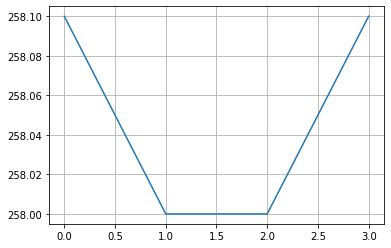

In [79]:
plt.plot(history[:,2])
plt.grid(True)

In [161]:
####### RNN DECODER

# attention module
class Attention1(nn.Module):
    '''
    Attention network for calculate attention value
    '''
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        '''
        :param encoder_dim: input size of encoder network
        :param decoder_dim: input size of decoder network
        :param attention_dim: input size of attention network
        '''
        super(Attention1, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att    = nn.Linear(attention_dim, 1)            # linear layer to calculate values to be softmax-ed
        self.relu        = nn.ReLU()
        self.softmax     = nn.Softmax(dim = 1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        print('encoder_out.shape', encoder_out.shape)
        #encoder_out = encoder_out.squeeze() # ? FIXME
        att1  = self.encoder_att(encoder_out)     # (batch_size, num_pixels, attention_dim)
        att2  = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att   = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)                 # (batch_size, num_pixels)
        print('alpha.shape', alpha.shape)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim = 1)  # (batch_size, encoder_dim)
        return attention_weighted_encoding, alpha
    
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)
        return attention_weighted_encoding, alpha
    
    
# custom LSTM cell
def LSTMCell(input_size, hidden_size, **kwargs):
    m = nn.LSTMCell(input_size, hidden_size, **kwargs)
    for name, param in m.named_parameters():
        if 'weight' in name or 'bias' in name:
            param.data.uniform_(-0.1, 0.1)
    return m


# decoder
class DecoderWithAttention1(nn.Module):
    '''
    Decoder network with attention network used for training
    '''

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, device, encoder_dim, dropout, num_layers):
        '''
        :param attention_dim: input size of attention network
        :param embed_dim: input size of embedding network
        :param decoder_dim: input size of decoder network
        :param vocab_size: total number of characters used in training
        :param encoder_dim: input size of encoder network
        :param num_layers: number of the LSTM layers
        :param dropout: dropout rate
        '''
        super(DecoderWithAttention1, self).__init__()
        self.encoder_dim   = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim     = embed_dim
        self.decoder_dim   = decoder_dim
        self.vocab_size    = vocab_size
        self.dropout       = dropout
        self.num_layers    = num_layers
        self.device        = device
        self.attention     = Attention1(encoder_dim, decoder_dim, attention_dim)  # attention network
        self.embedding     = nn.Embedding(vocab_size, embed_dim)                 # embedding layer
        self.dropout       = nn.Dropout(p = self.dropout)
        self.decode_step   = nn.ModuleList([LSTMCell(embed_dim + encoder_dim if layer == 0 else embed_dim, embed_dim) for layer in range(self.num_layers)]) # decoding LSTMCell        
        self.init_h        = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c        = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta        = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid       = nn.Sigmoid()
        self.fc            = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()                                      # initialize some layers with the uniform distribution

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune = True):
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        #print('mean_encoder_out.shape', encoder_out.shape)
        mean_encoder_out = encoder_out#.squeeze(2) #.mean(dim = 1)
        h = [self.init_h(mean_encoder_out) for i in range(self.num_layers)]  # (batch_size, decoder_dim)
        c = [self.init_c(mean_encoder_out) for i in range(self.num_layers)]
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        '''
        :param encoder_out: output of encoder network
        :param encoded_captions: transformed sequence from character to integer
        :param caption_lengths: length of transformed sequence
        '''
        batch_size       = encoder_out.size(0)
        encoder_dim      = encoder_out.size(-1)
        vocab_size       = self.vocab_size
        encoder_out = encoder_out.squeeze()
        #encoder_out      = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels       = encoder_out.size(1)
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim = 0, descending = True)
        encoder_out      = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]
        
        # embedding transformed sequence for vector
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)
        
        # Initialize LSTM state, initialize cell_vector and hidden_vector
        prev_h, prev_c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        
        # set decode length by caption length - 1 because of omitting start token
        decode_lengths = (caption_lengths - 1).tolist()
        predictions    = torch.zeros(batch_size, max(decode_lengths), vocab_size, device = self.device)
        alphas         = torch.zeros(batch_size, max(decode_lengths), num_pixels, device = self.device)
        
        # predict sequence
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                prev_h[-1][:batch_size_t])
            gate = self.sigmoid(self.f_beta(prev_h[-1][:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding

            input = torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1)
            
            for i, rnn in enumerate(self.decode_step):
                # recurrent cell
                h, c = rnn(input, (prev_h[i][:batch_size_t], prev_c[i][:batch_size_t])) # cell_vector and hidden_vector

                # hidden state becomes the input to the next layer
                input = self.dropout(h)

                # save state for next time step
                prev_h[i] = h
                prev_c[i] = c
                
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :]      = alpha
            
        return predictions, encoded_captions, decode_lengths, alphas, sort_ind
    
    def predict(self, encoder_out, decode_lengths, tokenizer):
        
        # size variables
        batch_size  = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size  = self.vocab_size
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels  = encoder_out.size(1)
        
        # embed start tocken for LSTM input
        start_tockens = torch.ones(batch_size, dtype = torch.long, device = self.device) * tokenizer.stoi['<sos>']
        embeddings    = self.embedding(start_tockens)
        
        # initialize hidden state and cell state of LSTM cell
        h, c        = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        predictions = torch.zeros(batch_size, decode_lengths, vocab_size, device = self.device)
        
        # predict sequence
        end_condition = torch.zeros(batch_size, dtype=torch.long, device = self.device)
        for t in range(decode_lengths):
            awe, alpha = self.attention(encoder_out, h[-1])  # (s, encoder_dim), (s, num_pixels)
            gate       = self.sigmoid(self.f_beta(h[-1]))    # gating scalar, (s, encoder_dim)
            awe        = gate * awe
            
            input = torch.cat([embeddings, awe], dim=1)
 
            for j, rnn in enumerate(self.decode_step):
                at_h, at_c = rnn(input, (h[j], c[j]))  # (s, decoder_dim)
                input = self.dropout(at_h)
                h[j]  = at_h
                c[j]  = at_c
            
            preds = self.fc(self.dropout(h[-1]))  # (batch_size_t, vocab_size)
            predictions[:, t, :] = preds
            end_condition |= (torch.argmax(preds, -1) == tokenizer.stoi["<eos>"])
            if end_condition.sum() == batch_size:
                break
            embeddings = self.embedding(torch.argmax(preds, -1))
        
        return predictions
    
    # beam search
    def forward_step(self, prev_tokens, hidden, encoder_out, function):
        
        h, c = hidden
        #h, c = h.squeeze(0), c.squeeze(0)
        h, c = [hi.squeeze(0) for hi in h], [ci.squeeze(0) for ci in c]
        
        embeddings = self.embedding(prev_tokens)
        if embeddings.dim() == 3:
            embeddings = embeddings.squeeze(1)
            
        awe, alpha = self.attention(encoder_out, h[-1])  # (s, encoder_dim), (s, num_pixels)
        gate       = self.sigmoid(self.f_beta(h[-1]))    # gating scalar, (s, encoder_dim)
        awe        = gate * awe
        
        input = torch.cat([embeddings, awe], dim = 1)
        for j, rnn in enumerate(self.decode_step):
            at_h, at_c = rnn(input, (h[j], c[j]))  # (s, decoder_dim)
            input = self.dropout(at_h)
            h[j]  = at_h
            c[j]  = at_c

        preds = self.fc(self.dropout(h[-1]))  # (batch_size_t, vocab_size)

        #hidden = (h.unsqueeze(0), c.unsqueeze(0))
        hidden = [hi.unsqueeze(0) for hi in h], [ci.unsqueeze(0) for ci in c]
        predicted_softmax = function(preds, dim = 1)
        
        return predicted_softmax, hidden, None

In [10]:
class Attention1(nn.Module):
    """
    Attention network for calculate attention value
    """
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: input size of encoder network
        :param decoder_dim: input size of decoder network
        :param attention_dim: input size of attention network
        """
        super(Attention1, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)
        return attention_weighted_encoding, alpha


class DecoderWithAttention1(nn.Module):
    """
    Decoder network with attention network used for training
    """

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, device, encoder_dim=512, dropout=0.5):
        """
        :param attention_dim: input size of attention network
        :param embed_dim: input size of embedding network
        :param decoder_dim: input size of decoder network
        :param vocab_size: total number of characters used in training
        :param encoder_dim: input size of encoder network
        :param dropout: dropout rate
        """
        super(DecoderWithAttention1, self).__init__()
        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout
        self.device = device
        self.attention = Attention1(encoder_dim, decoder_dim, attention_dim)  # attention network
        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        :param encoder_out: output of encoder network
        :param encoded_captions: transformed sequence from character to integer
        :param caption_lengths: length of transformed sequence
        """
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]
        # embedding transformed sequence for vector
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)
        # initialize hidden state and cell state of LSTM cell
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        # set decode length by caption length - 1 because of omitting start token
        decode_lengths = (caption_lengths - 1).tolist()
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(self.device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(self.device)
        # predict sequence
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t], h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha
        return predictions, encoded_captions, decode_lengths, alphas, sort_ind
    
    def predict(self, encoder_out, decode_lengths, tokenizer):
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)
        # embed start tocken for LSTM input
        start_tockens = torch.ones(batch_size, dtype=torch.long).to(self.device) * tokenizer.stoi["<sos>"]
        embeddings = self.embedding(start_tockens)
        # initialize hidden state and cell state of LSTM cell
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        predictions = torch.zeros(batch_size, decode_lengths, vocab_size).to(self.device)
        # predict sequence
        for t in range(decode_lengths):
            attention_weighted_encoding, alpha = self.attention(encoder_out, h)
            gate = self.sigmoid(self.f_beta(h))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings, attention_weighted_encoding], dim=1),
                (h, c))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:, t, :] = preds
            if np.argmax(preds.detach().cpu().numpy()) == tokenizer.stoi["<eos>"]:
                break
            embeddings = self.embedding(torch.argmax(preds, -1))
        return predictions

In [11]:
def train_epoch1(data_loader, encoder, decoder, optimizer, criterion):
    encoder.train()
    decoder.train()
    for (images, labels, label_lengths) in tqdm(data_loader): # labels already encoded
        
        # 1. Move batch to GPU (if available)
        images = images.to(device)
        labels = labels.to(device)
        label_lengths = label_lengths.to(device)
        
        # 2. Zeroing gradients.
        optimizer.zero_grad()
        
        # 3. Forward pass
        features = encoder(images)
        features = features.reshape(images.shape[0], 2, 2, 128)
        
        predictions, caps_sorted, decode_lengths, alphas, sort_ind = decoder(features, labels, label_lengths)
        targets = caps_sorted[:, 1:]
        predictions = nn.utils.rnn.pack_padded_sequence(predictions, decode_lengths, batch_first=True).data
        targets = nn.utils.rnn.pack_padded_sequence(targets, decode_lengths, batch_first=True).data
        
        # 4. Calculate loss.
        loss = criterion(predictions, targets)
        print('batch_loss', loss.item()) # debug
        
        # 5. Calculate gradients and perform optimization step.
        loss.backward() # clip_grad_norm may be used after this
        optimizer.step()

In [22]:
def train_model1(encoder, decoder, n_epochs, batch_size, history, finetune_encoder=False):
    
    # 1. Initialize and prepare data
    dataset_train = TrainDataset(file=cfg['train_dataset_file'], 
                                 x_size=cfg['x_size'], y_size=cfg['y_size'], n_of_samples=1000)
    dataset_valid = TrainDataset(file=cfg['valid_dataset_file'],
                                 x_size=cfg['x_size'], y_size=cfg['y_size'], n_of_samples=1000)
    
    data_train_loader = torch.utils.data.DataLoader(dataset_train, batch_size,
                                                   num_workers=6, persistent_workers=True, pin_memory=True,
                                                   collate_fn=CollateFunction)
    data_valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size,
                                                    num_workers=2, persistent_workers=False, pin_memory=False,
                                                   collate_fn=CollateFunction)
    # 2. Initialize loss and optimizer parameters
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.stoi["<pad>"]) # like in the link
    
    params_to_optimize = list(decoder.parameters())
    if finetune_encoder:
        params_to_optimize.extend(encoder.parameters())
    
    optimizer = torch.optim.Adam(params_to_optimize, lr=0.00005)
    
    # 3. Move model to GPU (if available)
    encoder.to(device)
    decoder.to(device)
    
    # 4. Train for n_epochs, calculating loss/metrics and saving model parameters
    for i in range(n_epochs):
        print('Starting epoch {}'.format(i))
        
        train_epoch1(data_train_loader, encoder, decoder, optimizer, criterion)
        
        # save model
        torch.save(decoder.state_dict(), 'data/decoder/decoder_v1_epoch_{}.model'.format(i))
        if finetune_encoder:
            torch.save(encoder.state_dict(), 'data/decoder/encoder_v1_epoch_{}.model'.format(i))
        
        # print and save metrics
        train_loss, train_metric = eval_performance(encoder, decoder, data_train_loader,
                                                    batch_size, max_count=15)
        valid_loss, valid_metric = 0.1, 0.1 #eval_performance(encoder, decoder, data_valid_loader, batch_size)
        print('Train loss:\t{:f}, \t test loss:\t{:f}'.format(train_loss, valid_loss))
        print('Levenshtein distance: on train:\t{},\t on test:\t{}'.format(train_metric, valid_metric))
        history[i,0] = train_loss
        history[i,1] = valid_loss
        history[i,2] = train_metric
        history[i,3] = valid_metric

In [192]:
encoder = ResNetEncoderPretrained('data/resnet_multiple_epoch_4_finetune.model').to(device)
decoder = DecoderWithAttention1(cfg['attention_dim'], cfg['embedding_dim'], cfg['decoder_dim'], 
                               vocab_size=len(tokenizer), dropout=cfg['dropout'],
                               device=device, encoder_dim=128).to(device) # enc_dim=512 # num_layers=2

In [193]:
%%time
train_model1(encoder, decoder, N_EPOCHS, batch_size=10, history=history, finetune_encoder=True)

  0%|          | 0/500 [00:00<?, ?it/s]

Starting epoch 0
batch_loss 5.310182571411133


  0%|          | 2/500 [00:00<03:49,  2.17it/s]

batch_loss 5.313508033752441


  1%|          | 3/500 [00:01<03:28,  2.38it/s]

batch_loss 5.310457229614258


  1%|          | 4/500 [00:01<03:14,  2.56it/s]

batch_loss 5.31353235244751
batch_loss 5.31492805480957


  1%|          | 6/500 [00:02<02:56,  2.80it/s]

batch_loss 5.310309886932373


  1%|▏         | 7/500 [00:02<02:48,  2.92it/s]

batch_loss 5.309277057647705
batch_loss 5.31249475479126


  2%|▏         | 8/500 [00:02<02:51,  2.88it/s]

batch_loss 5.307899475097656


  2%|▏         | 10/500 [00:03<02:48,  2.91it/s]

batch_loss 5.308950424194336


  2%|▏         | 11/500 [00:03<02:45,  2.95it/s]

batch_loss 5.310810565948486
batch_loss 5.3087873458862305


  3%|▎         | 13/500 [00:04<02:43,  2.99it/s]

batch_loss 5.311568260192871


  3%|▎         | 14/500 [00:04<02:38,  3.07it/s]

batch_loss 5.3067450523376465


  3%|▎         | 15/500 [00:05<02:36,  3.09it/s]

batch_loss 5.304853916168213
batch_loss 5.313150882720947


  3%|▎         | 16/500 [00:05<02:50,  2.84it/s]

batch_loss 5.314606189727783


  3%|▎         | 17/500 [00:05<02:52,  2.80it/s]

batch_loss 5.301846027374268


  4%|▎         | 18/500 [00:06<02:49,  2.84it/s]

batch_loss 5.305698871612549


  4%|▍         | 20/500 [00:06<02:44,  2.91it/s]

batch_loss 5.304276943206787


  4%|▍         | 21/500 [00:07<02:41,  2.97it/s]

batch_loss 5.307528972625732
batch_loss 5.301694393157959


  5%|▍         | 23/500 [00:07<02:41,  2.96it/s]

batch_loss 5.300258636474609
batch_loss 5.299319744110107


  5%|▌         | 25/500 [00:08<02:39,  2.98it/s]

batch_loss 5.299008369445801


  5%|▌         | 26/500 [00:08<02:35,  3.05it/s]

batch_loss 5.305448532104492


  5%|▌         | 27/500 [00:09<02:32,  3.10it/s]

batch_loss 5.2979350090026855


  6%|▌         | 28/500 [00:09<02:32,  3.09it/s]

batch_loss 5.300472736358643
batch_loss 5.299839973449707


  6%|▌         | 29/500 [00:09<02:36,  3.02it/s]

batch_loss 5.303831100463867


  6%|▌         | 31/500 [00:10<02:31,  3.10it/s]

batch_loss 5.301955223083496


  6%|▋         | 32/500 [00:10<02:26,  3.20it/s]

batch_loss 5.301635265350342
batch_loss 5.297238349914551


  7%|▋         | 33/500 [00:11<02:34,  3.01it/s]

batch_loss 5.300515651702881


  7%|▋         | 35/500 [00:11<02:33,  3.02it/s]

batch_loss 5.294718265533447
batch_loss 5.297987461090088


  7%|▋         | 37/500 [00:12<02:35,  2.98it/s]

batch_loss 5.294504642486572


  8%|▊         | 38/500 [00:12<02:30,  3.06it/s]

batch_loss 5.295443058013916
batch_loss 5.298110485076904


  8%|▊         | 40/500 [00:13<02:30,  3.05it/s]

batch_loss 5.298000335693359


  8%|▊         | 41/500 [00:13<02:26,  3.13it/s]

batch_loss 5.297484397888184
batch_loss 5.2929534912109375


  8%|▊         | 42/500 [00:14<02:29,  3.07it/s]

batch_loss 5.29548454284668


  9%|▉         | 44/500 [00:14<02:27,  3.09it/s]

batch_loss 5.295817852020264
batch_loss 5.287264823913574


  9%|▉         | 45/500 [00:15<02:44,  2.77it/s]

batch_loss 5.2926812171936035


  9%|▉         | 46/500 [00:15<02:49,  2.68it/s]

batch_loss 5.289096832275391


 10%|▉         | 48/500 [00:16<02:34,  2.92it/s]

batch_loss 5.292068004608154


 10%|▉         | 49/500 [00:16<02:30,  3.00it/s]

batch_loss 5.288248538970947
batch_loss 5.296726226806641


 10%|█         | 50/500 [00:16<02:31,  2.97it/s]

batch_loss 5.2934393882751465


 10%|█         | 52/500 [00:17<02:28,  3.02it/s]

batch_loss 5.287026405334473


 11%|█         | 53/500 [00:17<02:24,  3.09it/s]

batch_loss 5.285862445831299


 11%|█         | 54/500 [00:18<02:20,  3.16it/s]

batch_loss 5.291539669036865


 11%|█         | 55/500 [00:18<02:21,  3.15it/s]

batch_loss 5.294024467468262
batch_loss 5.288110256195068


 11%|█         | 56/500 [00:18<02:22,  3.11it/s]

batch_loss 5.29002046585083


 11%|█▏        | 57/500 [00:19<02:25,  3.05it/s]

batch_loss 5.288398265838623


 12%|█▏        | 59/500 [00:19<02:26,  3.01it/s]

batch_loss 5.286266326904297


 12%|█▏        | 60/500 [00:20<02:23,  3.07it/s]

batch_loss 5.286481857299805
batch_loss 5.283565044403076


 12%|█▏        | 62/500 [00:20<02:22,  3.08it/s]

batch_loss 5.2790937423706055
batch_loss 5.285858631134033


 13%|█▎        | 64/500 [00:21<02:20,  3.11it/s]

batch_loss 5.287249565124512
batch_loss 5.290139198303223


 13%|█▎        | 66/500 [00:22<02:21,  3.07it/s]

batch_loss 5.285236358642578


 13%|█▎        | 67/500 [00:22<02:19,  3.09it/s]

batch_loss 5.282964706420898
batch_loss 5.272712707519531


 14%|█▎        | 68/500 [00:22<02:22,  3.04it/s]

batch_loss 5.281468391418457


 14%|█▍        | 70/500 [00:23<02:24,  2.99it/s]

batch_loss 5.284565448760986


 14%|█▍        | 71/500 [00:23<02:21,  3.02it/s]

batch_loss 5.280693054199219


 14%|█▍        | 72/500 [00:24<02:20,  3.04it/s]

batch_loss 5.281328201293945


 15%|█▍        | 73/500 [00:24<02:18,  3.09it/s]

batch_loss 5.2799553871154785


 15%|█▍        | 74/500 [00:24<02:15,  3.15it/s]

batch_loss 5.288405895233154
batch_loss 5.282755374908447


 15%|█▌        | 76/500 [00:25<02:16,  3.10it/s]

batch_loss 5.273521423339844


 15%|█▌        | 77/500 [00:25<02:15,  3.13it/s]

batch_loss 5.275930881500244


 16%|█▌        | 78/500 [00:26<02:14,  3.13it/s]

batch_loss 5.27254056930542


 16%|█▌        | 79/500 [00:26<02:13,  3.16it/s]

batch_loss 5.275228023529053
batch_loss 5.273927688598633


 16%|█▌        | 80/500 [00:26<02:19,  3.00it/s]

batch_loss 5.27623176574707


 16%|█▌        | 81/500 [00:27<02:19,  3.01it/s]

batch_loss 5.280101299285889


 17%|█▋        | 83/500 [00:27<02:14,  3.10it/s]

batch_loss 5.276033878326416
batch_loss 5.2776994705200195


 17%|█▋        | 85/500 [00:28<02:13,  3.11it/s]

batch_loss 5.27366304397583
batch_loss 5.276669502258301


 17%|█▋        | 87/500 [00:29<02:13,  3.10it/s]

batch_loss 5.279507160186768


 18%|█▊        | 88/500 [00:29<02:12,  3.12it/s]

batch_loss 5.274414539337158
batch_loss 5.274494647979736


 18%|█▊        | 89/500 [00:29<02:20,  2.93it/s]

batch_loss 5.271136283874512


 18%|█▊        | 90/500 [00:30<02:21,  2.90it/s]

batch_loss 5.267922878265381


 18%|█▊        | 92/500 [00:30<02:16,  2.99it/s]

batch_loss 5.271207809448242
batch_loss 5.268045425415039


 19%|█▉        | 94/500 [00:31<02:14,  3.02it/s]

batch_loss 5.271294593811035
batch_loss 5.264676094055176


 19%|█▉        | 95/500 [00:31<02:13,  3.02it/s]

batch_loss 5.270769119262695


 19%|█▉        | 97/500 [00:32<02:12,  3.03it/s]

batch_loss 5.270451545715332


 20%|█▉        | 98/500 [00:32<02:10,  3.09it/s]

batch_loss 5.273426055908203
batch_loss 5.2672600746154785


 20%|█▉        | 99/500 [00:33<02:11,  3.06it/s]

batch_loss 5.265189170837402


 20%|██        | 101/500 [00:33<02:07,  3.12it/s]

batch_loss 5.2706732749938965
batch_loss 5.2664361000061035


 21%|██        | 103/500 [00:34<02:07,  3.11it/s]

batch_loss 5.267771244049072
batch_loss 5.266739368438721


 21%|██        | 104/500 [00:34<02:13,  2.97it/s]

batch_loss 5.267597675323486


 21%|██        | 105/500 [00:35<02:13,  2.96it/s]

batch_loss 5.265597820281982


 21%|██▏       | 107/500 [00:35<02:12,  2.97it/s]

batch_loss 5.260331153869629


 22%|██▏       | 108/500 [00:36<02:06,  3.09it/s]

batch_loss 5.266885280609131
batch_loss 5.263274192810059


 22%|██▏       | 109/500 [00:36<02:09,  3.02it/s]

batch_loss 5.267460823059082


 22%|██▏       | 111/500 [00:37<02:07,  3.05it/s]

batch_loss 5.261847019195557
batch_loss 5.266837120056152


 22%|██▏       | 112/500 [00:37<02:15,  2.86it/s]

batch_loss 5.259515762329102


 23%|██▎       | 114/500 [00:38<02:10,  2.95it/s]

batch_loss 5.264597415924072


 23%|██▎       | 115/500 [00:38<02:07,  3.02it/s]

batch_loss 5.260538101196289
batch_loss 5.254515171051025


 23%|██▎       | 117/500 [00:39<02:05,  3.05it/s]

batch_loss 5.253188133239746
batch_loss 5.258142471313477


 24%|██▎       | 118/500 [00:39<02:07,  2.99it/s]

batch_loss 5.256142616271973


 24%|██▍       | 120/500 [00:40<02:04,  3.05it/s]

batch_loss 5.255820274353027
batch_loss 5.25547981262207


 24%|██▍       | 122/500 [00:40<02:04,  3.03it/s]

batch_loss 5.2582597732543945


 25%|██▍       | 123/500 [00:41<02:02,  3.07it/s]

batch_loss 5.259327411651611


 25%|██▍       | 124/500 [00:41<01:58,  3.16it/s]

batch_loss 5.254912376403809
batch_loss 5.255093574523926


 25%|██▌       | 126/500 [00:41<02:00,  3.11it/s]

batch_loss 5.256439208984375
batch_loss 5.254063129425049


 26%|██▌       | 128/500 [00:42<02:03,  3.00it/s]

batch_loss 5.252035140991211


 26%|██▌       | 129/500 [00:42<02:01,  3.06it/s]

batch_loss 5.255955696105957


 26%|██▌       | 130/500 [00:43<02:00,  3.07it/s]

batch_loss 5.2490386962890625


 26%|██▌       | 131/500 [00:43<01:58,  3.11it/s]

batch_loss 5.252880573272705
batch_loss 5.252209663391113


 26%|██▋       | 132/500 [00:43<02:02,  3.01it/s]

batch_loss 5.25370979309082


 27%|██▋       | 133/500 [00:44<02:02,  3.00it/s]

batch_loss 5.251129150390625


 27%|██▋       | 134/500 [00:44<02:01,  3.01it/s]

batch_loss 5.248198509216309


 27%|██▋       | 135/500 [00:45<02:03,  2.95it/s]

batch_loss 5.253207683563232


 27%|██▋       | 136/500 [00:45<02:06,  2.88it/s]

batch_loss 5.247276306152344


 28%|██▊       | 138/500 [00:46<01:59,  3.03it/s]

batch_loss 5.248329162597656


 28%|██▊       | 139/500 [00:46<01:57,  3.08it/s]

batch_loss 5.248635292053223


 28%|██▊       | 140/500 [00:46<01:53,  3.16it/s]

batch_loss 5.2495222091674805


 28%|██▊       | 141/500 [00:46<01:53,  3.15it/s]

batch_loss 5.2462334632873535
batch_loss 5.243991374969482


 29%|██▊       | 143/500 [00:47<01:50,  3.23it/s]

batch_loss 5.2520904541015625
batch_loss 5.246068477630615


 29%|██▉       | 145/500 [00:48<01:53,  3.14it/s]

batch_loss 5.243190288543701


 29%|██▉       | 146/500 [00:48<01:53,  3.12it/s]

batch_loss 5.250048637390137
batch_loss 5.234714984893799


 29%|██▉       | 147/500 [00:48<02:06,  2.78it/s]

batch_loss 5.244856834411621


 30%|██▉       | 148/500 [00:49<02:03,  2.84it/s]

batch_loss 5.243531703948975


 30%|██▉       | 149/500 [00:49<02:01,  2.89it/s]

batch_loss 5.24352502822876


 30%|███       | 151/500 [00:50<01:55,  3.02it/s]

batch_loss 5.241522312164307
batch_loss 5.2418293952941895


 31%|███       | 153/500 [00:50<01:56,  2.98it/s]

batch_loss 5.237797737121582


 31%|███       | 154/500 [00:51<01:53,  3.05it/s]

batch_loss 5.240570545196533


 31%|███       | 155/500 [00:51<01:50,  3.12it/s]

batch_loss 5.240455627441406


 31%|███       | 156/500 [00:51<01:48,  3.17it/s]

batch_loss 5.245179653167725
batch_loss 5.236746788024902


 31%|███▏      | 157/500 [00:52<01:53,  3.01it/s]

batch_loss 5.240358829498291


 32%|███▏      | 158/500 [00:52<01:52,  3.03it/s]

batch_loss 5.236891746520996


 32%|███▏      | 160/500 [00:53<01:50,  3.08it/s]

batch_loss 5.238803386688232


 32%|███▏      | 161/500 [00:53<01:49,  3.10it/s]

batch_loss 5.236342430114746
batch_loss 5.234872341156006


 33%|███▎      | 163/500 [00:54<01:48,  3.11it/s]

batch_loss 5.236090660095215


 33%|███▎      | 164/500 [00:54<01:46,  3.15it/s]

batch_loss 5.235551357269287


 33%|███▎      | 165/500 [00:54<01:44,  3.21it/s]

batch_loss 5.238211154937744


 33%|███▎      | 166/500 [00:55<01:41,  3.27it/s]

batch_loss 5.236520290374756


 33%|███▎      | 167/500 [00:55<01:42,  3.24it/s]

batch_loss 5.234100341796875
batch_loss 5.237983226776123


 34%|███▍      | 169/500 [00:56<01:46,  3.10it/s]

batch_loss 5.236916542053223
batch_loss 5.238741397857666


 34%|███▍      | 170/500 [00:56<01:46,  3.09it/s]

batch_loss 5.2332611083984375


 34%|███▍      | 172/500 [00:57<01:47,  3.04it/s]

batch_loss 5.229367256164551
batch_loss 5.236415863037109


 35%|███▍      | 173/500 [00:57<01:47,  3.04it/s]

batch_loss 5.2309770584106445


 35%|███▍      | 174/500 [00:57<01:47,  3.04it/s]

batch_loss 5.23030948638916


 35%|███▌      | 176/500 [00:58<01:46,  3.04it/s]

batch_loss 5.233785152435303


 35%|███▌      | 177/500 [00:58<01:45,  3.06it/s]

batch_loss 5.235790729522705
batch_loss 5.224488258361816


 36%|███▌      | 179/500 [00:59<01:41,  3.16it/s]

batch_loss 5.229257106781006
batch_loss 5.2285637855529785


 36%|███▌      | 180/500 [00:59<01:42,  3.13it/s]

batch_loss 5.220907211303711


 36%|███▌      | 181/500 [01:00<01:43,  3.08it/s]

batch_loss 5.22507905960083


 36%|███▋      | 182/500 [01:00<01:43,  3.06it/s]

batch_loss 5.221241474151611


 37%|███▋      | 183/500 [01:00<01:45,  3.02it/s]

batch_loss 5.225061416625977


 37%|███▋      | 184/500 [01:01<01:45,  2.98it/s]

batch_loss 5.220544815063477


 37%|███▋      | 186/500 [01:01<01:48,  2.89it/s]

batch_loss 5.228474140167236
batch_loss 5.225055694580078


 37%|███▋      | 187/500 [01:02<01:47,  2.92it/s]

batch_loss 5.220102787017822


 38%|███▊      | 189/500 [01:02<01:45,  2.94it/s]

batch_loss 5.227660179138184


 38%|███▊      | 190/500 [01:03<01:40,  3.10it/s]

batch_loss 5.23154878616333


 38%|███▊      | 191/500 [01:03<01:37,  3.18it/s]

batch_loss 5.2233710289001465
batch_loss 5.213487148284912


 38%|███▊      | 192/500 [01:03<01:50,  2.80it/s]

batch_loss 5.223385810852051


 39%|███▉      | 194/500 [01:04<01:44,  2.92it/s]

batch_loss 5.218477249145508


 39%|███▉      | 195/500 [01:04<01:41,  3.02it/s]

batch_loss 5.224756717681885


 39%|███▉      | 196/500 [01:05<01:39,  3.06it/s]

batch_loss 5.220936298370361


 39%|███▉      | 197/500 [01:05<01:36,  3.13it/s]

batch_loss 5.222771644592285


 40%|███▉      | 198/500 [01:05<01:36,  3.12it/s]

batch_loss 5.215638637542725


 40%|███▉      | 199/500 [01:06<01:33,  3.21it/s]

batch_loss 5.2211079597473145
batch_loss 5.219306945800781


 40%|████      | 201/500 [01:06<01:34,  3.15it/s]

batch_loss 5.222325801849365


 40%|████      | 202/500 [01:06<01:33,  3.19it/s]

batch_loss 5.220098495483398
batch_loss 5.2183756828308105


 41%|████      | 203/500 [01:07<01:36,  3.06it/s]

batch_loss 5.202880859375


 41%|████      | 205/500 [01:08<01:40,  2.95it/s]

batch_loss 5.221463203430176


 41%|████      | 206/500 [01:08<01:35,  3.08it/s]

batch_loss 5.21618127822876


 41%|████▏     | 207/500 [01:08<01:32,  3.15it/s]

batch_loss 5.2125630378723145
batch_loss 5.210488319396973


 42%|████▏     | 209/500 [01:09<01:31,  3.18it/s]

batch_loss 5.216204643249512


 42%|████▏     | 210/500 [01:09<01:31,  3.17it/s]

batch_loss 5.211550235748291


 42%|████▏     | 211/500 [01:09<01:31,  3.15it/s]

batch_loss 5.217589378356934


 42%|████▏     | 212/500 [01:10<01:32,  3.12it/s]

batch_loss 5.212043285369873
batch_loss 5.211123466491699


 43%|████▎     | 213/500 [01:10<01:32,  3.09it/s]

batch_loss 5.210996627807617


 43%|████▎     | 215/500 [01:11<01:34,  3.01it/s]

batch_loss 5.215644836425781


 43%|████▎     | 216/500 [01:11<01:33,  3.04it/s]

batch_loss 5.212928771972656


 43%|████▎     | 217/500 [01:11<01:30,  3.12it/s]

batch_loss 5.212801933288574
batch_loss 5.203544616699219


 44%|████▍     | 219/500 [01:12<01:29,  3.14it/s]

batch_loss 5.20980978012085
batch_loss 5.207894802093506


 44%|████▍     | 221/500 [01:13<01:28,  3.16it/s]

batch_loss 5.208978176116943
batch_loss 5.209369659423828


 45%|████▍     | 223/500 [01:13<01:29,  3.09it/s]

batch_loss 5.204976558685303
batch_loss 5.208722114562988


 45%|████▍     | 224/500 [01:14<01:30,  3.05it/s]

batch_loss 5.19914436340332


 45%|████▌     | 225/500 [01:14<01:31,  2.99it/s]

batch_loss 5.20502233505249


 45%|████▌     | 226/500 [01:14<01:34,  2.91it/s]

batch_loss 5.198527812957764


 45%|████▌     | 227/500 [01:15<01:33,  2.92it/s]

batch_loss 5.1979756355285645


 46%|████▌     | 228/500 [01:15<01:39,  2.73it/s]

batch_loss 5.205240726470947


 46%|████▌     | 229/500 [01:16<01:38,  2.76it/s]

batch_loss 5.201981067657471


 46%|████▌     | 230/500 [01:16<01:35,  2.83it/s]

batch_loss 5.213585376739502


 46%|████▋     | 232/500 [01:16<01:30,  2.96it/s]

batch_loss 5.2011399269104
batch_loss 5.204573154449463


 47%|████▋     | 234/500 [01:17<01:29,  2.99it/s]

batch_loss 5.202873706817627


 47%|████▋     | 235/500 [01:17<01:27,  3.03it/s]

batch_loss 5.202326774597168
batch_loss 5.191755294799805


 47%|████▋     | 237/500 [01:18<01:27,  2.99it/s]

batch_loss 5.20243501663208
batch_loss 5.196505546569824


 48%|████▊     | 239/500 [01:19<01:25,  3.05it/s]

batch_loss 5.196762561798096
batch_loss 5.194030284881592


 48%|████▊     | 240/500 [01:19<01:26,  3.00it/s]

batch_loss 5.193474292755127


 48%|████▊     | 242/500 [01:20<01:29,  2.90it/s]

batch_loss 5.196412563323975


 49%|████▊     | 243/500 [01:20<01:26,  2.97it/s]

batch_loss 5.197597026824951
batch_loss 5.197291374206543


 49%|████▉     | 244/500 [01:21<01:28,  2.90it/s]

batch_loss 5.199342250823975


 49%|████▉     | 245/500 [01:21<01:27,  2.93it/s]

batch_loss 5.194986343383789


 49%|████▉     | 246/500 [01:21<01:26,  2.94it/s]

batch_loss 5.198642253875732


 50%|████▉     | 248/500 [01:22<01:24,  2.99it/s]

batch_loss 5.194756507873535
batch_loss 5.192041873931885


 50%|█████     | 250/500 [01:23<01:21,  3.08it/s]

batch_loss 5.19705057144165
batch_loss 5.190764427185059


 50%|█████     | 252/500 [01:23<01:20,  3.09it/s]

batch_loss 5.200813293457031
batch_loss 5.183996200561523


 51%|█████     | 254/500 [01:24<01:17,  3.16it/s]

batch_loss 5.193094730377197
batch_loss 5.192485809326172


 51%|█████     | 255/500 [01:24<01:20,  3.04it/s]

batch_loss 5.191856861114502


 51%|█████▏    | 257/500 [01:25<01:20,  3.01it/s]

batch_loss 5.191259384155273
batch_loss 5.186814785003662


 52%|█████▏    | 259/500 [01:26<01:21,  2.97it/s]

batch_loss 5.188821792602539


 52%|█████▏    | 260/500 [01:26<01:19,  3.03it/s]

batch_loss 5.192046165466309


 52%|█████▏    | 261/500 [01:26<01:16,  3.14it/s]

batch_loss 5.192165374755859


 52%|█████▏    | 262/500 [01:26<01:13,  3.23it/s]

batch_loss 5.197127819061279
batch_loss 5.189676284790039


 53%|█████▎    | 263/500 [01:27<01:14,  3.17it/s]

batch_loss 5.183560848236084


 53%|█████▎    | 265/500 [01:27<01:15,  3.12it/s]

batch_loss 5.175628662109375
batch_loss 5.18342924118042


 53%|█████▎    | 266/500 [01:28<01:15,  3.09it/s]

batch_loss 5.179701805114746


 53%|█████▎    | 267/500 [01:28<01:18,  2.96it/s]

batch_loss 5.182421684265137


 54%|█████▍    | 269/500 [01:29<01:17,  2.99it/s]

batch_loss 5.185619354248047


 54%|█████▍    | 270/500 [01:29<01:14,  3.10it/s]

batch_loss 5.18388032913208
batch_loss 5.1873016357421875


 54%|█████▍    | 272/500 [01:30<01:14,  3.04it/s]

batch_loss 5.187317371368408
batch_loss 5.182883262634277


 55%|█████▍    | 274/500 [01:30<01:14,  3.04it/s]

batch_loss 5.185042858123779


 55%|█████▌    | 275/500 [01:31<01:13,  3.05it/s]

batch_loss 5.17813777923584


 55%|█████▌    | 276/500 [01:31<01:12,  3.08it/s]

batch_loss 5.186120510101318


 55%|█████▌    | 277/500 [01:31<01:10,  3.15it/s]

batch_loss 5.186440944671631


 56%|█████▌    | 278/500 [01:32<01:10,  3.16it/s]

batch_loss 5.185566425323486
batch_loss 5.17889404296875


 56%|█████▌    | 279/500 [01:32<01:10,  3.13it/s]

batch_loss 5.178271770477295


 56%|█████▌    | 281/500 [01:33<01:10,  3.10it/s]

batch_loss 5.175757884979248


 56%|█████▋    | 282/500 [01:33<01:08,  3.17it/s]

batch_loss 5.176634788513184
batch_loss 5.183504104614258


 57%|█████▋    | 284/500 [01:34<01:08,  3.13it/s]

batch_loss 5.178997993469238
batch_loss 5.161247253417969


 57%|█████▋    | 286/500 [01:34<01:09,  3.06it/s]

batch_loss 5.17380952835083
batch_loss 5.173812389373779


 58%|█████▊    | 288/500 [01:35<01:09,  3.06it/s]

batch_loss 5.176690578460693
batch_loss 5.1719255447387695


 58%|█████▊    | 289/500 [01:35<01:11,  2.94it/s]

batch_loss 5.176168918609619


 58%|█████▊    | 291/500 [01:36<01:07,  3.11it/s]

batch_loss 5.174115180969238


 58%|█████▊    | 292/500 [01:36<01:06,  3.14it/s]

batch_loss 5.16834831237793
batch_loss 5.165796279907227


 59%|█████▉    | 294/500 [01:37<01:08,  3.02it/s]

batch_loss 5.165421485900879


 59%|█████▉    | 295/500 [01:37<01:07,  3.06it/s]

batch_loss 5.172436714172363
batch_loss 5.1700286865234375


 59%|█████▉    | 296/500 [01:38<01:08,  2.99it/s]

batch_loss 5.16518497467041


 60%|█████▉    | 298/500 [01:38<01:03,  3.16it/s]

batch_loss 5.18015718460083
batch_loss 5.16345739364624


 60%|██████    | 300/500 [01:39<01:03,  3.17it/s]

batch_loss 5.16924524307251
batch_loss 5.168427467346191


 60%|██████    | 301/500 [01:39<01:06,  3.01it/s]

batch_loss 5.162008285522461


 60%|██████    | 302/500 [01:40<01:07,  2.95it/s]

batch_loss 5.16061544418335


 61%|██████    | 304/500 [01:40<01:04,  3.02it/s]

batch_loss 5.166340351104736


 61%|██████    | 305/500 [01:41<01:03,  3.08it/s]

batch_loss 5.1688551902771
batch_loss 5.165706634521484


 61%|██████    | 306/500 [01:41<01:04,  3.02it/s]

batch_loss 5.162461280822754


 62%|██████▏   | 308/500 [01:42<01:03,  3.04it/s]

batch_loss 5.162665843963623
batch_loss 5.1627326011657715


 62%|██████▏   | 309/500 [01:42<01:02,  3.03it/s]

batch_loss 5.1581339836120605


 62%|██████▏   | 310/500 [01:42<01:04,  2.94it/s]

batch_loss 5.161163806915283


 62%|██████▏   | 312/500 [01:43<01:02,  3.02it/s]

batch_loss 5.163302898406982
batch_loss 5.157050132751465


 63%|██████▎   | 314/500 [01:44<01:02,  2.99it/s]

batch_loss 5.163551330566406
batch_loss 5.16441011428833


 63%|██████▎   | 316/500 [01:44<01:00,  3.05it/s]

batch_loss 5.167349815368652


 63%|██████▎   | 317/500 [01:45<00:58,  3.11it/s]

batch_loss 5.159718990325928


 64%|██████▎   | 318/500 [01:45<00:57,  3.14it/s]

batch_loss 5.154385089874268


 64%|██████▍   | 319/500 [01:45<00:57,  3.13it/s]

batch_loss 5.159945487976074


 64%|██████▍   | 320/500 [01:45<00:57,  3.15it/s]

batch_loss 5.15436315536499
batch_loss 5.164134502410889


 64%|██████▍   | 321/500 [01:46<00:58,  3.07it/s]

batch_loss 5.1546854972839355


 64%|██████▍   | 322/500 [01:46<01:01,  2.88it/s]

batch_loss 5.1524457931518555


 65%|██████▍   | 323/500 [01:47<01:00,  2.91it/s]

batch_loss 5.147121906280518


 65%|██████▍   | 324/500 [01:47<00:59,  2.95it/s]

batch_loss 5.155017375946045


 65%|██████▌   | 325/500 [01:47<00:58,  2.97it/s]

batch_loss 5.151772499084473


 65%|██████▌   | 326/500 [01:48<00:59,  2.92it/s]

batch_loss 5.1533203125


 65%|██████▌   | 327/500 [01:48<00:59,  2.93it/s]

batch_loss 5.159347057342529


 66%|██████▌   | 329/500 [01:49<00:56,  3.05it/s]

batch_loss 5.146975517272949
batch_loss 5.145593166351318


 66%|██████▌   | 331/500 [01:49<00:57,  2.96it/s]

batch_loss 5.148828029632568


 66%|██████▋   | 332/500 [01:50<00:54,  3.07it/s]

batch_loss 5.159551620483398


 67%|██████▋   | 333/500 [01:50<00:53,  3.10it/s]

batch_loss 5.156013488769531


 67%|██████▋   | 334/500 [01:50<00:53,  3.12it/s]

batch_loss 5.152400016784668
batch_loss 5.148199558258057


 67%|██████▋   | 336/500 [01:51<00:54,  2.99it/s]

batch_loss 5.14910888671875


 67%|██████▋   | 337/500 [01:51<00:53,  3.05it/s]

batch_loss 5.154287815093994
batch_loss 5.145905494689941


 68%|██████▊   | 339/500 [01:52<00:51,  3.11it/s]

batch_loss 5.1471171379089355
batch_loss 5.138869285583496


 68%|██████▊   | 341/500 [01:53<00:51,  3.09it/s]

batch_loss 5.146495819091797


 68%|██████▊   | 342/500 [01:53<00:50,  3.15it/s]

batch_loss 5.145438194274902


 69%|██████▊   | 343/500 [01:53<00:49,  3.18it/s]

batch_loss 5.148608684539795


 69%|██████▉   | 344/500 [01:53<00:49,  3.16it/s]

batch_loss 5.148809432983398
batch_loss 5.1369242668151855


 69%|██████▉   | 346/500 [01:54<00:50,  3.03it/s]

batch_loss 5.140926361083984


 69%|██████▉   | 347/500 [01:54<00:49,  3.06it/s]

batch_loss 5.14242696762085


 70%|██████▉   | 348/500 [01:55<00:49,  3.09it/s]

batch_loss 5.137875556945801
batch_loss 5.141509532928467


 70%|██████▉   | 349/500 [01:55<00:50,  3.01it/s]

batch_loss 5.138996124267578


 70%|███████   | 350/500 [01:55<00:49,  3.04it/s]

batch_loss 5.1419854164123535


 70%|███████   | 352/500 [01:56<00:47,  3.14it/s]

batch_loss 5.143951416015625
batch_loss 5.133910179138184


 71%|███████   | 353/500 [01:56<00:49,  2.99it/s]

batch_loss 5.12824821472168


 71%|███████   | 355/500 [01:57<00:47,  3.03it/s]

batch_loss 5.137530326843262


 71%|███████   | 356/500 [01:57<00:45,  3.15it/s]

batch_loss 5.141683578491211


 71%|███████▏  | 357/500 [01:58<00:45,  3.16it/s]

batch_loss 5.136787414550781
batch_loss 5.13351583480835


 72%|███████▏  | 358/500 [01:58<00:46,  3.05it/s]

batch_loss 5.131805896759033


 72%|███████▏  | 359/500 [01:58<00:47,  2.97it/s]

batch_loss 5.132752418518066


 72%|███████▏  | 361/500 [01:59<00:45,  3.06it/s]

batch_loss 5.145889759063721
batch_loss 5.134788990020752


 73%|███████▎  | 363/500 [02:00<00:44,  3.05it/s]

batch_loss 5.134446144104004
batch_loss 5.127596855163574


 73%|███████▎  | 365/500 [02:00<00:43,  3.09it/s]

batch_loss 5.134574890136719
batch_loss 5.130405902862549


 73%|███████▎  | 367/500 [02:01<00:43,  3.07it/s]

batch_loss 5.131927490234375


 74%|███████▎  | 368/500 [02:01<00:41,  3.15it/s]

batch_loss 5.125073432922363


 74%|███████▍  | 369/500 [02:02<00:40,  3.25it/s]

batch_loss 5.128666400909424


 74%|███████▍  | 370/500 [02:02<00:40,  3.20it/s]

batch_loss 5.128007888793945
batch_loss 5.126704692840576


 74%|███████▍  | 372/500 [02:03<00:40,  3.18it/s]

batch_loss 5.1415557861328125
batch_loss 5.126325607299805


 75%|███████▍  | 374/500 [02:03<00:41,  3.05it/s]

batch_loss 5.127191543579102
batch_loss 5.125765800476074


 75%|███████▌  | 376/500 [02:04<00:39,  3.11it/s]

batch_loss 5.1265411376953125


 75%|███████▌  | 377/500 [02:04<00:38,  3.20it/s]

batch_loss 5.129191875457764


 76%|███████▌  | 378/500 [02:05<00:38,  3.19it/s]

batch_loss 5.12217378616333


 76%|███████▌  | 379/500 [02:05<00:37,  3.21it/s]

batch_loss 5.118289470672607


 76%|███████▌  | 380/500 [02:05<00:37,  3.21it/s]

batch_loss 5.128177165985107
batch_loss 5.1295366287231445


 76%|███████▋  | 382/500 [02:06<00:37,  3.14it/s]

batch_loss 5.1348185539245605
batch_loss 5.119089126586914


 77%|███████▋  | 383/500 [02:06<00:37,  3.08it/s]

batch_loss 5.124168395996094


 77%|███████▋  | 385/500 [02:07<00:36,  3.18it/s]

batch_loss 5.127770900726318


 77%|███████▋  | 386/500 [02:07<00:35,  3.23it/s]

batch_loss 5.12413215637207


 77%|███████▋  | 387/500 [02:07<00:35,  3.19it/s]

batch_loss 5.1138200759887695
batch_loss 5.119995594024658


 78%|███████▊  | 388/500 [02:08<00:35,  3.14it/s]

batch_loss 5.095340251922607


 78%|███████▊  | 389/500 [02:08<00:38,  2.86it/s]

batch_loss 5.125411033630371


 78%|███████▊  | 390/500 [02:08<00:37,  2.92it/s]

batch_loss 5.110407829284668


 78%|███████▊  | 392/500 [02:09<00:36,  2.99it/s]

batch_loss 5.114291667938232
batch_loss 5.122161865234375


 79%|███████▉  | 394/500 [02:10<00:34,  3.06it/s]

batch_loss 5.109918117523193


 79%|███████▉  | 395/500 [02:10<00:33,  3.15it/s]

batch_loss 5.119025230407715


 79%|███████▉  | 396/500 [02:10<00:32,  3.19it/s]

batch_loss 5.117980003356934


 79%|███████▉  | 397/500 [02:11<00:31,  3.23it/s]

batch_loss 5.115725517272949


 80%|███████▉  | 398/500 [02:11<00:31,  3.20it/s]

batch_loss 5.117665767669678
batch_loss 5.1088666915893555


 80%|████████  | 400/500 [02:12<00:31,  3.21it/s]

batch_loss 5.123409271240234
batch_loss 5.104125022888184


 80%|████████  | 402/500 [02:12<00:31,  3.14it/s]

batch_loss 5.109338283538818
batch_loss 5.098640441894531


 81%|████████  | 404/500 [02:13<00:32,  2.99it/s]

batch_loss 5.116275787353516


 81%|████████  | 405/500 [02:13<00:31,  3.02it/s]

batch_loss 5.120450496673584


 81%|████████  | 406/500 [02:14<00:30,  3.12it/s]

batch_loss 5.118673324584961
batch_loss 5.109063625335693


 81%|████████▏ | 407/500 [02:14<00:30,  3.01it/s]

batch_loss 5.105223178863525


 82%|████████▏ | 409/500 [02:15<00:29,  3.10it/s]

batch_loss 5.113574504852295
batch_loss 5.107370853424072


 82%|████████▏ | 411/500 [02:15<00:28,  3.08it/s]

batch_loss 5.105060577392578
batch_loss 5.104663848876953


 83%|████████▎ | 413/500 [02:16<00:28,  3.09it/s]

batch_loss 5.115562915802002


 83%|████████▎ | 414/500 [02:16<00:27,  3.09it/s]

batch_loss 5.1000823974609375


 83%|████████▎ | 415/500 [02:17<00:27,  3.08it/s]

batch_loss 5.116957664489746
batch_loss 5.106794834136963


 83%|████████▎ | 416/500 [02:17<00:28,  2.92it/s]

batch_loss 5.093149185180664


 83%|████████▎ | 417/500 [02:17<00:29,  2.78it/s]

batch_loss 5.105528354644775


 84%|████████▍ | 419/500 [02:18<00:28,  2.85it/s]

batch_loss 5.10117244720459
batch_loss 5.091205596923828


 84%|████████▍ | 421/500 [02:19<00:27,  2.92it/s]

batch_loss 5.100974082946777


 84%|████████▍ | 422/500 [02:19<00:26,  2.97it/s]

batch_loss 5.104802131652832


 85%|████████▍ | 423/500 [02:19<00:25,  3.02it/s]

batch_loss 5.111824035644531
batch_loss 5.091610908508301


 85%|████████▌ | 425/500 [02:20<00:24,  3.01it/s]

batch_loss 5.093414306640625
batch_loss 5.092891216278076


 85%|████████▌ | 427/500 [02:21<00:23,  3.05it/s]

batch_loss 5.106539726257324
batch_loss 5.086087703704834


 86%|████████▌ | 429/500 [02:21<00:23,  3.04it/s]

batch_loss 5.108938694000244


 86%|████████▌ | 430/500 [02:22<00:22,  3.10it/s]

batch_loss 5.103828430175781


 86%|████████▌ | 431/500 [02:22<00:22,  3.12it/s]

batch_loss 5.101447105407715


 86%|████████▋ | 432/500 [02:22<00:20,  3.25it/s]

batch_loss 5.096968650817871
batch_loss 5.08626651763916


 87%|████████▋ | 434/500 [02:23<00:20,  3.15it/s]

batch_loss 5.099344253540039


 87%|████████▋ | 435/500 [02:23<00:20,  3.18it/s]

batch_loss 5.094531536102295


 87%|████████▋ | 436/500 [02:24<00:19,  3.22it/s]

batch_loss 5.094209671020508


 87%|████████▋ | 437/500 [02:24<00:19,  3.19it/s]

batch_loss 5.087203025817871
batch_loss 5.081235408782959


 88%|████████▊ | 439/500 [02:24<00:18,  3.26it/s]

batch_loss 5.093128681182861
batch_loss 5.085708141326904


 88%|████████▊ | 440/500 [02:25<00:19,  3.04it/s]

batch_loss 5.080187797546387


 88%|████████▊ | 441/500 [02:25<00:19,  3.03it/s]

batch_loss 5.0836005210876465


 89%|████████▊ | 443/500 [02:26<00:18,  3.07it/s]

batch_loss 5.090663909912109


 89%|████████▉ | 444/500 [02:26<00:17,  3.18it/s]

batch_loss 5.085414886474609
batch_loss 5.089787483215332


 89%|████████▉ | 446/500 [02:27<00:17,  3.07it/s]

batch_loss 5.076850891113281


 89%|████████▉ | 447/500 [02:27<00:17,  3.07it/s]

batch_loss 5.096180438995361
batch_loss 5.07589054107666


 90%|████████▉ | 449/500 [02:28<00:16,  3.05it/s]

batch_loss 5.0866899490356445
batch_loss 5.086402893066406


 90%|█████████ | 451/500 [02:28<00:15,  3.19it/s]

batch_loss 5.086136341094971
batch_loss 5.086239814758301


 90%|█████████ | 452/500 [02:29<00:15,  3.12it/s]

batch_loss 5.081998348236084


 91%|█████████ | 453/500 [02:29<00:15,  3.10it/s]

batch_loss 5.09126615524292


 91%|█████████ | 455/500 [02:30<00:14,  3.08it/s]

batch_loss 5.087516784667969


 91%|█████████ | 456/500 [02:30<00:14,  3.10it/s]

batch_loss 5.082453727722168


 91%|█████████▏| 457/500 [02:30<00:13,  3.09it/s]

batch_loss 5.085964679718018
batch_loss 5.083686351776123


 92%|█████████▏| 459/500 [02:31<00:13,  3.07it/s]

batch_loss 5.080450534820557


 92%|█████████▏| 460/500 [02:31<00:12,  3.14it/s]

batch_loss 5.078754425048828


 92%|█████████▏| 461/500 [02:32<00:12,  3.22it/s]

batch_loss 5.083921432495117


 92%|█████████▏| 462/500 [02:32<00:11,  3.24it/s]

batch_loss 5.078088283538818
batch_loss 5.080264568328857


 93%|█████████▎| 463/500 [02:32<00:11,  3.17it/s]

batch_loss 5.074244976043701


 93%|█████████▎| 465/500 [02:33<00:11,  3.16it/s]

batch_loss 5.0761494636535645


 93%|█████████▎| 466/500 [02:33<00:10,  3.14it/s]

batch_loss 5.069512844085693
batch_loss 5.076011657714844


 93%|█████████▎| 467/500 [02:34<00:10,  3.09it/s]

batch_loss 5.0759358406066895


 94%|█████████▎| 468/500 [02:34<00:10,  3.04it/s]

batch_loss 5.072126388549805


 94%|█████████▍| 469/500 [02:34<00:10,  2.98it/s]

batch_loss 5.065720081329346


 94%|█████████▍| 470/500 [02:35<00:09,  3.00it/s]

batch_loss 5.063792705535889


 94%|█████████▍| 471/500 [02:35<00:09,  2.95it/s]

batch_loss 5.071215629577637


 94%|█████████▍| 472/500 [02:35<00:09,  2.95it/s]

batch_loss 5.0846052169799805


 95%|█████████▍| 474/500 [02:36<00:08,  3.00it/s]

batch_loss 5.056600570678711


 95%|█████████▌| 475/500 [02:36<00:08,  3.10it/s]

batch_loss 5.0677409172058105


 95%|█████████▌| 476/500 [02:37<00:07,  3.15it/s]

batch_loss 5.064069747924805


 95%|█████████▌| 477/500 [02:37<00:07,  3.25it/s]

batch_loss 5.070589065551758


 96%|█████████▌| 478/500 [02:37<00:06,  3.26it/s]

batch_loss 5.071254253387451


 96%|█████████▌| 479/500 [02:37<00:06,  3.23it/s]

batch_loss 5.062232494354248
batch_loss 5.0743513107299805


 96%|█████████▌| 480/500 [02:38<00:06,  3.16it/s]

batch_loss 5.065826416015625


 96%|█████████▋| 482/500 [02:38<00:05,  3.21it/s]

batch_loss 5.063694953918457


 97%|█████████▋| 483/500 [02:39<00:05,  3.29it/s]

batch_loss 5.064894676208496


 97%|█████████▋| 484/500 [02:39<00:04,  3.27it/s]

batch_loss 5.069616794586182


 97%|█████████▋| 485/500 [02:39<00:04,  3.24it/s]

batch_loss 5.055140972137451


 97%|█████████▋| 486/500 [02:40<00:04,  3.19it/s]

batch_loss 5.049401760101318
batch_loss 5.054346084594727


 98%|█████████▊| 488/500 [02:40<00:03,  3.13it/s]

batch_loss 5.0618896484375


 98%|█████████▊| 489/500 [02:41<00:03,  3.17it/s]

batch_loss 5.050148010253906
batch_loss 5.044186592102051


 98%|█████████▊| 491/500 [02:41<00:03,  2.98it/s]

batch_loss 5.063793182373047


 98%|█████████▊| 492/500 [02:42<00:02,  3.07it/s]

batch_loss 5.064438819885254


 99%|█████████▊| 493/500 [02:42<00:02,  3.11it/s]

batch_loss 5.064052104949951
batch_loss 5.058491230010986


 99%|█████████▉| 495/500 [02:43<00:01,  3.05it/s]

batch_loss 5.061099529266357


 99%|█████████▉| 496/500 [02:43<00:01,  3.14it/s]

batch_loss 5.060647964477539
batch_loss 5.067238807678223


100%|█████████▉| 498/500 [02:44<00:00,  3.08it/s]

batch_loss 5.051289081573486
batch_loss 5.048569202423096


100%|██████████| 500/500 [02:44<00:00,  3.03it/s]

batch_loss 5.055408000946045



  0%|          | 0/500 [00:00<?, ?it/s]

CCC--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Train loss:	0.000000, 	 test loss:	0.100000
Levenshtein distance: on train:	258.1,	 on test:	0.1
Starting epoch 1
batch_loss 5.059205055236816


  0%|          | 2/500 [00:00<02:48,  2.96it/s]

batch_loss 5.054248332977295


  1%|          | 3/500 [00:00<02:45,  3.00it/s]

batch_loss 5.052643775939941


  1%|          | 4/500 [00:01<02:43,  3.03it/s]

batch_loss 5.060248851776123
batch_loss 5.037957191467285


  1%|          | 6/500 [00:01<02:42,  3.04it/s]

batch_loss 5.046056270599365


  1%|▏         | 7/500 [00:02<02:39,  3.09it/s]

batch_loss 5.04217529296875
batch_loss 5.041294097900391


  2%|▏         | 8/500 [00:02<02:43,  3.01it/s]

batch_loss 5.048099517822266


  2%|▏         | 10/500 [00:03<02:44,  2.98it/s]

batch_loss 5.047658443450928


  2%|▏         | 11/500 [00:03<02:42,  3.00it/s]

batch_loss 5.0372772216796875
batch_loss 5.016373157501221


  3%|▎         | 13/500 [00:04<02:41,  3.01it/s]

batch_loss 5.046949863433838


  3%|▎         | 14/500 [00:04<02:37,  3.08it/s]

batch_loss 5.052140712738037


  3%|▎         | 15/500 [00:04<02:36,  3.09it/s]

batch_loss 5.044240951538086
batch_loss 5.024249076843262


  3%|▎         | 16/500 [00:05<02:44,  2.95it/s]

batch_loss 5.03623104095459


  4%|▎         | 18/500 [00:05<02:39,  3.02it/s]

batch_loss 5.052514553070068


  4%|▍         | 19/500 [00:06<02:37,  3.05it/s]

batch_loss 5.040435314178467


  4%|▍         | 20/500 [00:06<02:34,  3.11it/s]

batch_loss 5.036078929901123


  4%|▍         | 21/500 [00:06<02:33,  3.11it/s]

batch_loss 5.047926425933838
batch_loss 5.030846118927002


  5%|▍         | 23/500 [00:07<02:37,  3.03it/s]

batch_loss 5.029001712799072
batch_loss 5.041062831878662


  5%|▌         | 25/500 [00:08<02:36,  3.04it/s]

batch_loss 5.034793376922607


  5%|▌         | 26/500 [00:08<02:33,  3.10it/s]

batch_loss 5.017590045928955


  5%|▌         | 27/500 [00:08<02:30,  3.14it/s]

batch_loss 5.028687477111816


  6%|▌         | 28/500 [00:09<02:30,  3.15it/s]

batch_loss 5.030732154846191
batch_loss 5.040902137756348


  6%|▌         | 29/500 [00:09<02:32,  3.08it/s]

batch_loss 5.027994632720947


  6%|▌         | 31/500 [00:10<02:28,  3.16it/s]

batch_loss 5.0402679443359375


  6%|▋         | 32/500 [00:10<02:23,  3.26it/s]

batch_loss 5.038372993469238
batch_loss 5.02876091003418


  7%|▋         | 33/500 [00:10<02:33,  3.05it/s]

batch_loss 5.030953884124756


  7%|▋         | 34/500 [00:11<02:34,  3.02it/s]

batch_loss 5.035346508026123


  7%|▋         | 35/500 [00:11<02:33,  3.03it/s]

batch_loss 5.035498142242432


  7%|▋         | 37/500 [00:12<02:33,  3.01it/s]

batch_loss 5.0280914306640625


  8%|▊         | 38/500 [00:12<02:29,  3.10it/s]

batch_loss 5.028110504150391
batch_loss 5.017637252807617


  8%|▊         | 40/500 [00:13<02:30,  3.06it/s]

batch_loss 5.026700019836426


  8%|▊         | 41/500 [00:13<02:25,  3.15it/s]

batch_loss 5.02203893661499
batch_loss 5.037246227264404


  8%|▊         | 42/500 [00:13<02:28,  3.07it/s]

batch_loss 5.024246692657471


  9%|▉         | 44/500 [00:14<02:27,  3.10it/s]

batch_loss 5.025623321533203
batch_loss 4.996730327606201


  9%|▉         | 45/500 [00:14<02:37,  2.89it/s]

batch_loss 5.014684677124023


  9%|▉         | 46/500 [00:15<02:38,  2.86it/s]

batch_loss 5.025081157684326


 10%|▉         | 48/500 [00:15<02:27,  3.06it/s]

batch_loss 5.036046981811523


 10%|▉         | 49/500 [00:16<02:22,  3.17it/s]

batch_loss 5.020870208740234
batch_loss 5.015622615814209


 10%|█         | 50/500 [00:16<02:26,  3.07it/s]

batch_loss 5.008342266082764


 10%|█         | 52/500 [00:17<02:25,  3.07it/s]

batch_loss 5.009711265563965


 11%|█         | 53/500 [00:17<02:22,  3.13it/s]

batch_loss 5.024405002593994


 11%|█         | 54/500 [00:17<02:19,  3.20it/s]

batch_loss 5.022195339202881


 11%|█         | 55/500 [00:18<02:19,  3.19it/s]

batch_loss 5.021897315979004


 11%|█         | 56/500 [00:18<02:20,  3.17it/s]

batch_loss 5.021866798400879
batch_loss 5.005075454711914


 11%|█▏        | 57/500 [00:18<02:24,  3.07it/s]

batch_loss 5.012001037597656


 12%|█▏        | 59/500 [00:19<02:26,  3.01it/s]

batch_loss 5.002411842346191


 12%|█▏        | 60/500 [00:19<02:23,  3.06it/s]

batch_loss 5.013006687164307
batch_loss 5.018335342407227


 12%|█▏        | 62/500 [00:20<02:22,  3.08it/s]

batch_loss 5.040307998657227
batch_loss 4.998032569885254


 13%|█▎        | 64/500 [00:20<02:21,  3.09it/s]

batch_loss 5.012650966644287
batch_loss 4.999858856201172


 13%|█▎        | 66/500 [00:21<02:21,  3.06it/s]

batch_loss 5.010516166687012


 13%|█▎        | 67/500 [00:21<02:20,  3.08it/s]

batch_loss 5.01060152053833


 14%|█▎        | 68/500 [00:22<02:19,  3.10it/s]

batch_loss 5.018299102783203
batch_loss 4.977312088012695


 14%|█▍        | 70/500 [00:22<02:20,  3.05it/s]

batch_loss 5.000614643096924


 14%|█▍        | 71/500 [00:23<02:19,  3.06it/s]

batch_loss 5.0005784034729


 14%|█▍        | 72/500 [00:23<02:18,  3.08it/s]

batch_loss 5.004079341888428


 15%|█▍        | 73/500 [00:23<02:17,  3.11it/s]

batch_loss 5.006853103637695


 15%|█▍        | 74/500 [00:24<02:14,  3.18it/s]

batch_loss 4.992199897766113
batch_loss 5.000357627868652


 15%|█▌        | 76/500 [00:24<02:14,  3.15it/s]

batch_loss 5.001895904541016


 15%|█▌        | 77/500 [00:25<02:13,  3.17it/s]

batch_loss 5.0027570724487305


 16%|█▌        | 78/500 [00:25<02:13,  3.17it/s]

batch_loss 4.980247974395752


 16%|█▌        | 79/500 [00:25<02:11,  3.19it/s]

batch_loss 4.9787092208862305
batch_loss 4.993966102600098


 16%|█▌        | 80/500 [00:26<02:19,  3.01it/s]

batch_loss 4.996415615081787


 16%|█▌        | 81/500 [00:26<02:18,  3.02it/s]

batch_loss 5.004862308502197


 17%|█▋        | 83/500 [00:27<02:13,  3.12it/s]

batch_loss 4.980140686035156
batch_loss 5.001468181610107


 17%|█▋        | 85/500 [00:27<02:13,  3.12it/s]

batch_loss 4.997647762298584
batch_loss 4.993203639984131


 17%|█▋        | 87/500 [00:28<02:13,  3.10it/s]

batch_loss 5.002918243408203


 18%|█▊        | 88/500 [00:28<02:12,  3.11it/s]

batch_loss 4.9953532218933105
batch_loss 4.978766441345215


 18%|█▊        | 89/500 [00:29<02:21,  2.90it/s]

batch_loss 4.98281717300415


 18%|█▊        | 90/500 [00:29<02:22,  2.88it/s]

batch_loss 4.974748134613037


 18%|█▊        | 91/500 [00:29<02:20,  2.92it/s]

batch_loss 4.999599933624268


 18%|█▊        | 92/500 [00:30<02:17,  2.96it/s]

batch_loss 4.977133274078369


 19%|█▉        | 94/500 [00:30<02:15,  3.00it/s]

batch_loss 4.974368572235107
batch_loss 4.974917888641357


 19%|█▉        | 95/500 [00:31<02:14,  3.00it/s]

batch_loss 4.984220027923584


 19%|█▉        | 97/500 [00:31<02:13,  3.01it/s]

batch_loss 4.9792680740356445


 20%|█▉        | 98/500 [00:32<02:10,  3.08it/s]

batch_loss 4.978549003601074
batch_loss 4.9891228675842285


 20%|█▉        | 99/500 [00:32<02:11,  3.05it/s]

batch_loss 4.991457462310791


 20%|██        | 101/500 [00:33<02:08,  3.11it/s]

batch_loss 4.986164569854736
batch_loss 4.986689567565918


 21%|██        | 103/500 [00:33<02:08,  3.09it/s]

batch_loss 4.985605239868164
batch_loss 4.963972568511963


 21%|██        | 104/500 [00:34<02:14,  2.95it/s]

batch_loss 4.973442077636719


 21%|██        | 105/500 [00:34<02:14,  2.95it/s]

batch_loss 4.9668402671813965


 21%|██▏       | 107/500 [00:35<02:12,  2.96it/s]

batch_loss 4.973989009857178


 22%|██▏       | 108/500 [00:35<02:07,  3.07it/s]

batch_loss 4.982893466949463
batch_loss 4.957505702972412


 22%|██▏       | 109/500 [00:35<02:09,  3.02it/s]

batch_loss 4.960129737854004


 22%|██▏       | 111/500 [00:36<02:06,  3.07it/s]

batch_loss 4.984087944030762
batch_loss 4.943698406219482


 22%|██▏       | 112/500 [00:36<02:15,  2.87it/s]

batch_loss 4.979383945465088


 23%|██▎       | 114/500 [00:37<02:10,  2.95it/s]

batch_loss 4.976585865020752


 23%|██▎       | 115/500 [00:37<02:07,  3.03it/s]

batch_loss 4.960356712341309
batch_loss 4.979378700256348


 23%|██▎       | 117/500 [00:38<02:05,  3.05it/s]

batch_loss 4.967255115509033
batch_loss 4.964106559753418


 24%|██▎       | 118/500 [00:38<02:07,  2.99it/s]

batch_loss 4.9741973876953125


 24%|██▍       | 120/500 [00:39<02:04,  3.05it/s]

batch_loss 4.9827070236206055
batch_loss 4.956035137176514


 24%|██▍       | 122/500 [00:40<02:04,  3.03it/s]

batch_loss 4.980692386627197


 25%|██▍       | 123/500 [00:40<02:02,  3.07it/s]

batch_loss 4.970826625823975


 25%|██▍       | 124/500 [00:40<01:58,  3.18it/s]

batch_loss 4.967738628387451
batch_loss 4.967708587646484


 25%|██▌       | 126/500 [00:41<02:00,  3.11it/s]

batch_loss 4.976342678070068
batch_loss 4.96027135848999


 26%|██▌       | 128/500 [00:42<02:03,  3.02it/s]

batch_loss 4.963769912719727


 26%|██▌       | 129/500 [00:42<01:59,  3.11it/s]

batch_loss 4.9667067527771


 26%|██▌       | 130/500 [00:42<01:57,  3.14it/s]

batch_loss 4.9533891677856445


 26%|██▌       | 131/500 [00:43<01:56,  3.18it/s]

batch_loss 4.967503070831299
batch_loss 4.94887638092041


 26%|██▋       | 132/500 [00:43<02:00,  3.05it/s]

batch_loss 4.939050674438477


 27%|██▋       | 133/500 [00:43<02:01,  3.02it/s]

batch_loss 4.952600002288818


 27%|██▋       | 134/500 [00:44<02:01,  3.01it/s]

batch_loss 4.940612316131592


 27%|██▋       | 135/500 [00:44<02:04,  2.93it/s]

batch_loss 4.937601566314697


 27%|██▋       | 136/500 [00:44<02:07,  2.85it/s]

batch_loss 4.945562362670898


 28%|██▊       | 138/500 [00:45<02:00,  3.01it/s]

batch_loss 4.960424423217773


 28%|██▊       | 139/500 [00:45<01:57,  3.06it/s]

batch_loss 4.940203666687012


 28%|██▊       | 140/500 [00:46<01:54,  3.14it/s]

batch_loss 4.935049057006836


 28%|██▊       | 141/500 [00:46<01:54,  3.14it/s]

batch_loss 4.951100826263428
batch_loss 4.9531569480896


 29%|██▊       | 143/500 [00:46<01:51,  3.21it/s]

batch_loss 4.956858158111572
batch_loss 4.960831642150879


 29%|██▉       | 145/500 [00:47<01:53,  3.11it/s]

batch_loss 4.956629276275635


 29%|██▉       | 146/500 [00:47<01:53,  3.11it/s]

batch_loss 4.949965000152588
batch_loss 4.886386871337891


 29%|██▉       | 147/500 [00:48<02:07,  2.76it/s]

batch_loss 4.940756320953369


 30%|██▉       | 148/500 [00:48<02:04,  2.83it/s]

batch_loss 4.9292988777160645


 30%|██▉       | 149/500 [00:49<02:02,  2.87it/s]

batch_loss 4.94705867767334


 30%|███       | 151/500 [00:49<01:56,  3.00it/s]

batch_loss 4.951524257659912
batch_loss 4.92228364944458


 30%|███       | 152/500 [00:50<01:59,  2.92it/s]

batch_loss 4.953995227813721


 31%|███       | 154/500 [00:50<01:53,  3.04it/s]

batch_loss 4.926072120666504


 31%|███       | 155/500 [00:51<01:51,  3.10it/s]

batch_loss 4.9543681144714355


 31%|███       | 156/500 [00:51<01:49,  3.14it/s]

batch_loss 4.93849515914917
batch_loss 4.9284443855285645


 31%|███▏      | 157/500 [00:51<01:54,  2.99it/s]

batch_loss 4.933681488037109


 32%|███▏      | 158/500 [00:52<01:53,  3.00it/s]

batch_loss 4.922515869140625


 32%|███▏      | 160/500 [00:52<01:51,  3.05it/s]

batch_loss 4.9379096031188965


 32%|███▏      | 161/500 [00:53<01:50,  3.08it/s]

batch_loss 4.926905155181885


 32%|███▏      | 162/500 [00:53<01:48,  3.12it/s]

batch_loss 4.918477535247803


 33%|███▎      | 163/500 [00:53<01:47,  3.13it/s]

batch_loss 4.926370620727539


 33%|███▎      | 164/500 [00:53<01:46,  3.16it/s]

batch_loss 4.957056522369385


 33%|███▎      | 165/500 [00:54<01:44,  3.21it/s]

batch_loss 4.923664093017578


 33%|███▎      | 166/500 [00:54<01:41,  3.28it/s]

batch_loss 4.934928894042969


 33%|███▎      | 167/500 [00:54<01:42,  3.25it/s]

batch_loss 4.945154666900635
batch_loss 4.911431312561035


 34%|███▍      | 169/500 [00:55<01:47,  3.08it/s]

batch_loss 4.937168598175049
batch_loss 4.928796768188477


 34%|███▍      | 170/500 [00:55<01:47,  3.06it/s]

batch_loss 4.919682502746582


 34%|███▍      | 172/500 [00:56<01:48,  3.03it/s]

batch_loss 4.912676811218262
batch_loss 4.92421293258667


 35%|███▍      | 173/500 [00:56<01:47,  3.03it/s]

batch_loss 4.91961145401001


 35%|███▍      | 174/500 [00:57<01:48,  2.99it/s]

batch_loss 4.924122333526611


 35%|███▌      | 176/500 [00:57<01:48,  3.00it/s]

batch_loss 4.933699607849121


 35%|███▌      | 177/500 [00:58<01:46,  3.02it/s]

batch_loss 4.919515609741211
batch_loss 4.89266300201416


 36%|███▌      | 179/500 [00:58<01:43,  3.12it/s]

batch_loss 4.936288833618164
batch_loss 4.915644645690918


 36%|███▌      | 180/500 [00:59<01:43,  3.10it/s]

batch_loss 4.902961730957031


 36%|███▌      | 181/500 [00:59<01:44,  3.05it/s]

batch_loss 4.9078450202941895


 36%|███▋      | 182/500 [00:59<01:45,  3.03it/s]

batch_loss 4.904983997344971


 37%|███▋      | 183/500 [01:00<01:45,  2.99it/s]

batch_loss 4.8778510093688965


 37%|███▋      | 184/500 [01:00<01:46,  2.97it/s]

batch_loss 4.83876895904541


 37%|███▋      | 186/500 [01:01<01:49,  2.87it/s]

batch_loss 4.936728477478027
batch_loss 4.907447338104248


 37%|███▋      | 187/500 [01:01<01:47,  2.91it/s]

batch_loss 4.872743606567383


 38%|███▊      | 189/500 [01:02<01:45,  2.94it/s]

batch_loss 4.917624473571777


 38%|███▊      | 190/500 [01:02<01:40,  3.08it/s]

batch_loss 4.909250736236572


 38%|███▊      | 191/500 [01:02<01:37,  3.15it/s]

batch_loss 4.923831462860107
batch_loss 4.844580173492432


 39%|███▊      | 193/500 [01:03<01:47,  2.87it/s]

batch_loss 4.915973663330078


 39%|███▉      | 194/500 [01:04<01:44,  2.93it/s]

batch_loss 4.886176109313965


 39%|███▉      | 195/500 [01:04<01:40,  3.02it/s]

batch_loss 4.912220478057861


 39%|███▉      | 196/500 [01:04<01:39,  3.06it/s]

batch_loss 4.899862289428711


 39%|███▉      | 197/500 [01:04<01:36,  3.13it/s]

batch_loss 4.910258769989014
batch_loss 4.908576965332031


 40%|███▉      | 199/500 [01:05<01:34,  3.20it/s]

batch_loss 4.89676570892334
batch_loss 4.898716449737549


 40%|████      | 201/500 [01:06<01:35,  3.14it/s]

batch_loss 4.9162774085998535


 40%|████      | 202/500 [01:06<01:33,  3.18it/s]

batch_loss 4.915491104125977
batch_loss 4.886171817779541


 41%|████      | 203/500 [01:06<01:37,  3.06it/s]

batch_loss 4.829468727111816


 41%|████      | 205/500 [01:07<01:40,  2.93it/s]

batch_loss 4.911340236663818


 41%|████      | 206/500 [01:07<01:35,  3.07it/s]

batch_loss 4.901764869689941


 41%|████▏     | 207/500 [01:08<01:33,  3.13it/s]

batch_loss 4.876906871795654
batch_loss 4.892116069793701


 42%|████▏     | 209/500 [01:08<01:31,  3.18it/s]

batch_loss 4.905207633972168


 42%|████▏     | 210/500 [01:09<01:31,  3.16it/s]

batch_loss 4.889204502105713


 42%|████▏     | 211/500 [01:09<01:31,  3.15it/s]

batch_loss 4.903319835662842
batch_loss 4.858616352081299


 42%|████▏     | 212/500 [01:09<01:32,  3.11it/s]

batch_loss 4.911144733428955


 43%|████▎     | 213/500 [01:10<01:33,  3.08it/s]

batch_loss 4.886987686157227


 43%|████▎     | 215/500 [01:10<01:35,  2.99it/s]

batch_loss 4.899771690368652


 43%|████▎     | 216/500 [01:11<01:33,  3.02it/s]

batch_loss 4.891966342926025


 43%|████▎     | 217/500 [01:11<01:31,  3.10it/s]

batch_loss 4.882218360900879
batch_loss 4.8876800537109375


 44%|████▍     | 219/500 [01:12<01:30,  3.11it/s]

batch_loss 4.882052421569824
batch_loss 4.874857425689697


 44%|████▍     | 221/500 [01:12<01:28,  3.15it/s]

batch_loss 4.879936695098877
batch_loss 4.906556606292725


 45%|████▍     | 223/500 [01:13<01:29,  3.09it/s]

batch_loss 4.8719563484191895
batch_loss 4.872218608856201


 45%|████▍     | 224/500 [01:13<01:30,  3.06it/s]

batch_loss 4.861911296844482


 45%|████▌     | 225/500 [01:14<01:31,  3.00it/s]

batch_loss 4.880289077758789


 45%|████▌     | 226/500 [01:14<01:33,  2.94it/s]

batch_loss 4.856875896453857


 45%|████▌     | 227/500 [01:14<01:33,  2.93it/s]

batch_loss 4.867269992828369


 46%|████▌     | 228/500 [01:15<01:39,  2.74it/s]

batch_loss 4.884060382843018


 46%|████▌     | 229/500 [01:15<01:37,  2.78it/s]

batch_loss 4.886171817779541


 46%|████▌     | 230/500 [01:15<01:35,  2.84it/s]

batch_loss 4.903470993041992


 46%|████▋     | 232/500 [01:16<01:29,  2.99it/s]

batch_loss 4.869334697723389
batch_loss 4.87492561340332


 47%|████▋     | 234/500 [01:17<01:28,  3.01it/s]

batch_loss 4.87743616104126


 47%|████▋     | 235/500 [01:17<01:26,  3.05it/s]

batch_loss 4.8715009689331055
batch_loss 4.827548980712891


 47%|████▋     | 237/500 [01:18<01:27,  3.00it/s]

batch_loss 4.876436233520508
batch_loss 4.851313591003418


 48%|████▊     | 239/500 [01:18<01:25,  3.05it/s]

batch_loss 4.876309394836426
batch_loss 4.860786437988281


 48%|████▊     | 240/500 [01:19<01:26,  3.00it/s]

batch_loss 4.825586318969727


 48%|████▊     | 242/500 [01:19<01:28,  2.92it/s]

batch_loss 4.855600833892822


 49%|████▊     | 243/500 [01:20<01:25,  3.00it/s]

batch_loss 4.8627610206604
batch_loss 4.875033855438232


 49%|████▉     | 244/500 [01:20<01:27,  2.92it/s]

batch_loss 4.8663411140441895


 49%|████▉     | 245/500 [01:20<01:26,  2.95it/s]

batch_loss 4.8540940284729


 49%|████▉     | 246/500 [01:21<01:25,  2.96it/s]

batch_loss 4.864278316497803


 50%|████▉     | 248/500 [01:21<01:24,  3.00it/s]

batch_loss 4.8706560134887695
batch_loss 4.859328269958496


 50%|█████     | 250/500 [01:22<01:20,  3.09it/s]

batch_loss 4.890990734100342
batch_loss 4.856568336486816


 50%|█████     | 252/500 [01:23<01:20,  3.10it/s]

batch_loss 4.857827663421631
batch_loss 4.830618858337402


 51%|█████     | 254/500 [01:23<01:17,  3.17it/s]

batch_loss 4.84086275100708
batch_loss 4.868175983428955


 51%|█████     | 255/500 [01:24<01:20,  3.05it/s]

batch_loss 4.837070941925049


 51%|█████▏    | 257/500 [01:24<01:20,  3.02it/s]

batch_loss 4.8509907722473145
batch_loss 4.832553386688232


 52%|█████▏    | 259/500 [01:25<01:20,  2.99it/s]

batch_loss 4.836938381195068


 52%|█████▏    | 260/500 [01:25<01:18,  3.04it/s]

batch_loss 4.8621954917907715


 52%|█████▏    | 261/500 [01:26<01:15,  3.16it/s]

batch_loss 4.855670928955078


 52%|█████▏    | 262/500 [01:26<01:13,  3.25it/s]

batch_loss 4.85482931137085
batch_loss 4.853778839111328


 53%|█████▎    | 263/500 [01:26<01:14,  3.19it/s]

batch_loss 4.837700366973877


 53%|█████▎    | 265/500 [01:27<01:15,  3.13it/s]

batch_loss 4.8153076171875
batch_loss 4.8232502937316895


 53%|█████▎    | 266/500 [01:27<01:15,  3.10it/s]

batch_loss 4.81749963760376


 53%|█████▎    | 267/500 [01:28<01:18,  2.97it/s]

batch_loss 4.829309940338135


 54%|█████▍    | 269/500 [01:28<01:16,  3.00it/s]

batch_loss 4.853733062744141


 54%|█████▍    | 270/500 [01:29<01:13,  3.11it/s]

batch_loss 4.820019245147705
batch_loss 4.8669514656066895


 54%|█████▍    | 272/500 [01:29<01:14,  3.05it/s]

batch_loss 4.8448486328125
batch_loss 4.848443984985352


 55%|█████▍    | 274/500 [01:30<01:13,  3.06it/s]

batch_loss 4.847434043884277
batch_loss 4.8334150314331055


 55%|█████▌    | 276/500 [01:31<01:12,  3.08it/s]

batch_loss 4.836500644683838


 55%|█████▌    | 277/500 [01:31<01:10,  3.16it/s]

batch_loss 4.840385913848877


 56%|█████▌    | 278/500 [01:31<01:10,  3.16it/s]

batch_loss 4.843957901000977
batch_loss 4.826342582702637


 56%|█████▌    | 279/500 [01:32<01:10,  3.13it/s]

batch_loss 4.841330528259277


 56%|█████▌    | 281/500 [01:32<01:10,  3.09it/s]

batch_loss 4.825179576873779


 56%|█████▋    | 282/500 [01:32<01:09,  3.15it/s]

batch_loss 4.8290910720825195
batch_loss 4.835550308227539


 57%|█████▋    | 284/500 [01:33<01:09,  3.13it/s]

batch_loss 4.830320358276367
batch_loss 4.763045787811279


 57%|█████▋    | 286/500 [01:34<01:10,  3.05it/s]

batch_loss 4.7947869300842285
batch_loss 4.802132606506348


 58%|█████▊    | 288/500 [01:34<01:09,  3.04it/s]

batch_loss 4.8142170906066895
batch_loss 4.815585613250732


 58%|█████▊    | 289/500 [01:35<01:12,  2.93it/s]

batch_loss 4.8204216957092285


 58%|█████▊    | 291/500 [01:35<01:07,  3.08it/s]

batch_loss 4.800302982330322


 58%|█████▊    | 292/500 [01:36<01:06,  3.11it/s]

batch_loss 4.81309700012207
batch_loss 4.792336940765381


 59%|█████▉    | 294/500 [01:36<01:08,  2.99it/s]

batch_loss 4.8078179359436035


 59%|█████▉    | 295/500 [01:37<01:07,  3.03it/s]

batch_loss 4.825688362121582
batch_loss 4.821866512298584


 59%|█████▉    | 296/500 [01:37<01:08,  2.96it/s]

batch_loss 4.814456939697266


 60%|█████▉    | 298/500 [01:38<01:05,  3.10it/s]

batch_loss 4.831823825836182
batch_loss 4.795379638671875


 60%|██████    | 300/500 [01:38<01:03,  3.14it/s]

batch_loss 4.814652442932129
batch_loss 4.80337381362915


 60%|██████    | 301/500 [01:39<01:06,  2.98it/s]

batch_loss 4.792113780975342


 60%|██████    | 302/500 [01:39<01:07,  2.94it/s]

batch_loss 4.781558036804199


 61%|██████    | 304/500 [01:40<01:05,  3.01it/s]

batch_loss 4.8118696212768555


 61%|██████    | 305/500 [01:40<01:03,  3.06it/s]

batch_loss 4.799370288848877
batch_loss 4.811452865600586


 61%|██████    | 306/500 [01:40<01:04,  2.99it/s]

batch_loss 4.800074577331543


 62%|██████▏   | 308/500 [01:41<01:03,  3.03it/s]

batch_loss 4.802021026611328
batch_loss 4.783817768096924


 62%|██████▏   | 309/500 [01:41<01:03,  3.03it/s]

batch_loss 4.793933391571045


 62%|██████▏   | 310/500 [01:42<01:04,  2.94it/s]

batch_loss 4.786489009857178


 62%|██████▏   | 312/500 [01:42<01:02,  3.00it/s]

batch_loss 4.801817417144775
batch_loss 4.769396781921387


 63%|██████▎   | 314/500 [01:43<01:02,  2.98it/s]

batch_loss 4.789472579956055
batch_loss 4.792567729949951


 63%|██████▎   | 316/500 [01:44<01:00,  3.03it/s]

batch_loss 4.801689624786377


 63%|██████▎   | 317/500 [01:44<00:59,  3.08it/s]

batch_loss 4.7891998291015625


 64%|██████▎   | 318/500 [01:44<00:58,  3.12it/s]

batch_loss 4.771707534790039


 64%|██████▍   | 319/500 [01:45<00:58,  3.12it/s]

batch_loss 4.789604663848877


 64%|██████▍   | 320/500 [01:45<00:57,  3.14it/s]

batch_loss 4.773246765136719
batch_loss 4.802892684936523


 64%|██████▍   | 321/500 [01:45<00:58,  3.05it/s]

batch_loss 4.783268451690674


 64%|██████▍   | 322/500 [01:46<01:02,  2.86it/s]

batch_loss 4.778421878814697


 65%|██████▍   | 323/500 [01:46<01:01,  2.90it/s]

batch_loss 4.778359889984131


 65%|██████▍   | 324/500 [01:46<01:00,  2.93it/s]

batch_loss 4.786562919616699


 65%|██████▌   | 325/500 [01:47<00:59,  2.96it/s]

batch_loss 4.750572204589844


 65%|██████▌   | 326/500 [01:47<00:59,  2.90it/s]

batch_loss 4.754950046539307


 65%|██████▌   | 327/500 [01:48<00:59,  2.90it/s]

batch_loss 4.788987636566162


 66%|██████▌   | 329/500 [01:48<00:56,  3.02it/s]

batch_loss 4.73391580581665
batch_loss 4.768710136413574


 66%|██████▌   | 331/500 [01:49<00:57,  2.93it/s]

batch_loss 4.739571571350098


 66%|██████▋   | 332/500 [01:49<00:55,  3.04it/s]

batch_loss 4.7886128425598145


 67%|██████▋   | 333/500 [01:49<00:54,  3.07it/s]

batch_loss 4.78741979598999


 67%|██████▋   | 334/500 [01:50<00:53,  3.09it/s]

batch_loss 4.770488739013672
batch_loss 4.775078296661377


 67%|██████▋   | 336/500 [01:51<00:55,  2.96it/s]

batch_loss 4.756031513214111


 67%|██████▋   | 337/500 [01:51<00:53,  3.03it/s]

batch_loss 4.787163257598877
batch_loss 4.744263172149658


 68%|██████▊   | 339/500 [01:51<00:52,  3.09it/s]

batch_loss 4.750020980834961
batch_loss 4.73000955581665


 68%|██████▊   | 341/500 [01:52<00:51,  3.07it/s]

batch_loss 4.755206108093262


 68%|██████▊   | 342/500 [01:52<00:50,  3.14it/s]

batch_loss 4.7655110359191895


 69%|██████▊   | 343/500 [01:53<00:49,  3.16it/s]

batch_loss 4.773336410522461


 69%|██████▉   | 344/500 [01:53<00:49,  3.14it/s]

batch_loss 4.773475646972656
batch_loss 4.7331318855285645


 69%|██████▉   | 346/500 [01:54<00:51,  3.02it/s]

batch_loss 4.749794960021973


 69%|██████▉   | 347/500 [01:54<00:50,  3.04it/s]

batch_loss 4.754479885101318


 70%|██████▉   | 348/500 [01:54<00:49,  3.07it/s]

batch_loss 4.728991985321045
batch_loss 4.760815620422363


 70%|███████   | 350/500 [01:55<00:49,  3.01it/s]

batch_loss 4.747239112854004
batch_loss 4.750173568725586


 70%|███████   | 352/500 [01:56<00:47,  3.11it/s]

batch_loss 4.757920742034912
batch_loss 4.720831871032715


 71%|███████   | 353/500 [01:56<00:49,  2.95it/s]

batch_loss 4.709627151489258


 71%|███████   | 355/500 [01:57<00:48,  2.98it/s]

batch_loss 4.728089332580566


 71%|███████   | 356/500 [01:57<00:46,  3.09it/s]

batch_loss 4.729612827301025


 71%|███████▏  | 357/500 [01:57<00:46,  3.10it/s]

batch_loss 4.7327728271484375
batch_loss 4.744682788848877


 72%|███████▏  | 358/500 [01:58<00:47,  3.00it/s]

batch_loss 4.737179756164551


 72%|███████▏  | 359/500 [01:58<00:48,  2.93it/s]

batch_loss 4.731474876403809


 72%|███████▏  | 361/500 [01:59<00:45,  3.03it/s]

batch_loss 4.763391494750977
batch_loss 4.740041732788086


 72%|███████▏  | 362/500 [01:59<00:45,  3.01it/s]

batch_loss 4.743009090423584


 73%|███████▎  | 363/500 [01:59<00:45,  3.02it/s]

batch_loss 4.712611198425293


 73%|███████▎  | 365/500 [02:00<00:44,  3.05it/s]

batch_loss 4.745129108428955
batch_loss 4.730474472045898


 73%|███████▎  | 367/500 [02:01<00:43,  3.04it/s]

batch_loss 4.721960544586182


 74%|███████▎  | 368/500 [02:01<00:42,  3.12it/s]

batch_loss 4.705867767333984


 74%|███████▍  | 369/500 [02:01<00:40,  3.22it/s]

batch_loss 4.713037967681885


 74%|███████▍  | 370/500 [02:02<00:40,  3.18it/s]

batch_loss 4.723031997680664
batch_loss 4.752900123596191


 74%|███████▍  | 372/500 [02:02<00:40,  3.15it/s]

batch_loss 4.7714409828186035
batch_loss 4.720890045166016


 75%|███████▍  | 374/500 [02:03<00:41,  3.04it/s]

batch_loss 4.718817710876465
batch_loss 4.711096286773682


 75%|███████▌  | 376/500 [02:04<00:40,  3.10it/s]

batch_loss 4.725533962249756


 75%|███████▌  | 377/500 [02:04<00:38,  3.18it/s]

batch_loss 4.728666305541992


 76%|███████▌  | 378/500 [02:04<00:38,  3.18it/s]

batch_loss 4.701881408691406


 76%|███████▌  | 379/500 [02:05<00:37,  3.19it/s]

batch_loss 4.6865644454956055


 76%|███████▌  | 380/500 [02:05<00:37,  3.19it/s]

batch_loss 4.722877502441406
batch_loss 4.740572929382324


 76%|███████▋  | 382/500 [02:06<00:37,  3.12it/s]

batch_loss 4.724822521209717
batch_loss 4.7021050453186035


 77%|███████▋  | 383/500 [02:06<00:38,  3.06it/s]

batch_loss 4.725320816040039


 77%|███████▋  | 385/500 [02:07<00:36,  3.17it/s]

batch_loss 4.718466758728027


 77%|███████▋  | 386/500 [02:07<00:35,  3.22it/s]

batch_loss 4.710577011108398


 77%|███████▋  | 387/500 [02:07<00:35,  3.18it/s]

batch_loss 4.689809799194336
batch_loss 4.702578544616699


 78%|███████▊  | 388/500 [02:07<00:35,  3.13it/s]

batch_loss 4.648303508758545


 78%|███████▊  | 389/500 [02:08<00:38,  2.85it/s]

batch_loss 4.725406169891357


 78%|███████▊  | 390/500 [02:08<00:37,  2.89it/s]

batch_loss 4.679426193237305


 78%|███████▊  | 392/500 [02:09<00:36,  2.98it/s]

batch_loss 4.694118022918701
batch_loss 4.713438987731934


 79%|███████▉  | 394/500 [02:10<00:34,  3.05it/s]

batch_loss 4.680473327636719


 79%|███████▉  | 395/500 [02:10<00:33,  3.14it/s]

batch_loss 4.695578575134277


 79%|███████▉  | 396/500 [02:10<00:32,  3.17it/s]

batch_loss 4.698962211608887


 79%|███████▉  | 397/500 [02:10<00:31,  3.22it/s]

batch_loss 4.699378490447998


 80%|███████▉  | 398/500 [02:11<00:31,  3.20it/s]

batch_loss 4.715592861175537
batch_loss 4.672158241271973


 80%|████████  | 400/500 [02:11<00:31,  3.20it/s]

batch_loss 4.724068641662598
batch_loss 4.675609111785889


 80%|████████  | 402/500 [02:12<00:31,  3.13it/s]

batch_loss 4.698352813720703
batch_loss 4.656798839569092


 81%|████████  | 404/500 [02:13<00:32,  2.98it/s]

batch_loss 4.716437816619873


 81%|████████  | 405/500 [02:13<00:31,  3.02it/s]

batch_loss 4.708658218383789


 81%|████████  | 406/500 [02:13<00:30,  3.12it/s]

batch_loss 4.710566997528076
batch_loss 4.683741092681885


 81%|████████▏ | 407/500 [02:14<00:30,  3.00it/s]

batch_loss 4.69050931930542


 82%|████████▏ | 409/500 [02:14<00:29,  3.10it/s]

batch_loss 4.692115306854248
batch_loss 4.675349235534668


 82%|████████▏ | 411/500 [02:15<00:28,  3.09it/s]

batch_loss 4.668181419372559
batch_loss 4.678433418273926


 83%|████████▎ | 413/500 [02:16<00:28,  3.09it/s]

batch_loss 4.70011568069458
batch_loss 4.653799533843994


 83%|████████▎ | 414/500 [02:16<00:27,  3.08it/s]

batch_loss 4.71606969833374


 83%|████████▎ | 415/500 [02:16<00:27,  3.08it/s]

batch_loss 4.687035083770752


 83%|████████▎ | 416/500 [02:17<00:28,  2.92it/s]

batch_loss 4.627767562866211


 83%|████████▎ | 417/500 [02:17<00:29,  2.77it/s]

batch_loss 4.681988716125488


 84%|████████▍ | 419/500 [02:18<00:28,  2.84it/s]

batch_loss 4.653727054595947
batch_loss 4.643774509429932


 84%|████████▍ | 421/500 [02:18<00:27,  2.92it/s]

batch_loss 4.681339263916016
batch_loss 4.671307563781738


 85%|████████▍ | 423/500 [02:19<00:25,  3.01it/s]

batch_loss 4.695361137390137
batch_loss 4.635126113891602


 85%|████████▌ | 425/500 [02:20<00:24,  3.00it/s]

batch_loss 4.655383586883545
batch_loss 4.652770042419434


 85%|████████▌ | 427/500 [02:20<00:24,  3.04it/s]

batch_loss 4.676267147064209
batch_loss 4.636752128601074


 86%|████████▌ | 429/500 [02:21<00:23,  3.03it/s]

batch_loss 4.702573299407959


 86%|████████▌ | 430/500 [02:21<00:22,  3.08it/s]

batch_loss 4.667429447174072


 86%|████████▌ | 431/500 [02:22<00:22,  3.10it/s]

batch_loss 4.665719032287598


 86%|████████▋ | 432/500 [02:22<00:21,  3.23it/s]

batch_loss 4.6460795402526855
batch_loss 4.636794090270996


 87%|████████▋ | 434/500 [02:23<00:21,  3.13it/s]

batch_loss 4.671915531158447


 87%|████████▋ | 435/500 [02:23<00:20,  3.17it/s]

batch_loss 4.670173645019531


 87%|████████▋ | 436/500 [02:23<00:19,  3.22it/s]

batch_loss 4.651928901672363


 87%|████████▋ | 437/500 [02:24<00:19,  3.19it/s]

batch_loss 4.6298604011535645
batch_loss 4.636760711669922


 88%|████████▊ | 439/500 [02:24<00:18,  3.25it/s]

batch_loss 4.652220249176025
batch_loss 4.631028175354004


 88%|████████▊ | 440/500 [02:25<00:19,  3.04it/s]

batch_loss 4.628906726837158


 88%|████████▊ | 441/500 [02:25<00:19,  3.04it/s]

batch_loss 4.614685535430908


 89%|████████▊ | 443/500 [02:26<00:18,  3.08it/s]

batch_loss 4.656618118286133


 89%|████████▉ | 444/500 [02:26<00:17,  3.18it/s]

batch_loss 4.632245063781738
batch_loss 4.653566360473633


 89%|████████▉ | 446/500 [02:27<00:17,  3.07it/s]

batch_loss 4.618973731994629
batch_loss 4.659985065460205


 89%|████████▉ | 447/500 [02:27<00:17,  3.06it/s]

batch_loss 4.606011867523193


 90%|████████▉ | 449/500 [02:28<00:16,  3.04it/s]

batch_loss 4.641720294952393
batch_loss 4.642340660095215


 90%|█████████ | 451/500 [02:28<00:15,  3.17it/s]

batch_loss 4.641844272613525
batch_loss 4.63748836517334


 90%|█████████ | 452/500 [02:29<00:15,  3.10it/s]

batch_loss 4.632150650024414


 91%|█████████ | 453/500 [02:29<00:15,  3.08it/s]

batch_loss 4.647812366485596


 91%|█████████ | 455/500 [02:30<00:14,  3.07it/s]

batch_loss 4.642313003540039


 91%|█████████ | 456/500 [02:30<00:14,  3.09it/s]

batch_loss 4.619540214538574
batch_loss 4.64612340927124


 91%|█████████▏| 457/500 [02:30<00:13,  3.08it/s]

batch_loss 4.652207374572754


 92%|█████████▏| 459/500 [02:31<00:13,  3.06it/s]

batch_loss 4.602051258087158


 92%|█████████▏| 460/500 [02:31<00:12,  3.13it/s]

batch_loss 4.624354839324951


 92%|█████████▏| 461/500 [02:31<00:12,  3.20it/s]

batch_loss 4.616796016693115


 92%|█████████▏| 462/500 [02:32<00:11,  3.22it/s]

batch_loss 4.597344398498535
batch_loss 4.616824626922607


 93%|█████████▎| 463/500 [02:32<00:11,  3.15it/s]

batch_loss 4.611687660217285


 93%|█████████▎| 465/500 [02:33<00:11,  3.15it/s]

batch_loss 4.6159772872924805


 93%|█████████▎| 466/500 [02:33<00:10,  3.13it/s]

batch_loss 4.599685192108154
batch_loss 4.608858108520508


 93%|█████████▎| 467/500 [02:33<00:10,  3.07it/s]

batch_loss 4.622681617736816


 94%|█████████▎| 468/500 [02:34<00:10,  3.02it/s]

batch_loss 4.596903324127197


 94%|█████████▍| 469/500 [02:34<00:10,  2.96it/s]

batch_loss 4.584675312042236


 94%|█████████▍| 470/500 [02:34<00:10,  2.98it/s]

batch_loss 4.593438148498535


 94%|█████████▍| 471/500 [02:35<00:09,  2.93it/s]

batch_loss 4.60353422164917


 94%|█████████▍| 472/500 [02:35<00:09,  2.93it/s]

batch_loss 4.630578994750977


 95%|█████████▍| 474/500 [02:36<00:08,  2.98it/s]

batch_loss 4.56259298324585


 95%|█████████▌| 475/500 [02:36<00:08,  3.08it/s]

batch_loss 4.601593971252441


 95%|█████████▌| 476/500 [02:36<00:07,  3.13it/s]

batch_loss 4.581863880157471


 95%|█████████▌| 477/500 [02:37<00:07,  3.24it/s]

batch_loss 4.605548858642578


 96%|█████████▌| 478/500 [02:37<00:06,  3.25it/s]

batch_loss 4.609284400939941


 96%|█████████▌| 479/500 [02:37<00:06,  3.22it/s]

batch_loss 4.57542085647583
batch_loss 4.624520778656006


 96%|█████████▌| 480/500 [02:38<00:06,  3.14it/s]

batch_loss 4.589396953582764


 96%|█████████▋| 482/500 [02:38<00:05,  3.20it/s]

batch_loss 4.576455116271973


 97%|█████████▋| 483/500 [02:39<00:05,  3.28it/s]

batch_loss 4.5556416511535645


 97%|█████████▋| 484/500 [02:39<00:04,  3.26it/s]

batch_loss 4.599963665008545


 97%|█████████▋| 485/500 [02:39<00:04,  3.22it/s]

batch_loss 4.546784400939941


 97%|█████████▋| 486/500 [02:40<00:04,  3.18it/s]

batch_loss 4.541835308074951
batch_loss 4.547356128692627


 98%|█████████▊| 488/500 [02:40<00:03,  3.12it/s]

batch_loss 4.585971355438232


 98%|█████████▊| 489/500 [02:40<00:03,  3.16it/s]

batch_loss 4.539034843444824
batch_loss 4.5702996253967285


 98%|█████████▊| 491/500 [02:41<00:03,  2.99it/s]

batch_loss 4.583334445953369


 98%|█████████▊| 492/500 [02:41<00:02,  3.08it/s]

batch_loss 4.592894554138184


 99%|█████████▊| 493/500 [02:42<00:02,  3.12it/s]

batch_loss 4.581684112548828
batch_loss 4.568180561065674


 99%|█████████▉| 495/500 [02:42<00:01,  3.05it/s]

batch_loss 4.584005832672119


 99%|█████████▉| 496/500 [02:43<00:01,  3.14it/s]

batch_loss 4.58367919921875
batch_loss 4.596701622009277


100%|█████████▉| 498/500 [02:43<00:00,  3.09it/s]

batch_loss 4.536421775817871
batch_loss 4.553153038024902


100%|██████████| 500/500 [02:44<00:00,  3.04it/s]

batch_loss 4.595111846923828



  0%|          | 0/500 [00:00<?, ?it/s]

CC---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Train loss:	0.000000, 	 test loss:	0.100000
Levenshtein distance: on train:	258.1,	 on test:	0.1
Starting epoch 2
batch_loss 4.590429782867432


  0%|          | 2/500 [00:00<02:49,  2.95it/s]

batch_loss 4.556555271148682


  1%|          | 3/500 [00:00<02:46,  2.99it/s]

batch_loss 4.568092346191406
batch_loss 4.588259220123291


  1%|          | 4/500 [00:01<02:44,  3.01it/s]

batch_loss 4.553355693817139


  1%|          | 6/500 [00:01<02:42,  3.04it/s]

batch_loss 4.5502448081970215


  1%|▏         | 7/500 [00:02<02:39,  3.09it/s]

batch_loss 4.531946182250977
batch_loss 4.525216102600098


  2%|▏         | 8/500 [00:02<02:43,  3.01it/s]

batch_loss 4.576910495758057


  2%|▏         | 10/500 [00:03<02:44,  2.98it/s]

batch_loss 4.558698654174805
batch_loss 4.542654991149902


  2%|▏         | 11/500 [00:03<02:42,  3.00it/s]

batch_loss 4.488725185394287


  3%|▎         | 13/500 [00:04<02:42,  3.00it/s]

batch_loss 4.54391622543335


  3%|▎         | 14/500 [00:04<02:37,  3.08it/s]

batch_loss 4.564965724945068


  3%|▎         | 15/500 [00:04<02:37,  3.09it/s]

batch_loss 4.532526016235352
batch_loss 4.487163543701172


  3%|▎         | 16/500 [00:05<02:44,  2.94it/s]

batch_loss 4.50282621383667


  4%|▎         | 18/500 [00:05<02:40,  3.00it/s]

batch_loss 4.5621018409729


  4%|▍         | 19/500 [00:06<02:38,  3.03it/s]

batch_loss 4.528303146362305


  4%|▍         | 20/500 [00:06<02:34,  3.10it/s]

batch_loss 4.525177955627441


  4%|▍         | 21/500 [00:06<02:35,  3.09it/s]

batch_loss 4.554699420928955
batch_loss 4.51654577255249


  5%|▍         | 23/500 [00:07<02:38,  3.01it/s]

batch_loss 4.516233921051025
batch_loss 4.545260906219482


  5%|▌         | 25/500 [00:08<02:37,  3.02it/s]

batch_loss 4.533445835113525


  5%|▌         | 26/500 [00:08<02:35,  3.05it/s]

batch_loss 4.471521854400635


  5%|▌         | 27/500 [00:08<02:31,  3.11it/s]

batch_loss 4.528306007385254
batch_loss 4.533075332641602


  6%|▌         | 28/500 [00:09<02:33,  3.07it/s]

batch_loss 4.526065349578857


  6%|▌         | 29/500 [00:09<02:35,  3.02it/s]

batch_loss 4.501416206359863


  6%|▌         | 31/500 [00:10<02:30,  3.12it/s]

batch_loss 4.526607513427734


  6%|▋         | 32/500 [00:10<02:25,  3.22it/s]

batch_loss 4.517569541931152
batch_loss 4.500650405883789


  7%|▋         | 33/500 [00:10<02:34,  3.02it/s]

batch_loss 4.502316474914551


  7%|▋         | 34/500 [00:11<02:36,  2.98it/s]

batch_loss 4.53269100189209


  7%|▋         | 35/500 [00:11<02:35,  3.00it/s]

batch_loss 4.52261209487915


  7%|▋         | 37/500 [00:12<02:34,  2.99it/s]

batch_loss 4.515625476837158


  8%|▊         | 38/500 [00:12<02:30,  3.07it/s]

batch_loss 4.4932990074157715
batch_loss 4.482395172119141


  8%|▊         | 40/500 [00:13<02:30,  3.05it/s]

batch_loss 4.507737636566162


  8%|▊         | 41/500 [00:13<02:26,  3.13it/s]

batch_loss 4.468630313873291
batch_loss 4.520405292510986


  8%|▊         | 42/500 [00:13<02:29,  3.06it/s]

batch_loss 4.512674331665039


  9%|▉         | 44/500 [00:14<02:27,  3.10it/s]

batch_loss 4.493956089019775
batch_loss 4.470263957977295


  9%|▉         | 45/500 [00:14<02:37,  2.89it/s]

batch_loss 4.507267951965332


  9%|▉         | 46/500 [00:15<02:38,  2.86it/s]

batch_loss 4.500594615936279


 10%|▉         | 48/500 [00:15<02:27,  3.06it/s]

batch_loss 4.518949508666992


 10%|▉         | 49/500 [00:16<02:22,  3.16it/s]

batch_loss 4.487560749053955
batch_loss 4.478362560272217


 10%|█         | 50/500 [00:16<02:26,  3.08it/s]

batch_loss 4.44636344909668


 10%|█         | 51/500 [00:16<02:26,  3.06it/s]

batch_loss 4.459885120391846


 11%|█         | 53/500 [00:17<02:23,  3.12it/s]

batch_loss 4.5125298500061035


 11%|█         | 54/500 [00:17<02:19,  3.19it/s]

batch_loss 4.468319892883301


 11%|█         | 55/500 [00:18<02:19,  3.19it/s]

batch_loss 4.492450714111328


 11%|█         | 56/500 [00:18<02:20,  3.17it/s]

batch_loss 4.4872870445251465
batch_loss 4.459317207336426


 11%|█▏        | 57/500 [00:18<02:23,  3.08it/s]

batch_loss 4.474751949310303


 12%|█▏        | 59/500 [00:19<02:26,  3.02it/s]

batch_loss 4.458966255187988


 12%|█▏        | 60/500 [00:19<02:22,  3.08it/s]

batch_loss 4.480252265930176
batch_loss 4.494641304016113


 12%|█▏        | 62/500 [00:20<02:22,  3.08it/s]

batch_loss 4.5509114265441895
batch_loss 4.459855079650879


 13%|█▎        | 64/500 [00:21<02:20,  3.10it/s]

batch_loss 4.471009254455566
batch_loss 4.431691646575928


 13%|█▎        | 66/500 [00:21<02:21,  3.07it/s]

batch_loss 4.447129726409912


 13%|█▎        | 67/500 [00:22<02:20,  3.09it/s]

batch_loss 4.4729905128479


 14%|█▎        | 68/500 [00:22<02:19,  3.11it/s]

batch_loss 4.495433330535889
batch_loss 4.400336742401123


 14%|█▍        | 70/500 [00:23<02:21,  3.04it/s]

batch_loss 4.4314374923706055


 14%|█▍        | 71/500 [00:23<02:20,  3.06it/s]

batch_loss 4.4654412269592285


 14%|█▍        | 72/500 [00:23<02:18,  3.08it/s]

batch_loss 4.450649261474609


 15%|█▍        | 73/500 [00:24<02:17,  3.11it/s]

batch_loss 4.457523822784424


 15%|█▍        | 74/500 [00:24<02:14,  3.18it/s]

batch_loss 4.411120414733887
batch_loss 4.443207740783691


 15%|█▌        | 76/500 [00:24<02:14,  3.15it/s]

batch_loss 4.456996917724609


 15%|█▌        | 77/500 [00:25<02:13,  3.17it/s]

batch_loss 4.453197002410889


 16%|█▌        | 78/500 [00:25<02:13,  3.16it/s]

batch_loss 4.42218017578125


 16%|█▌        | 79/500 [00:25<02:12,  3.18it/s]

batch_loss 4.407952308654785
batch_loss 4.449509143829346


 16%|█▌        | 80/500 [00:26<02:19,  3.00it/s]

batch_loss 4.439934730529785


 16%|█▌        | 81/500 [00:26<02:19,  3.01it/s]

batch_loss 4.452366828918457


 17%|█▋        | 83/500 [00:27<02:14,  3.11it/s]

batch_loss 4.3848981857299805
batch_loss 4.456455230712891


 17%|█▋        | 85/500 [00:27<02:14,  3.09it/s]

batch_loss 4.456874370574951
batch_loss 4.429438591003418


 17%|█▋        | 86/500 [00:28<02:14,  3.08it/s]

batch_loss 4.435182571411133


 18%|█▊        | 88/500 [00:28<02:13,  3.09it/s]

batch_loss 4.407934665679932
batch_loss 4.393191337585449


 18%|█▊        | 89/500 [00:29<02:21,  2.90it/s]

batch_loss 4.416670799255371


 18%|█▊        | 90/500 [00:29<02:22,  2.88it/s]

batch_loss 4.412625312805176


 18%|█▊        | 92/500 [00:30<02:17,  2.96it/s]

batch_loss 4.422116279602051
batch_loss 4.392648696899414


 19%|█▉        | 94/500 [00:30<02:15,  3.00it/s]

batch_loss 4.403383731842041
batch_loss 4.397684574127197


 19%|█▉        | 95/500 [00:31<02:14,  3.00it/s]

batch_loss 4.399753570556641


 19%|█▉        | 97/500 [00:31<02:13,  3.01it/s]

batch_loss 4.411118507385254


 20%|█▉        | 98/500 [00:32<02:09,  3.10it/s]

batch_loss 4.37562894821167
batch_loss 4.4042887687683105


 20%|█▉        | 99/500 [00:32<02:11,  3.05it/s]

batch_loss 4.430537223815918


 20%|██        | 101/500 [00:33<02:08,  3.11it/s]

batch_loss 4.398699760437012
batch_loss 4.436275482177734


 21%|██        | 103/500 [00:33<02:07,  3.10it/s]

batch_loss 4.393794059753418
batch_loss 4.3609538078308105


 21%|██        | 104/500 [00:34<02:13,  2.97it/s]

batch_loss 4.385648727416992


 21%|██        | 105/500 [00:34<02:13,  2.95it/s]

batch_loss 4.377875804901123


 21%|██▏       | 107/500 [00:35<02:12,  2.96it/s]

batch_loss 4.395930767059326


 22%|██▏       | 108/500 [00:35<02:07,  3.07it/s]

batch_loss 4.384688854217529
batch_loss 4.345107555389404


 22%|██▏       | 109/500 [00:35<02:09,  3.03it/s]

batch_loss 4.35122537612915


 22%|██▏       | 111/500 [00:36<02:06,  3.07it/s]

batch_loss 4.407829284667969
batch_loss 4.339928150177002


 22%|██▏       | 112/500 [00:36<02:14,  2.88it/s]

batch_loss 4.425484657287598


 23%|██▎       | 114/500 [00:37<02:10,  2.97it/s]

batch_loss 4.389919757843018


 23%|██▎       | 115/500 [00:37<02:06,  3.03it/s]

batch_loss 4.342663288116455
batch_loss 4.405712127685547


 23%|██▎       | 117/500 [00:38<02:04,  3.07it/s]

batch_loss 4.389852523803711
batch_loss 4.366325378417969


 24%|██▎       | 118/500 [00:38<02:07,  3.00it/s]

batch_loss 4.408515453338623


 24%|██▍       | 120/500 [00:39<02:04,  3.06it/s]

batch_loss 4.403349876403809
batch_loss 4.360989570617676


 24%|██▍       | 122/500 [00:40<02:04,  3.04it/s]

batch_loss 4.395322799682617


 25%|██▍       | 123/500 [00:40<02:02,  3.07it/s]

batch_loss 4.361609935760498


 25%|██▍       | 124/500 [00:40<01:58,  3.18it/s]

batch_loss 4.372555255889893
batch_loss 4.382979393005371


 25%|██▌       | 126/500 [00:41<01:59,  3.13it/s]

batch_loss 4.3812079429626465
batch_loss 4.361876964569092


 26%|██▌       | 128/500 [00:42<02:02,  3.03it/s]

batch_loss 4.364840984344482


 26%|██▌       | 129/500 [00:42<01:58,  3.12it/s]

batch_loss 4.3632612228393555


 26%|██▌       | 130/500 [00:42<01:57,  3.15it/s]

batch_loss 4.354830265045166


 26%|██▌       | 131/500 [00:43<01:55,  3.19it/s]

batch_loss 4.366865634918213
batch_loss 4.362681865692139


 26%|██▋       | 132/500 [00:43<02:00,  3.05it/s]

batch_loss 4.31927490234375


 27%|██▋       | 133/500 [00:43<02:01,  3.03it/s]

batch_loss 4.326871395111084


 27%|██▋       | 134/500 [00:44<02:00,  3.03it/s]

batch_loss 4.3200883865356445


 27%|██▋       | 135/500 [00:44<02:03,  2.95it/s]

batch_loss 4.329160213470459


 27%|██▋       | 136/500 [00:44<02:07,  2.86it/s]

batch_loss 4.332887172698975


 28%|██▊       | 138/500 [00:45<01:59,  3.02it/s]

batch_loss 4.344998359680176


 28%|██▊       | 139/500 [00:45<01:57,  3.07it/s]

batch_loss 4.329174518585205


 28%|██▊       | 140/500 [00:46<01:54,  3.15it/s]

batch_loss 4.2977118492126465


 28%|██▊       | 141/500 [00:46<01:54,  3.15it/s]

batch_loss 4.321088790893555
batch_loss 4.3701019287109375


 29%|██▊       | 143/500 [00:47<01:51,  3.21it/s]

batch_loss 4.34115743637085
batch_loss 4.382593631744385


 29%|██▉       | 145/500 [00:47<01:53,  3.12it/s]

batch_loss 4.36386251449585


 29%|██▉       | 146/500 [00:48<01:53,  3.11it/s]

batch_loss 4.337455749511719
batch_loss 4.287851810455322


 29%|██▉       | 147/500 [00:48<02:07,  2.77it/s]

batch_loss 4.337221622467041


 30%|██▉       | 148/500 [00:48<02:04,  2.83it/s]

batch_loss 4.306778430938721


 30%|██▉       | 149/500 [00:49<02:01,  2.88it/s]

batch_loss 4.325125217437744


 30%|███       | 151/500 [00:49<01:56,  3.00it/s]

batch_loss 4.344699382781982
batch_loss 4.316408157348633


 30%|███       | 152/500 [00:50<01:59,  2.92it/s]

batch_loss 4.335325717926025


 31%|███       | 154/500 [00:50<01:53,  3.04it/s]

batch_loss 4.286515235900879


 31%|███       | 155/500 [00:51<01:51,  3.10it/s]

batch_loss 4.357596397399902


 31%|███       | 156/500 [00:51<01:49,  3.14it/s]

batch_loss 4.316571235656738
batch_loss 4.3289337158203125


 31%|███▏      | 157/500 [00:51<01:54,  3.00it/s]

batch_loss 4.3237385749816895


 32%|███▏      | 158/500 [00:52<01:53,  3.01it/s]

batch_loss 4.300024509429932


 32%|███▏      | 160/500 [00:52<01:50,  3.06it/s]

batch_loss 4.311146259307861


 32%|███▏      | 161/500 [00:53<01:49,  3.09it/s]

batch_loss 4.272673606872559


 32%|███▏      | 162/500 [00:53<01:48,  3.12it/s]

batch_loss 4.303426265716553


 33%|███▎      | 163/500 [00:53<01:48,  3.12it/s]

batch_loss 4.279726028442383


 33%|███▎      | 164/500 [00:54<01:46,  3.15it/s]

batch_loss 4.360177516937256


 33%|███▎      | 165/500 [00:54<01:44,  3.20it/s]

batch_loss 4.268210411071777


 33%|███▎      | 166/500 [00:54<01:43,  3.23it/s]

batch_loss 4.307537078857422


 33%|███▎      | 167/500 [00:54<01:43,  3.20it/s]

batch_loss 4.344192981719971
batch_loss 4.270804405212402


 34%|███▍      | 169/500 [00:55<01:48,  3.06it/s]

batch_loss 4.31455135345459
batch_loss 4.306036472320557


 34%|███▍      | 170/500 [00:55<01:47,  3.06it/s]

batch_loss 4.304509162902832


 34%|███▍      | 172/500 [00:56<01:48,  3.02it/s]

batch_loss 4.25079345703125
batch_loss 4.298303604125977


 35%|███▍      | 173/500 [00:56<01:48,  3.02it/s]

batch_loss 4.305043697357178


 35%|███▍      | 174/500 [00:57<01:47,  3.02it/s]

batch_loss 4.289062976837158


 35%|███▌      | 176/500 [00:57<01:47,  3.01it/s]

batch_loss 4.268152236938477


 35%|███▌      | 177/500 [00:58<01:46,  3.03it/s]

batch_loss 4.281076431274414
batch_loss 4.245072841644287


 36%|███▌      | 179/500 [00:58<01:42,  3.12it/s]

batch_loss 4.306829452514648
batch_loss 4.279954433441162


 36%|███▌      | 180/500 [00:59<01:43,  3.10it/s]

batch_loss 4.261837005615234


 36%|███▌      | 181/500 [00:59<01:44,  3.04it/s]

batch_loss 4.238404273986816


 36%|███▋      | 182/500 [00:59<01:45,  3.02it/s]

batch_loss 4.266685485839844


 37%|███▋      | 183/500 [01:00<01:46,  2.99it/s]

batch_loss 4.201959133148193


 37%|███▋      | 184/500 [01:00<01:47,  2.95it/s]

batch_loss 4.200950622558594


 37%|███▋      | 186/500 [01:01<01:49,  2.86it/s]

batch_loss 4.315468788146973
batch_loss 4.241827964782715


 37%|███▋      | 187/500 [01:01<01:48,  2.90it/s]

batch_loss 4.242546081542969


 38%|███▊      | 189/500 [01:02<01:46,  2.92it/s]

batch_loss 4.2428998947143555


 38%|███▊      | 190/500 [01:02<01:40,  3.07it/s]

batch_loss 4.239189624786377


 38%|███▊      | 191/500 [01:02<01:38,  3.14it/s]

batch_loss 4.276961326599121
batch_loss 4.194676399230957


 38%|███▊      | 192/500 [01:03<01:51,  2.77it/s]

batch_loss 4.294219970703125


 39%|███▊      | 193/500 [01:03<01:47,  2.84it/s]

batch_loss 4.232180595397949


 39%|███▉      | 195/500 [01:04<01:41,  3.01it/s]

batch_loss 4.270945072174072


 39%|███▉      | 196/500 [01:04<01:39,  3.05it/s]

batch_loss 4.23018741607666


 39%|███▉      | 197/500 [01:05<01:37,  3.12it/s]

batch_loss 4.272945880889893


 40%|███▉      | 198/500 [01:05<01:37,  3.11it/s]

batch_loss 4.263585090637207


 40%|███▉      | 199/500 [01:05<01:34,  3.20it/s]

batch_loss 4.230685710906982
batch_loss 4.218693256378174


 40%|████      | 201/500 [01:06<01:35,  3.13it/s]

batch_loss 4.277416229248047


 40%|████      | 202/500 [01:06<01:34,  3.16it/s]

batch_loss 4.260150909423828
batch_loss 4.24212121963501


 41%|████      | 203/500 [01:06<01:37,  3.04it/s]

batch_loss 4.161177158355713


 41%|████      | 205/500 [01:07<01:41,  2.92it/s]

batch_loss 4.266374588012695


 41%|████      | 206/500 [01:07<01:36,  3.06it/s]

batch_loss 4.229185104370117


 41%|████▏     | 207/500 [01:08<01:33,  3.13it/s]

batch_loss 4.200711727142334
batch_loss 4.252543926239014


 42%|████▏     | 209/500 [01:08<01:32,  3.16it/s]

batch_loss 4.249477863311768


 42%|████▏     | 210/500 [01:09<01:32,  3.15it/s]

batch_loss 4.226496696472168


 42%|████▏     | 211/500 [01:09<01:32,  3.13it/s]

batch_loss 4.238280296325684


 42%|████▏     | 212/500 [01:09<01:32,  3.11it/s]

batch_loss 4.168136119842529
batch_loss 4.2825469970703125


 43%|████▎     | 213/500 [01:10<01:33,  3.08it/s]

batch_loss 4.2396087646484375


 43%|████▎     | 215/500 [01:10<01:35,  2.99it/s]

batch_loss 4.227969646453857


 43%|████▎     | 216/500 [01:11<01:33,  3.02it/s]

batch_loss 4.234005928039551


 43%|████▎     | 217/500 [01:11<01:31,  3.09it/s]

batch_loss 4.177299976348877
batch_loss 4.2762017250061035


 44%|████▍     | 219/500 [01:12<01:30,  3.11it/s]

batch_loss 4.185398101806641
batch_loss 4.183381080627441


 44%|████▍     | 221/500 [01:12<01:29,  3.13it/s]

batch_loss 4.210371971130371
batch_loss 4.270171165466309


 45%|████▍     | 223/500 [01:13<01:29,  3.09it/s]

batch_loss 4.191299915313721
batch_loss 4.20603609085083


 45%|████▍     | 224/500 [01:13<01:30,  3.05it/s]

batch_loss 4.191186904907227


 45%|████▌     | 225/500 [01:14<01:31,  2.99it/s]

batch_loss 4.231156826019287


 45%|████▌     | 226/500 [01:14<01:33,  2.93it/s]

batch_loss 4.19575834274292


 45%|████▌     | 227/500 [01:14<01:33,  2.92it/s]

batch_loss 4.2353835105896


 46%|████▌     | 228/500 [01:15<01:39,  2.73it/s]

batch_loss 4.214568138122559


 46%|████▌     | 229/500 [01:15<01:38,  2.75it/s]

batch_loss 4.253419876098633


 46%|████▌     | 230/500 [01:16<01:35,  2.82it/s]

batch_loss 4.274552822113037


 46%|████▋     | 232/500 [01:16<01:30,  2.97it/s]

batch_loss 4.161146640777588
batch_loss 4.179745197296143


 47%|████▋     | 234/500 [01:17<01:28,  3.00it/s]

batch_loss 4.206448078155518


 47%|████▋     | 235/500 [01:17<01:27,  3.03it/s]

batch_loss 4.186748027801514
batch_loss 4.161533355712891


 47%|████▋     | 237/500 [01:18<01:27,  3.00it/s]

batch_loss 4.203990459442139
batch_loss 4.171878814697266


 48%|████▊     | 239/500 [01:18<01:25,  3.05it/s]

batch_loss 4.1827497482299805
batch_loss 4.193470478057861


 48%|████▊     | 240/500 [01:19<01:26,  3.00it/s]

batch_loss 4.137751579284668


 48%|████▊     | 242/500 [01:20<01:29,  2.90it/s]

batch_loss 4.188045501708984


 49%|████▊     | 243/500 [01:20<01:26,  2.98it/s]

batch_loss 4.204073905944824
batch_loss 4.249414443969727


 49%|████▉     | 244/500 [01:20<01:28,  2.90it/s]

batch_loss 4.162493705749512


 49%|████▉     | 245/500 [01:21<01:26,  2.93it/s]

batch_loss 4.179468631744385


 49%|████▉     | 246/500 [01:21<01:26,  2.95it/s]

batch_loss 4.202246189117432


 50%|████▉     | 248/500 [01:22<01:24,  2.99it/s]

batch_loss 4.209468841552734
batch_loss 4.17959451675415


 50%|█████     | 250/500 [01:22<01:21,  3.08it/s]

batch_loss 4.23627233505249
batch_loss 4.2046589851379395


 50%|█████     | 252/500 [01:23<01:20,  3.10it/s]

batch_loss 4.162103176116943
batch_loss 4.160587310791016


 51%|█████     | 254/500 [01:23<01:17,  3.15it/s]

batch_loss 4.120896339416504
batch_loss 4.2054524421691895


 51%|█████     | 255/500 [01:24<01:20,  3.04it/s]

batch_loss 4.157498836517334


 51%|█████▏    | 257/500 [01:25<01:20,  3.01it/s]

batch_loss 4.1758222579956055
batch_loss 4.134706974029541


 52%|█████▏    | 259/500 [01:25<01:21,  2.97it/s]

batch_loss 4.147702217102051


 52%|█████▏    | 260/500 [01:26<01:19,  3.02it/s]

batch_loss 4.206456184387207


 52%|█████▏    | 261/500 [01:26<01:16,  3.13it/s]

batch_loss 4.125330448150635


 52%|█████▏    | 262/500 [01:26<01:14,  3.21it/s]

batch_loss 4.1388726234436035
batch_loss 4.225562572479248


 53%|█████▎    | 263/500 [01:26<01:14,  3.16it/s]

batch_loss 4.157058238983154


 53%|█████▎    | 265/500 [01:27<01:15,  3.11it/s]

batch_loss 4.120211124420166
batch_loss 4.110457420349121


 53%|█████▎    | 266/500 [01:27<01:16,  3.07it/s]

batch_loss 4.100000858306885


 53%|█████▎    | 267/500 [01:28<01:18,  2.96it/s]

batch_loss 4.152050495147705


 54%|█████▍    | 269/500 [01:28<01:17,  2.98it/s]

batch_loss 4.170052528381348


 54%|█████▍    | 270/500 [01:29<01:14,  3.09it/s]

batch_loss 4.146958827972412
batch_loss 4.212700843811035


 54%|█████▍    | 272/500 [01:29<01:15,  3.02it/s]

batch_loss 4.12815523147583
batch_loss 4.19251012802124


 55%|█████▍    | 274/500 [01:30<01:14,  3.02it/s]

batch_loss 4.1980743408203125
batch_loss 4.156351089477539


 55%|█████▌    | 276/500 [01:31<01:13,  3.05it/s]

batch_loss 4.163558006286621


 55%|█████▌    | 277/500 [01:31<01:11,  3.12it/s]

batch_loss 4.142679214477539


 56%|█████▌    | 278/500 [01:31<01:10,  3.14it/s]

batch_loss 4.162014961242676


 56%|█████▌    | 279/500 [01:32<01:11,  3.11it/s]

batch_loss 4.132659435272217
batch_loss 4.181873321533203


 56%|█████▌    | 281/500 [01:32<01:10,  3.09it/s]

batch_loss 4.121309280395508


 56%|█████▋    | 282/500 [01:33<01:09,  3.14it/s]

batch_loss 4.122485160827637
batch_loss 4.160078525543213


 57%|█████▋    | 284/500 [01:33<01:09,  3.12it/s]

batch_loss 4.110406875610352
batch_loss 4.045827865600586


 57%|█████▋    | 286/500 [01:34<01:10,  3.05it/s]

batch_loss 4.071766376495361
batch_loss 4.104277610778809


 58%|█████▊    | 288/500 [01:35<01:09,  3.05it/s]

batch_loss 4.113649368286133
batch_loss 4.138124942779541


 58%|█████▊    | 289/500 [01:35<01:11,  2.93it/s]

batch_loss 4.111358165740967


 58%|█████▊    | 291/500 [01:36<01:07,  3.09it/s]

batch_loss 4.079043388366699


 58%|█████▊    | 292/500 [01:36<01:06,  3.12it/s]

batch_loss 4.126749515533447
batch_loss 4.111542224884033


 59%|█████▉    | 294/500 [01:37<01:08,  3.01it/s]

batch_loss 4.125794887542725


 59%|█████▉    | 295/500 [01:37<01:07,  3.05it/s]

batch_loss 4.138060569763184
batch_loss 4.15155553817749


 59%|█████▉    | 296/500 [01:37<01:08,  2.98it/s]

batch_loss 4.146729946136475


 60%|█████▉    | 298/500 [01:38<01:04,  3.12it/s]

batch_loss 4.147644519805908
batch_loss 4.141308784484863


 60%|██████    | 300/500 [01:39<01:03,  3.14it/s]

batch_loss 4.107239723205566
batch_loss 4.107673645019531


 60%|██████    | 301/500 [01:39<01:06,  2.98it/s]

batch_loss 4.114960193634033


 60%|██████    | 302/500 [01:39<01:07,  2.94it/s]

batch_loss 4.080601692199707


 61%|██████    | 304/500 [01:40<01:05,  3.01it/s]

batch_loss 4.1165289878845215


 61%|██████    | 305/500 [01:40<01:03,  3.06it/s]

batch_loss 4.092022895812988
batch_loss 4.107303142547607


 61%|██████    | 306/500 [01:41<01:04,  3.00it/s]

batch_loss 4.101897716522217


 62%|██████▏   | 308/500 [01:41<01:03,  3.03it/s]

batch_loss 4.1307373046875
batch_loss 4.068947792053223


 62%|██████▏   | 309/500 [01:42<01:03,  3.03it/s]

batch_loss 4.10001802444458


 62%|██████▏   | 310/500 [01:42<01:04,  2.93it/s]

batch_loss 4.075438976287842


 62%|██████▏   | 312/500 [01:43<01:02,  3.01it/s]

batch_loss 4.096141338348389
batch_loss 4.092283248901367


 63%|██████▎   | 314/500 [01:43<01:02,  2.98it/s]

batch_loss 4.0599846839904785
batch_loss 4.123885631561279


 63%|██████▎   | 316/500 [01:44<01:00,  3.03it/s]

batch_loss 4.131120681762695


 63%|██████▎   | 317/500 [01:44<00:59,  3.08it/s]

batch_loss 4.108338356018066


 64%|██████▎   | 318/500 [01:45<00:58,  3.12it/s]

batch_loss 4.062460899353027


 64%|██████▍   | 319/500 [01:45<00:58,  3.11it/s]

batch_loss 4.108092308044434


 64%|██████▍   | 320/500 [01:45<00:57,  3.14it/s]

batch_loss 4.076014995574951
batch_loss 4.136193752288818


 64%|██████▍   | 321/500 [01:46<00:58,  3.05it/s]

batch_loss 4.142884731292725


 64%|██████▍   | 322/500 [01:46<01:02,  2.86it/s]

batch_loss 4.06697940826416


 65%|██████▍   | 323/500 [01:46<01:01,  2.89it/s]

batch_loss 4.10036039352417


 65%|██████▍   | 324/500 [01:47<01:00,  2.93it/s]

batch_loss 4.0898003578186035


 65%|██████▌   | 325/500 [01:47<00:59,  2.96it/s]

batch_loss 4.044351100921631


 65%|██████▌   | 326/500 [01:47<00:59,  2.91it/s]

batch_loss 4.048603057861328


 65%|██████▌   | 327/500 [01:48<00:59,  2.91it/s]

batch_loss 4.130783557891846


 66%|██████▌   | 329/500 [01:48<00:56,  3.01it/s]

batch_loss 4.01135778427124
batch_loss 4.104945659637451


 66%|██████▌   | 331/500 [01:49<00:58,  2.91it/s]

batch_loss 4.024054527282715


 66%|██████▋   | 332/500 [01:49<00:55,  3.02it/s]

batch_loss 4.121844291687012


 67%|██████▋   | 333/500 [01:50<00:54,  3.06it/s]

batch_loss 4.064153671264648


 67%|██████▋   | 334/500 [01:50<00:53,  3.08it/s]

batch_loss 4.07340669631958
batch_loss 4.102254867553711


 67%|██████▋   | 336/500 [01:51<00:55,  2.95it/s]

batch_loss 4.038290977478027


 67%|██████▋   | 337/500 [01:51<00:54,  3.01it/s]

batch_loss 4.1075215339660645
batch_loss 4.096781253814697


 68%|██████▊   | 339/500 [01:52<00:52,  3.07it/s]

batch_loss 3.9986345767974854
batch_loss 4.040680885314941


 68%|██████▊   | 341/500 [01:52<00:51,  3.07it/s]

batch_loss 4.057582855224609


 68%|██████▊   | 342/500 [01:53<00:50,  3.14it/s]

batch_loss 4.0973219871521


 69%|██████▊   | 343/500 [01:53<00:49,  3.15it/s]

batch_loss 4.076101303100586


 69%|██████▉   | 344/500 [01:53<00:49,  3.13it/s]

batch_loss 4.078814506530762
batch_loss 4.043013095855713


 69%|██████▉   | 346/500 [01:54<00:51,  3.01it/s]

batch_loss 4.017169952392578


 69%|██████▉   | 347/500 [01:54<00:50,  3.03it/s]

batch_loss 4.053674697875977


 70%|██████▉   | 348/500 [01:55<00:49,  3.04it/s]

batch_loss 4.0148138999938965
batch_loss 4.098198413848877


 70%|██████▉   | 349/500 [01:55<00:51,  2.96it/s]

batch_loss 4.059947967529297


 70%|███████   | 350/500 [01:55<00:50,  2.96it/s]

batch_loss 4.061204433441162


 70%|███████   | 352/500 [01:56<00:48,  3.07it/s]

batch_loss 4.063498497009277
batch_loss 4.013349533081055


 71%|███████   | 353/500 [01:56<00:50,  2.92it/s]

batch_loss 4.010321617126465


 71%|███████   | 355/500 [01:57<00:48,  2.98it/s]

batch_loss 4.009333610534668


 71%|███████   | 356/500 [01:57<00:46,  3.09it/s]

batch_loss 3.987852096557617


 71%|███████▏  | 357/500 [01:58<00:46,  3.10it/s]

batch_loss 4.053687572479248
batch_loss 4.041663646697998


 72%|███████▏  | 358/500 [01:58<00:47,  3.00it/s]

batch_loss 4.079015254974365


 72%|███████▏  | 359/500 [01:58<00:48,  2.92it/s]

batch_loss 4.068467140197754


 72%|███████▏  | 361/500 [01:59<00:46,  3.01it/s]

batch_loss 4.0640459060668945
batch_loss 4.0464558601379395


 73%|███████▎  | 363/500 [02:00<00:45,  3.01it/s]

batch_loss 4.04548454284668
batch_loss 4.030574798583984


 73%|███████▎  | 365/500 [02:00<00:44,  3.05it/s]

batch_loss 4.074648857116699
batch_loss 4.069103717803955


 73%|███████▎  | 367/500 [02:01<00:43,  3.03it/s]

batch_loss 4.0319647789001465


 74%|███████▎  | 368/500 [02:01<00:42,  3.11it/s]

batch_loss 3.975604772567749


 74%|███████▍  | 369/500 [02:02<00:40,  3.20it/s]

batch_loss 4.003610134124756


 74%|███████▍  | 370/500 [02:02<00:40,  3.17it/s]

batch_loss 4.03607702255249
batch_loss 4.103513717651367


 74%|███████▍  | 372/500 [02:03<00:40,  3.16it/s]

batch_loss 4.087691307067871
batch_loss 4.054904937744141


 75%|███████▍  | 374/500 [02:03<00:41,  3.04it/s]

batch_loss 4.0055742263793945
batch_loss 4.0057830810546875


 75%|███████▌  | 376/500 [02:04<00:39,  3.10it/s]

batch_loss 4.057801246643066


 75%|███████▌  | 377/500 [02:04<00:38,  3.19it/s]

batch_loss 3.9982945919036865


 76%|███████▌  | 378/500 [02:05<00:38,  3.19it/s]

batch_loss 4.045486927032471


 76%|███████▌  | 379/500 [02:05<00:37,  3.21it/s]

batch_loss 3.9662671089172363


 76%|███████▌  | 380/500 [02:05<00:37,  3.20it/s]

batch_loss 4.034636974334717
batch_loss 4.081690788269043


 76%|███████▋  | 382/500 [02:06<00:37,  3.15it/s]

batch_loss 4.047038555145264
batch_loss 4.009461402893066


 77%|███████▋  | 383/500 [02:06<00:38,  3.07it/s]

batch_loss 4.0524983406066895


 77%|███████▋  | 385/500 [02:07<00:36,  3.17it/s]

batch_loss 4.03354024887085


 77%|███████▋  | 386/500 [02:07<00:35,  3.22it/s]

batch_loss 3.9974899291992188


 77%|███████▋  | 387/500 [02:07<00:35,  3.18it/s]

batch_loss 3.994126558303833
batch_loss 4.053379535675049


 78%|███████▊  | 388/500 [02:08<00:35,  3.13it/s]

batch_loss 3.953406572341919


 78%|███████▊  | 389/500 [02:08<00:38,  2.86it/s]

batch_loss 4.044254302978516


 78%|███████▊  | 390/500 [02:08<00:37,  2.92it/s]

batch_loss 4.0012712478637695


 78%|███████▊  | 392/500 [02:09<00:36,  2.99it/s]

batch_loss 4.025975227355957
batch_loss 4.065324306488037


 79%|███████▉  | 394/500 [02:10<00:34,  3.08it/s]

batch_loss 3.9573144912719727


 79%|███████▉  | 395/500 [02:10<00:33,  3.17it/s]

batch_loss 4.0090556144714355


 79%|███████▉  | 396/500 [02:10<00:32,  3.18it/s]

batch_loss 4.003164291381836


 79%|███████▉  | 397/500 [02:11<00:31,  3.23it/s]

batch_loss 4.006911754608154


 80%|███████▉  | 398/500 [02:11<00:31,  3.19it/s]

batch_loss 4.047504901885986
batch_loss 3.992163896560669


 80%|████████  | 400/500 [02:12<00:31,  3.20it/s]

batch_loss 4.053226947784424
batch_loss 3.989856481552124


 80%|████████  | 401/500 [02:12<00:31,  3.14it/s]

batch_loss 4.027374267578125


 80%|████████  | 402/500 [02:12<00:31,  3.08it/s]

batch_loss 4.031590938568115


 81%|████████  | 404/500 [02:13<00:32,  2.97it/s]

batch_loss 4.0306854248046875


 81%|████████  | 405/500 [02:13<00:31,  3.00it/s]

batch_loss 4.045966625213623


 81%|████████  | 406/500 [02:14<00:30,  3.11it/s]

batch_loss 4.036932468414307
batch_loss 4.011336803436279


 81%|████████▏ | 407/500 [02:14<00:31,  3.00it/s]

batch_loss 4.019787788391113


 82%|████████▏ | 409/500 [02:15<00:29,  3.10it/s]

batch_loss 3.97636079788208
batch_loss 4.003823757171631


 82%|████████▏ | 411/500 [02:15<00:28,  3.09it/s]

batch_loss 3.9568631649017334
batch_loss 4.024771690368652


 83%|████████▎ | 413/500 [02:16<00:28,  3.10it/s]

batch_loss 3.995724678039551
batch_loss 3.9447503089904785


 83%|████████▎ | 414/500 [02:16<00:27,  3.09it/s]

batch_loss 4.04660177230835


 83%|████████▎ | 415/500 [02:17<00:27,  3.08it/s]

batch_loss 4.04109001159668


 83%|████████▎ | 416/500 [02:17<00:28,  2.92it/s]

batch_loss 3.936555862426758


 83%|████████▎ | 417/500 [02:17<00:29,  2.77it/s]

batch_loss 4.014113903045654


 84%|████████▎ | 418/500 [02:18<00:29,  2.74it/s]

batch_loss 3.966130018234253


 84%|████████▍ | 419/500 [02:18<00:28,  2.83it/s]

batch_loss 4.001687049865723


 84%|████████▍ | 421/500 [02:19<00:27,  2.92it/s]

batch_loss 4.032954692840576
batch_loss 3.967536449432373


 85%|████████▍ | 423/500 [02:19<00:25,  3.02it/s]

batch_loss 4.014729022979736
batch_loss 3.965237617492676


 85%|████████▌ | 425/500 [02:20<00:24,  3.01it/s]

batch_loss 3.990902900695801
batch_loss 4.034984111785889


 85%|████████▌ | 427/500 [02:21<00:24,  3.04it/s]

batch_loss 3.9973371028900146
batch_loss 3.9935998916625977


 86%|████████▌ | 429/500 [02:21<00:23,  3.02it/s]

batch_loss 4.033288955688477


 86%|████████▌ | 430/500 [02:22<00:22,  3.08it/s]

batch_loss 3.9851033687591553


 86%|████████▌ | 431/500 [02:22<00:22,  3.10it/s]

batch_loss 4.016083717346191


 86%|████████▋ | 432/500 [02:22<00:21,  3.23it/s]

batch_loss 3.979792356491089
batch_loss 3.974259614944458


 87%|████████▋ | 434/500 [02:23<00:21,  3.14it/s]

batch_loss 3.984595775604248


 87%|████████▋ | 435/500 [02:23<00:20,  3.18it/s]

batch_loss 3.9857218265533447


 87%|████████▋ | 436/500 [02:24<00:19,  3.22it/s]

batch_loss 3.9810993671417236


 87%|████████▋ | 437/500 [02:24<00:19,  3.20it/s]

batch_loss 3.937159776687622
batch_loss 4.011982440948486


 88%|████████▊ | 439/500 [02:24<00:18,  3.24it/s]

batch_loss 3.9445083141326904
batch_loss 3.992257595062256


 88%|████████▊ | 440/500 [02:25<00:19,  3.02it/s]

batch_loss 3.94130802154541


 88%|████████▊ | 441/500 [02:25<00:19,  3.02it/s]

batch_loss 3.951767921447754


 89%|████████▊ | 443/500 [02:26<00:18,  3.07it/s]

batch_loss 3.992823600769043


 89%|████████▉ | 444/500 [02:26<00:17,  3.17it/s]

batch_loss 3.8969814777374268
batch_loss 4.004965305328369


 89%|████████▉ | 446/500 [02:27<00:17,  3.07it/s]

batch_loss 3.957104444503784
batch_loss 3.9747090339660645


 89%|████████▉ | 447/500 [02:27<00:17,  3.06it/s]

batch_loss 3.9497015476226807


 90%|████████▉ | 449/500 [02:28<00:16,  3.04it/s]

batch_loss 4.003712177276611
batch_loss 3.9854278564453125


 90%|█████████ | 451/500 [02:28<00:15,  3.17it/s]

batch_loss 3.9594216346740723
batch_loss 3.9856836795806885


 90%|█████████ | 452/500 [02:29<00:15,  3.10it/s]

batch_loss 3.9885549545288086


 91%|█████████ | 453/500 [02:29<00:15,  3.07it/s]

batch_loss 4.022043704986572


 91%|█████████ | 455/500 [02:30<00:14,  3.07it/s]

batch_loss 3.975200891494751


 91%|█████████ | 456/500 [02:30<00:14,  3.07it/s]

batch_loss 3.966111660003662
batch_loss 4.000670909881592


 91%|█████████▏| 457/500 [02:30<00:14,  3.07it/s]

batch_loss 4.017521381378174


 92%|█████████▏| 459/500 [02:31<00:13,  3.05it/s]

batch_loss 3.9237143993377686


 92%|█████████▏| 460/500 [02:31<00:12,  3.13it/s]

batch_loss 3.9520864486694336


 92%|█████████▏| 461/500 [02:32<00:12,  3.21it/s]

batch_loss 3.9169676303863525


 92%|█████████▏| 462/500 [02:32<00:11,  3.23it/s]

batch_loss 3.8970370292663574
batch_loss 3.9965755939483643


 93%|█████████▎| 463/500 [02:32<00:11,  3.15it/s]

batch_loss 3.982003927230835


 93%|█████████▎| 465/500 [02:33<00:11,  3.16it/s]

batch_loss 3.935368776321411


 93%|█████████▎| 466/500 [02:33<00:10,  3.13it/s]

batch_loss 3.944044589996338
batch_loss 3.969996690750122


 93%|█████████▎| 467/500 [02:34<00:10,  3.07it/s]

batch_loss 4.003255367279053


 94%|█████████▎| 468/500 [02:34<00:10,  3.03it/s]

batch_loss 3.9185686111450195


 94%|█████████▍| 469/500 [02:34<00:10,  2.97it/s]

batch_loss 3.9263501167297363


 94%|█████████▍| 470/500 [02:35<00:10,  2.98it/s]

batch_loss 3.9546144008636475


 94%|█████████▍| 471/500 [02:35<00:09,  2.91it/s]

batch_loss 3.959731340408325


 94%|█████████▍| 472/500 [02:35<00:09,  2.92it/s]

batch_loss 3.9918651580810547


 95%|█████████▍| 474/500 [02:36<00:08,  2.97it/s]

batch_loss 3.8905043601989746


 95%|█████████▌| 475/500 [02:36<00:08,  3.07it/s]

batch_loss 3.96297550201416


 95%|█████████▌| 476/500 [02:37<00:07,  3.12it/s]

batch_loss 3.933547019958496


 95%|█████████▌| 477/500 [02:37<00:07,  3.23it/s]

batch_loss 3.914193630218506


 96%|█████████▌| 478/500 [02:37<00:06,  3.24it/s]

batch_loss 3.9359872341156006


 96%|█████████▌| 479/500 [02:38<00:06,  3.21it/s]

batch_loss 3.946838140487671
batch_loss 4.00404691696167


 96%|█████████▌| 480/500 [02:38<00:06,  3.14it/s]

batch_loss 3.950162649154663


 96%|█████████▋| 482/500 [02:39<00:05,  3.19it/s]

batch_loss 3.9345781803131104


 97%|█████████▋| 483/500 [02:39<00:05,  3.28it/s]

batch_loss 3.871540069580078


 97%|█████████▋| 484/500 [02:39<00:04,  3.25it/s]

batch_loss 3.956362247467041


 97%|█████████▋| 485/500 [02:39<00:04,  3.22it/s]

batch_loss 3.8784584999084473


 97%|█████████▋| 486/500 [02:40<00:04,  3.18it/s]

batch_loss 3.883572578430176
batch_loss 3.9156570434570312


 98%|█████████▊| 488/500 [02:40<00:03,  3.11it/s]

batch_loss 3.9429848194122314


 98%|█████████▊| 489/500 [02:41<00:03,  3.14it/s]

batch_loss 3.863490343093872
batch_loss 3.910930871963501


 98%|█████████▊| 491/500 [02:41<00:03,  2.97it/s]

batch_loss 3.9292290210723877


 98%|█████████▊| 492/500 [02:42<00:02,  3.06it/s]

batch_loss 3.9424102306365967


 99%|█████████▊| 493/500 [02:42<00:02,  3.08it/s]

batch_loss 3.952802896499634
batch_loss 3.940835475921631


 99%|█████████▉| 495/500 [02:43<00:01,  3.03it/s]

batch_loss 3.942929744720459


 99%|█████████▉| 496/500 [02:43<00:01,  3.11it/s]

batch_loss 3.917785882949829
batch_loss 3.984466314315796


100%|█████████▉| 498/500 [02:44<00:00,  3.06it/s]

batch_loss 3.9041831493377686
batch_loss 3.9532861709594727


100%|██████████| 500/500 [02:44<00:00,  3.03it/s]

batch_loss 3.9546492099761963



  0%|          | 0/500 [00:00<?, ?it/s]

CC---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Train loss:	0.000000, 	 test loss:	0.100000
Levenshtein distance: on train:	258.1,	 on test:	0.1
Starting epoch 3
batch_loss 3.977187395095825


  0%|          | 2/500 [00:00<02:48,  2.96it/s]

batch_loss 3.88812255859375


  1%|          | 3/500 [00:00<02:45,  3.00it/s]

batch_loss 3.936380624771118
batch_loss 3.9637081623077393


  1%|          | 4/500 [00:01<02:44,  3.01it/s]

batch_loss 3.9496543407440186


  1%|          | 6/500 [00:01<02:42,  3.04it/s]

batch_loss 3.9040324687957764


  1%|▏         | 7/500 [00:02<02:39,  3.09it/s]

batch_loss 3.904343605041504
batch_loss 3.905545234680176


  2%|▏         | 8/500 [00:02<02:43,  3.01it/s]

batch_loss 3.994479179382324


  2%|▏         | 10/500 [00:03<02:45,  2.97it/s]

batch_loss 3.931784152984619
batch_loss 3.8966684341430664


  2%|▏         | 11/500 [00:03<02:43,  2.99it/s]

batch_loss 3.8677570819854736


  3%|▎         | 13/500 [00:04<02:42,  2.99it/s]

batch_loss 3.9014782905578613


  3%|▎         | 14/500 [00:04<02:38,  3.07it/s]

batch_loss 3.9256885051727295


  3%|▎         | 15/500 [00:04<02:37,  3.08it/s]

batch_loss 3.9199321269989014
batch_loss 3.885556221008301


  3%|▎         | 16/500 [00:05<02:44,  2.93it/s]

batch_loss 3.896099805831909


  4%|▎         | 18/500 [00:05<02:40,  3.01it/s]

batch_loss 3.9482202529907227


  4%|▍         | 19/500 [00:06<02:38,  3.03it/s]

batch_loss 3.8975441455841064


  4%|▍         | 20/500 [00:06<02:34,  3.10it/s]

batch_loss 3.8520076274871826


  4%|▍         | 21/500 [00:06<02:34,  3.10it/s]

batch_loss 3.944493055343628
batch_loss 3.9075734615325928


  5%|▍         | 23/500 [00:07<02:37,  3.02it/s]

batch_loss 3.9184844493865967
batch_loss 3.9233689308166504


  5%|▌         | 25/500 [00:08<02:37,  3.02it/s]

batch_loss 3.929344892501831


  5%|▌         | 26/500 [00:08<02:33,  3.08it/s]

batch_loss 3.8383562564849854


  5%|▌         | 27/500 [00:08<02:30,  3.13it/s]

batch_loss 3.9215948581695557


  6%|▌         | 28/500 [00:09<02:31,  3.12it/s]

batch_loss 3.8880269527435303
batch_loss 3.9296352863311768


  6%|▌         | 29/500 [00:09<02:34,  3.05it/s]

batch_loss 3.8666536808013916


  6%|▌         | 31/500 [00:10<02:29,  3.14it/s]

batch_loss 3.8665120601654053


  6%|▋         | 32/500 [00:10<02:24,  3.23it/s]

batch_loss 3.846766948699951
batch_loss 3.9380240440368652


  7%|▋         | 33/500 [00:10<02:35,  3.01it/s]

batch_loss 3.8723204135894775


  7%|▋         | 34/500 [00:11<02:35,  3.00it/s]

batch_loss 3.8961193561553955


  7%|▋         | 35/500 [00:11<02:34,  3.01it/s]

batch_loss 3.9384806156158447


  7%|▋         | 37/500 [00:12<02:34,  2.99it/s]

batch_loss 3.9076013565063477


  8%|▊         | 38/500 [00:12<02:30,  3.08it/s]

batch_loss 3.838637590408325
batch_loss 3.912440538406372


  8%|▊         | 40/500 [00:13<02:32,  3.01it/s]

batch_loss 3.8928534984588623


  8%|▊         | 41/500 [00:13<02:28,  3.09it/s]

batch_loss 3.858062744140625
batch_loss 3.891420841217041


  8%|▊         | 42/500 [00:13<02:31,  3.03it/s]

batch_loss 3.9221508502960205


  9%|▉         | 44/500 [00:14<02:28,  3.06it/s]

batch_loss 3.850053548812866
batch_loss 3.9102842807769775


  9%|▉         | 45/500 [00:14<02:39,  2.85it/s]

batch_loss 3.9133732318878174


  9%|▉         | 46/500 [00:15<02:41,  2.82it/s]

batch_loss 3.935523509979248


 10%|▉         | 48/500 [00:15<02:29,  3.03it/s]

batch_loss 3.8921995162963867


 10%|▉         | 49/500 [00:16<02:24,  3.12it/s]

batch_loss 3.878397226333618
batch_loss 3.853858232498169


 10%|█         | 50/500 [00:16<02:28,  3.04it/s]

batch_loss 3.84863543510437


 10%|█         | 51/500 [00:16<02:28,  3.03it/s]

batch_loss 3.872788667678833


 11%|█         | 53/500 [00:17<02:24,  3.10it/s]

batch_loss 3.9306132793426514


 11%|█         | 54/500 [00:17<02:20,  3.17it/s]

batch_loss 3.877424955368042


 11%|█         | 55/500 [00:18<02:20,  3.16it/s]

batch_loss 3.8843648433685303


 11%|█         | 56/500 [00:18<02:21,  3.15it/s]

batch_loss 3.900362491607666
batch_loss 3.869523286819458


 11%|█▏        | 57/500 [00:18<02:24,  3.07it/s]

batch_loss 3.88982892036438


 12%|█▏        | 59/500 [00:19<02:27,  3.00it/s]

batch_loss 3.833367347717285


 12%|█▏        | 60/500 [00:19<02:23,  3.06it/s]

batch_loss 3.8854899406433105
batch_loss 3.8872716426849365


 12%|█▏        | 62/500 [00:20<02:23,  3.06it/s]

batch_loss 3.9716567993164062
batch_loss 3.8680596351623535


 13%|█▎        | 64/500 [00:21<02:21,  3.09it/s]

batch_loss 3.8582699298858643
batch_loss 3.8527956008911133


 13%|█▎        | 66/500 [00:21<02:21,  3.07it/s]

batch_loss 3.8555309772491455


 13%|█▎        | 67/500 [00:22<02:20,  3.09it/s]

batch_loss 3.911104440689087


 14%|█▎        | 68/500 [00:22<02:19,  3.11it/s]

batch_loss 3.9304707050323486
batch_loss 3.8436498641967773


 14%|█▍        | 70/500 [00:23<02:20,  3.06it/s]

batch_loss 3.8317627906799316


 14%|█▍        | 71/500 [00:23<02:20,  3.06it/s]

batch_loss 3.8853824138641357


 14%|█▍        | 72/500 [00:23<02:19,  3.07it/s]

batch_loss 3.85205340385437


 15%|█▍        | 73/500 [00:24<02:17,  3.10it/s]

batch_loss 3.889521837234497


 15%|█▍        | 74/500 [00:24<02:15,  3.15it/s]

batch_loss 3.8176770210266113
batch_loss 3.857050895690918


 15%|█▌        | 76/500 [00:25<02:15,  3.13it/s]

batch_loss 3.8831491470336914


 15%|█▌        | 77/500 [00:25<02:14,  3.15it/s]

batch_loss 3.8543312549591064


 16%|█▌        | 78/500 [00:25<02:13,  3.16it/s]

batch_loss 3.846367597579956


 16%|█▌        | 79/500 [00:25<02:12,  3.18it/s]

batch_loss 3.8046891689300537
batch_loss 3.8777565956115723


 16%|█▌        | 80/500 [00:26<02:19,  3.01it/s]

batch_loss 3.8720242977142334


 16%|█▌        | 81/500 [00:26<02:18,  3.02it/s]

batch_loss 3.8857336044311523


 17%|█▋        | 83/500 [00:27<02:14,  3.10it/s]

batch_loss 3.800347089767456
batch_loss 3.8865091800689697


 17%|█▋        | 85/500 [00:27<02:13,  3.10it/s]

batch_loss 3.901090145111084
batch_loss 3.880582809448242


 17%|█▋        | 86/500 [00:28<02:14,  3.09it/s]

batch_loss 3.8727471828460693


 18%|█▊        | 88/500 [00:28<02:12,  3.11it/s]

batch_loss 3.8304500579833984
batch_loss 3.8396592140197754


 18%|█▊        | 89/500 [00:29<02:21,  2.91it/s]

batch_loss 3.8692054748535156


 18%|█▊        | 90/500 [00:29<02:21,  2.89it/s]

batch_loss 3.9005393981933594


 18%|█▊        | 91/500 [00:29<02:19,  2.93it/s]

batch_loss 3.8261196613311768


 18%|█▊        | 92/500 [00:30<02:17,  2.97it/s]

batch_loss 3.822442054748535


 19%|█▉        | 94/500 [00:30<02:14,  3.02it/s]

batch_loss 3.8334453105926514
batch_loss 3.879023313522339


 19%|█▉        | 95/500 [00:31<02:14,  3.01it/s]

batch_loss 3.83349609375


 19%|█▉        | 97/500 [00:31<02:12,  3.03it/s]

batch_loss 3.867125988006592


 20%|█▉        | 98/500 [00:32<02:08,  3.12it/s]

batch_loss 3.792891025543213
batch_loss 3.8574249744415283


 20%|█▉        | 99/500 [00:32<02:10,  3.07it/s]

batch_loss 3.896287202835083


 20%|██        | 101/500 [00:33<02:07,  3.12it/s]

batch_loss 3.835181474685669
batch_loss 3.8794779777526855


 21%|██        | 103/500 [00:33<02:07,  3.11it/s]

batch_loss 3.818460464477539
batch_loss 3.8531057834625244


 21%|██        | 104/500 [00:34<02:13,  2.96it/s]

batch_loss 3.803642511367798


 21%|██        | 105/500 [00:34<02:13,  2.95it/s]

batch_loss 3.8302693367004395


 21%|██▏       | 107/500 [00:35<02:12,  2.97it/s]

batch_loss 3.8508572578430176


 22%|██▏       | 108/500 [00:35<02:06,  3.09it/s]

batch_loss 3.8272335529327393
batch_loss 3.8124194145202637


 22%|██▏       | 109/500 [00:35<02:08,  3.05it/s]

batch_loss 3.8111836910247803


 22%|██▏       | 111/500 [00:36<02:05,  3.09it/s]

batch_loss 3.8596179485321045
batch_loss 3.8093509674072266


 22%|██▏       | 112/500 [00:36<02:14,  2.89it/s]

batch_loss 3.8923420906066895


 23%|██▎       | 114/500 [00:37<02:09,  2.98it/s]

batch_loss 3.8300254344940186


 23%|██▎       | 115/500 [00:37<02:06,  3.05it/s]

batch_loss 3.8291335105895996
batch_loss 3.869157314300537


 23%|██▎       | 117/500 [00:38<02:04,  3.07it/s]

batch_loss 3.8371076583862305
batch_loss 3.83648943901062


 24%|██▎       | 118/500 [00:38<02:07,  3.01it/s]

batch_loss 3.8771586418151855


 24%|██▍       | 120/500 [00:39<02:04,  3.06it/s]

batch_loss 3.8123626708984375
batch_loss 3.851231575012207


 24%|██▍       | 122/500 [00:40<02:04,  3.03it/s]

batch_loss 3.863015651702881


 25%|██▍       | 123/500 [00:40<02:02,  3.07it/s]

batch_loss 3.815437078475952


 25%|██▍       | 124/500 [00:40<01:58,  3.18it/s]

batch_loss 3.8368747234344482
batch_loss 3.8690145015716553


 25%|██▌       | 126/500 [00:41<01:59,  3.12it/s]

batch_loss 3.8355965614318848
batch_loss 3.832918167114258


 25%|██▌       | 127/500 [00:41<02:03,  3.01it/s]

batch_loss 3.8520164489746094


 26%|██▌       | 129/500 [00:42<01:59,  3.10it/s]

batch_loss 3.790292978286743


 26%|██▌       | 130/500 [00:42<01:57,  3.14it/s]

batch_loss 3.8574321269989014


 26%|██▌       | 131/500 [00:43<01:55,  3.19it/s]

batch_loss 3.8114066123962402
batch_loss 3.877317190170288


 26%|██▋       | 132/500 [00:43<02:00,  3.05it/s]

batch_loss 3.824530601501465


 27%|██▋       | 133/500 [00:43<02:01,  3.02it/s]

batch_loss 3.820429563522339


 27%|██▋       | 134/500 [00:44<02:01,  3.01it/s]

batch_loss 3.8301432132720947


 27%|██▋       | 135/500 [00:44<02:04,  2.94it/s]

batch_loss 3.8207004070281982


 27%|██▋       | 136/500 [00:44<02:07,  2.85it/s]

batch_loss 3.7882936000823975


 28%|██▊       | 138/500 [00:45<02:00,  3.01it/s]

batch_loss 3.80244779586792


 28%|██▊       | 139/500 [00:45<01:57,  3.07it/s]

batch_loss 3.826897144317627


 28%|██▊       | 140/500 [00:46<01:54,  3.15it/s]

batch_loss 3.7686522006988525


 28%|██▊       | 141/500 [00:46<01:53,  3.15it/s]

batch_loss 3.801957607269287
batch_loss 3.8494362831115723


 29%|██▊       | 143/500 [00:47<01:51,  3.21it/s]

batch_loss 3.7988598346710205
batch_loss 3.881152868270874


 29%|██▉       | 145/500 [00:47<01:53,  3.12it/s]

batch_loss 3.8455419540405273


 29%|██▉       | 146/500 [00:48<01:53,  3.12it/s]

batch_loss 3.846254825592041
batch_loss 3.801731824874878


 29%|██▉       | 147/500 [00:48<02:07,  2.76it/s]

batch_loss 3.826815605163574


 30%|██▉       | 148/500 [00:48<02:04,  2.83it/s]

batch_loss 3.8180601596832275


 30%|██▉       | 149/500 [00:49<02:02,  2.88it/s]

batch_loss 3.818683385848999


 30%|███       | 151/500 [00:49<01:56,  3.00it/s]

batch_loss 3.8421382904052734
batch_loss 3.833524703979492


 30%|███       | 152/500 [00:50<01:59,  2.92it/s]

batch_loss 3.8461198806762695


 31%|███       | 154/500 [00:50<01:53,  3.05it/s]

batch_loss 3.7738823890686035


 31%|███       | 155/500 [00:51<01:50,  3.11it/s]

batch_loss 3.8332598209381104


 31%|███       | 156/500 [00:51<01:49,  3.15it/s]

batch_loss 3.8121397495269775
batch_loss 3.8201632499694824


 31%|███▏      | 157/500 [00:51<01:53,  3.01it/s]

batch_loss 3.831540584564209


 32%|███▏      | 158/500 [00:52<01:53,  3.02it/s]

batch_loss 3.7757728099823


 32%|███▏      | 160/500 [00:52<01:50,  3.08it/s]

batch_loss 3.796424388885498


 32%|███▏      | 161/500 [00:53<01:50,  3.08it/s]

batch_loss 3.757587194442749


 32%|███▏      | 162/500 [00:53<01:49,  3.10it/s]

batch_loss 3.812629461288452


 33%|███▎      | 163/500 [00:53<01:48,  3.11it/s]

batch_loss 3.770801544189453


 33%|███▎      | 164/500 [00:54<01:47,  3.14it/s]

batch_loss 3.850510835647583


 33%|███▎      | 165/500 [00:54<01:44,  3.19it/s]

batch_loss 3.742619037628174


 33%|███▎      | 166/500 [00:54<01:42,  3.25it/s]

batch_loss 3.8113646507263184


 33%|███▎      | 167/500 [00:54<01:43,  3.21it/s]

batch_loss 3.8539111614227295
batch_loss 3.8351619243621826


 34%|███▍      | 169/500 [00:55<01:47,  3.07it/s]

batch_loss 3.8135581016540527
batch_loss 3.834010124206543


 34%|███▍      | 170/500 [00:55<01:47,  3.06it/s]

batch_loss 3.8095650672912598


 34%|███▍      | 172/500 [00:56<01:48,  3.02it/s]

batch_loss 3.7607648372650146
batch_loss 3.810382604598999


 35%|███▍      | 173/500 [00:57<01:47,  3.03it/s]

batch_loss 3.8077640533447266


 35%|███▍      | 174/500 [00:57<01:47,  3.02it/s]

batch_loss 3.82456111907959


 35%|███▌      | 176/500 [00:58<01:47,  3.02it/s]

batch_loss 3.774467945098877
batch_loss 3.8314273357391357


 35%|███▌      | 177/500 [00:58<01:46,  3.04it/s]

batch_loss 3.797276496887207


 36%|███▌      | 179/500 [00:58<01:41,  3.15it/s]

batch_loss 3.7853219509124756
batch_loss 3.7892379760742188


 36%|███▌      | 180/500 [00:59<01:42,  3.12it/s]

batch_loss 3.8271188735961914


 36%|███▌      | 181/500 [00:59<01:43,  3.07it/s]

batch_loss 3.7925682067871094


 36%|███▋      | 182/500 [00:59<01:44,  3.05it/s]

batch_loss 3.8007655143737793


 37%|███▋      | 183/500 [01:00<01:45,  3.01it/s]

batch_loss 3.784522771835327


 37%|███▋      | 184/500 [01:00<01:46,  2.98it/s]

batch_loss 3.8123223781585693


 37%|███▋      | 186/500 [01:01<01:48,  2.89it/s]

batch_loss 3.8229458332061768
batch_loss 3.758920669555664


 37%|███▋      | 187/500 [01:01<01:47,  2.92it/s]

batch_loss 3.8093812465667725


 38%|███▊      | 189/500 [01:02<01:45,  2.94it/s]

batch_loss 3.7830097675323486


 38%|███▊      | 190/500 [01:02<01:39,  3.11it/s]

batch_loss 3.7521204948425293


 38%|███▊      | 191/500 [01:02<01:37,  3.19it/s]

batch_loss 3.786531686782837
batch_loss 3.7744998931884766


 39%|███▊      | 193/500 [01:03<01:47,  2.87it/s]

batch_loss 3.836170196533203


 39%|███▉      | 194/500 [01:04<01:44,  2.93it/s]

batch_loss 3.7903382778167725


 39%|███▉      | 195/500 [01:04<01:41,  3.01it/s]

batch_loss 3.7718656063079834


 39%|███▉      | 196/500 [01:04<01:39,  3.05it/s]

batch_loss 3.767167568206787


 39%|███▉      | 197/500 [01:05<01:37,  3.12it/s]

batch_loss 3.7833850383758545
batch_loss 3.818187713623047


 40%|███▉      | 199/500 [01:05<01:34,  3.19it/s]

batch_loss 3.7475383281707764
batch_loss 3.7796733379364014


 40%|████      | 201/500 [01:06<01:36,  3.09it/s]

batch_loss 3.7952075004577637


 40%|████      | 202/500 [01:06<01:35,  3.13it/s]

batch_loss 3.781215190887451
batch_loss 3.771895170211792


 41%|████      | 203/500 [01:06<01:38,  3.02it/s]

batch_loss 3.7601284980773926


 41%|████      | 205/500 [01:07<01:41,  2.91it/s]

batch_loss 3.7993805408477783


 41%|████      | 206/500 [01:07<01:36,  3.06it/s]

batch_loss 3.75673770904541


 41%|████▏     | 207/500 [01:08<01:33,  3.13it/s]

batch_loss 3.737078905105591
batch_loss 3.80427622795105


 42%|████▏     | 209/500 [01:08<01:32,  3.16it/s]

batch_loss 3.785919427871704


 42%|████▏     | 210/500 [01:09<01:32,  3.14it/s]

batch_loss 3.79438853263855


 42%|████▏     | 211/500 [01:09<01:32,  3.13it/s]

batch_loss 3.785571575164795
batch_loss 3.7422263622283936


 42%|████▏     | 212/500 [01:09<01:32,  3.10it/s]

batch_loss 3.8184237480163574


 43%|████▎     | 213/500 [01:10<01:33,  3.06it/s]

batch_loss 3.7913455963134766


 43%|████▎     | 215/500 [01:10<01:35,  2.98it/s]

batch_loss 3.7943010330200195
batch_loss 3.795330047607422


 43%|████▎     | 217/500 [01:11<01:31,  3.08it/s]

batch_loss 3.702604055404663
batch_loss 3.8013975620269775


 44%|████▍     | 219/500 [01:12<01:30,  3.10it/s]

batch_loss 3.7628374099731445
batch_loss 3.763173818588257


 44%|████▍     | 221/500 [01:12<01:28,  3.14it/s]

batch_loss 3.769412040710449
batch_loss 3.8073108196258545


 45%|████▍     | 223/500 [01:13<01:29,  3.08it/s]

batch_loss 3.7464911937713623
batch_loss 3.7798967361450195


 45%|████▍     | 224/500 [01:13<01:30,  3.05it/s]

batch_loss 3.7715091705322266


 45%|████▌     | 225/500 [01:14<01:32,  2.98it/s]

batch_loss 3.837214469909668


 45%|████▌     | 226/500 [01:14<01:33,  2.92it/s]

batch_loss 3.774071455001831


 45%|████▌     | 227/500 [01:14<01:33,  2.92it/s]

batch_loss 3.8253068923950195


 46%|████▌     | 228/500 [01:15<01:39,  2.73it/s]

batch_loss 3.8028390407562256


 46%|████▌     | 229/500 [01:15<01:38,  2.76it/s]

batch_loss 3.8499603271484375


 46%|████▌     | 230/500 [01:16<01:35,  2.83it/s]

batch_loss 3.8346657752990723


 46%|████▋     | 232/500 [01:16<01:29,  2.98it/s]

batch_loss 3.7103607654571533
batch_loss 3.756977081298828


 47%|████▋     | 234/500 [01:17<01:28,  3.00it/s]

batch_loss 3.7486705780029297


 47%|████▋     | 235/500 [01:17<01:27,  3.03it/s]

batch_loss 3.7740511894226074
batch_loss 3.768355131149292


 47%|████▋     | 237/500 [01:18<01:28,  2.99it/s]

batch_loss 3.7564032077789307
batch_loss 3.7496914863586426


 48%|████▊     | 239/500 [01:18<01:25,  3.05it/s]

batch_loss 3.770385265350342
batch_loss 3.730665683746338


 48%|████▊     | 240/500 [01:19<01:26,  2.99it/s]

batch_loss 3.766649007797241


 48%|████▊     | 241/500 [01:19<01:31,  2.83it/s]

batch_loss 3.7691195011138916


 49%|████▊     | 243/500 [01:20<01:26,  2.98it/s]

batch_loss 3.7536749839782715
batch_loss 3.8253567218780518


 49%|████▉     | 244/500 [01:20<01:28,  2.90it/s]

batch_loss 3.7484169006347656


 49%|████▉     | 245/500 [01:21<01:26,  2.94it/s]

batch_loss 3.7779860496520996


 49%|████▉     | 246/500 [01:21<01:26,  2.95it/s]

batch_loss 3.738037586212158


 50%|████▉     | 248/500 [01:22<01:24,  3.00it/s]

batch_loss 3.7651116847991943
batch_loss 3.777735948562622


 50%|█████     | 250/500 [01:22<01:20,  3.09it/s]

batch_loss 3.7581686973571777
batch_loss 3.801967144012451


 50%|█████     | 252/500 [01:23<01:19,  3.11it/s]

batch_loss 3.7374556064605713
batch_loss 3.7848470211029053


 51%|█████     | 254/500 [01:23<01:18,  3.13it/s]

batch_loss 3.716024160385132
batch_loss 3.7979683876037598


 51%|█████     | 255/500 [01:24<01:21,  3.02it/s]

batch_loss 3.778181552886963


 51%|█████▏    | 257/500 [01:25<01:21,  3.00it/s]

batch_loss 3.771169424057007
batch_loss 3.7305638790130615


 52%|█████▏    | 259/500 [01:25<01:20,  2.98it/s]

batch_loss 3.770798444747925


 52%|█████▏    | 260/500 [01:26<01:19,  3.03it/s]

batch_loss 3.786532163619995


 52%|█████▏    | 261/500 [01:26<01:16,  3.14it/s]

batch_loss 3.709512948989868


 52%|█████▏    | 262/500 [01:26<01:14,  3.21it/s]

batch_loss 3.71635365486145


 53%|█████▎    | 263/500 [01:26<01:14,  3.17it/s]

batch_loss 3.8151588439941406
batch_loss 3.790543556213379


 53%|█████▎    | 265/500 [01:27<01:15,  3.13it/s]

batch_loss 3.709265947341919
batch_loss 3.6991209983825684


 53%|█████▎    | 266/500 [01:27<01:15,  3.10it/s]

batch_loss 3.7223284244537354


 53%|█████▎    | 267/500 [01:28<01:18,  2.96it/s]

batch_loss 3.753612995147705


 54%|█████▍    | 269/500 [01:28<01:17,  2.98it/s]

batch_loss 3.7679734230041504


 54%|█████▍    | 270/500 [01:29<01:14,  3.10it/s]

batch_loss 3.722015380859375
batch_loss 3.8271358013153076


 54%|█████▍    | 272/500 [01:29<01:14,  3.06it/s]

batch_loss 3.7243380546569824
batch_loss 3.7683610916137695


 55%|█████▍    | 274/500 [01:30<01:13,  3.06it/s]

batch_loss 3.7973930835723877
batch_loss 3.760923147201538


 55%|█████▌    | 276/500 [01:31<01:12,  3.09it/s]

batch_loss 3.7515177726745605


 55%|█████▌    | 277/500 [01:31<01:10,  3.17it/s]

batch_loss 3.726290702819824


 56%|█████▌    | 278/500 [01:31<01:09,  3.18it/s]

batch_loss 3.7421624660491943
batch_loss 3.715522289276123


 56%|█████▌    | 279/500 [01:32<01:10,  3.14it/s]

batch_loss 3.7640225887298584


 56%|█████▌    | 281/500 [01:32<01:10,  3.11it/s]

batch_loss 3.7056849002838135


 56%|█████▋    | 282/500 [01:33<01:08,  3.16it/s]

batch_loss 3.709341049194336
batch_loss 3.7516849040985107


 57%|█████▋    | 284/500 [01:33<01:08,  3.15it/s]

batch_loss 3.7217214107513428
batch_loss 3.690133810043335


 57%|█████▋    | 286/500 [01:34<01:09,  3.06it/s]

batch_loss 3.6796422004699707
batch_loss 3.7085013389587402


 58%|█████▊    | 288/500 [01:35<01:09,  3.05it/s]

batch_loss 3.702390670776367
batch_loss 3.750796318054199


 58%|█████▊    | 289/500 [01:35<01:11,  2.94it/s]

batch_loss 3.7386868000030518


 58%|█████▊    | 291/500 [01:36<01:07,  3.11it/s]

batch_loss 3.669900417327881


 58%|█████▊    | 292/500 [01:36<01:06,  3.14it/s]

batch_loss 3.7030863761901855
batch_loss 3.7654201984405518


 59%|█████▉    | 294/500 [01:37<01:07,  3.03it/s]

batch_loss 3.720454216003418


 59%|█████▉    | 295/500 [01:37<01:06,  3.06it/s]

batch_loss 3.7091751098632812
batch_loss 3.8066723346710205


 59%|█████▉    | 296/500 [01:37<01:08,  3.00it/s]

batch_loss 3.7402031421661377


 60%|█████▉    | 298/500 [01:38<01:04,  3.14it/s]

batch_loss 3.739928722381592
batch_loss 3.754728078842163


 60%|██████    | 300/500 [01:39<01:03,  3.17it/s]

batch_loss 3.7311336994171143
batch_loss 3.7114486694335938


 60%|██████    | 301/500 [01:39<01:06,  3.01it/s]

batch_loss 3.740755558013916


 60%|██████    | 302/500 [01:39<01:06,  2.96it/s]

batch_loss 3.7227399349212646


 61%|██████    | 304/500 [01:40<01:04,  3.03it/s]

batch_loss 3.739435911178589


 61%|██████    | 305/500 [01:40<01:03,  3.09it/s]

batch_loss 3.7006072998046875
batch_loss 3.7323496341705322


 61%|██████    | 306/500 [01:41<01:04,  3.02it/s]

batch_loss 3.7189619541168213


 62%|██████▏   | 308/500 [01:41<01:02,  3.05it/s]

batch_loss 3.7764079570770264
batch_loss 3.705693483352661


 62%|██████▏   | 309/500 [01:42<01:02,  3.04it/s]

batch_loss 3.73189377784729


 62%|██████▏   | 310/500 [01:42<01:04,  2.94it/s]

batch_loss 3.7041001319885254


 62%|██████▏   | 312/500 [01:43<01:02,  3.01it/s]

batch_loss 3.7244973182678223
batch_loss 3.7147321701049805


 63%|██████▎   | 314/500 [01:43<01:02,  2.99it/s]

batch_loss 3.6886682510375977
batch_loss 3.7489562034606934


 63%|██████▎   | 316/500 [01:44<01:00,  3.05it/s]

batch_loss 3.735478401184082


 63%|██████▎   | 317/500 [01:44<00:58,  3.11it/s]

batch_loss 3.7216920852661133


 64%|██████▎   | 318/500 [01:45<00:57,  3.14it/s]

batch_loss 3.6865837574005127
batch_loss 3.7383272647857666


 64%|██████▍   | 320/500 [01:45<00:57,  3.15it/s]

batch_loss 3.7023561000823975
batch_loss 3.7907211780548096


 64%|██████▍   | 321/500 [01:45<00:58,  3.06it/s]

batch_loss 3.7685956954956055


 64%|██████▍   | 322/500 [01:46<01:02,  2.87it/s]

batch_loss 3.7133407592773438


 65%|██████▍   | 323/500 [01:46<01:00,  2.91it/s]

batch_loss 3.7013044357299805


 65%|██████▍   | 324/500 [01:47<00:59,  2.94it/s]

batch_loss 3.6992928981781006


 65%|██████▌   | 325/500 [01:47<00:58,  2.97it/s]

batch_loss 3.690134048461914


 65%|██████▌   | 326/500 [01:47<00:59,  2.92it/s]

batch_loss 3.687286376953125


 65%|██████▌   | 327/500 [01:48<00:59,  2.92it/s]

batch_loss 3.753995656967163


 66%|██████▌   | 329/500 [01:48<00:56,  3.03it/s]

batch_loss 3.6777780055999756
batch_loss 3.799497604370117


 66%|██████▌   | 331/500 [01:49<00:57,  2.94it/s]

batch_loss 3.659966230392456


 66%|██████▋   | 332/500 [01:49<00:55,  3.05it/s]

batch_loss 3.7306501865386963


 67%|██████▋   | 333/500 [01:50<00:54,  3.08it/s]

batch_loss 3.7085840702056885


 67%|██████▋   | 334/500 [01:50<00:53,  3.10it/s]

batch_loss 3.7085700035095215
batch_loss 3.7450082302093506


 67%|██████▋   | 336/500 [01:51<00:55,  2.98it/s]

batch_loss 3.705488920211792


 67%|██████▋   | 337/500 [01:51<00:53,  3.04it/s]

batch_loss 3.750486373901367
batch_loss 3.7590463161468506


 68%|██████▊   | 339/500 [01:52<00:52,  3.09it/s]

batch_loss 3.623868942260742
batch_loss 3.725672721862793


 68%|██████▊   | 341/500 [01:52<00:51,  3.07it/s]

batch_loss 3.70774507522583


 68%|██████▊   | 342/500 [01:52<00:50,  3.13it/s]

batch_loss 3.727407932281494


 69%|██████▊   | 343/500 [01:53<00:50,  3.13it/s]

batch_loss 3.7404370307922363


 69%|██████▉   | 344/500 [01:53<00:50,  3.12it/s]

batch_loss 3.7210116386413574
batch_loss 3.699172019958496


 69%|██████▉   | 346/500 [01:54<00:51,  2.99it/s]

batch_loss 3.630603551864624


 69%|██████▉   | 347/500 [01:54<00:50,  3.03it/s]

batch_loss 3.7284202575683594


 70%|██████▉   | 348/500 [01:54<00:49,  3.06it/s]

batch_loss 3.665800094604492
batch_loss 3.7522568702697754


 70%|██████▉   | 349/500 [01:55<00:50,  2.98it/s]

batch_loss 3.7387099266052246


 70%|███████   | 350/500 [01:55<00:49,  3.01it/s]

batch_loss 3.7475945949554443


 70%|███████   | 352/500 [01:56<00:47,  3.12it/s]

batch_loss 3.6841249465942383
batch_loss 3.7269065380096436


 71%|███████   | 353/500 [01:56<00:49,  2.97it/s]

batch_loss 3.6796984672546387


 71%|███████   | 355/500 [01:57<00:48,  3.00it/s]

batch_loss 3.653952121734619


 71%|███████   | 356/500 [01:57<00:46,  3.10it/s]

batch_loss 3.6312642097473145


 71%|███████▏  | 357/500 [01:57<00:46,  3.10it/s]

batch_loss 3.7155847549438477
batch_loss 3.6817171573638916


 72%|███████▏  | 358/500 [01:58<00:47,  3.00it/s]

batch_loss 3.7561285495758057


 72%|███████▏  | 359/500 [01:58<00:48,  2.93it/s]

batch_loss 3.7237789630889893


 72%|███████▏  | 361/500 [01:59<00:45,  3.03it/s]

batch_loss 3.718494415283203
batch_loss 3.737571954727173


 72%|███████▏  | 362/500 [01:59<00:45,  3.01it/s]

batch_loss 3.6920690536499023


 73%|███████▎  | 363/500 [01:59<00:45,  3.04it/s]

batch_loss 3.6941754817962646


 73%|███████▎  | 365/500 [02:00<00:43,  3.08it/s]

batch_loss 3.703572988510132
batch_loss 3.733150005340576


 73%|███████▎  | 367/500 [02:01<00:43,  3.06it/s]

batch_loss 3.6924657821655273


 74%|███████▎  | 368/500 [02:01<00:42,  3.14it/s]

batch_loss 3.6417794227600098


 74%|███████▍  | 369/500 [02:01<00:40,  3.22it/s]

batch_loss 3.6547632217407227


 74%|███████▍  | 370/500 [02:02<00:41,  3.16it/s]

batch_loss 3.663334846496582
batch_loss 3.7511909008026123


 74%|███████▍  | 372/500 [02:02<00:40,  3.16it/s]

batch_loss 3.711693286895752
batch_loss 3.7354543209075928


 75%|███████▍  | 374/500 [02:03<00:41,  3.04it/s]

batch_loss 3.7121329307556152
batch_loss 3.64912748336792


 75%|███████▌  | 376/500 [02:04<00:40,  3.10it/s]

batch_loss 3.708246946334839


 75%|███████▌  | 377/500 [02:04<00:38,  3.19it/s]

batch_loss 3.6442580223083496


 76%|███████▌  | 378/500 [02:04<00:38,  3.18it/s]

batch_loss 3.704312324523926


 76%|███████▌  | 379/500 [02:05<00:37,  3.20it/s]

batch_loss 3.6179468631744385


 76%|███████▌  | 380/500 [02:05<00:37,  3.20it/s]

batch_loss 3.670987844467163
batch_loss 3.758646011352539


 76%|███████▋  | 382/500 [02:06<00:37,  3.15it/s]

batch_loss 3.688302993774414
batch_loss 3.6781234741210938


 77%|███████▋  | 383/500 [02:06<00:37,  3.08it/s]

batch_loss 3.7214064598083496


 77%|███████▋  | 385/500 [02:07<00:36,  3.18it/s]

batch_loss 3.6782710552215576


 77%|███████▋  | 386/500 [02:07<00:35,  3.23it/s]

batch_loss 3.672307252883911


 77%|███████▋  | 387/500 [02:07<00:35,  3.20it/s]

batch_loss 3.660459518432617
batch_loss 3.7631494998931885


 78%|███████▊  | 388/500 [02:07<00:35,  3.15it/s]

batch_loss 3.652390956878662


 78%|███████▊  | 389/500 [02:08<00:38,  2.86it/s]

batch_loss 3.7065370082855225


 78%|███████▊  | 390/500 [02:08<00:37,  2.92it/s]

batch_loss 3.6652698516845703


 78%|███████▊  | 392/500 [02:09<00:36,  2.98it/s]

batch_loss 3.711294174194336
batch_loss 3.7140657901763916


 79%|███████▉  | 394/500 [02:10<00:34,  3.05it/s]

batch_loss 3.6436285972595215


 79%|███████▉  | 395/500 [02:10<00:33,  3.14it/s]

batch_loss 3.666182041168213


 79%|███████▉  | 396/500 [02:10<00:32,  3.18it/s]

batch_loss 3.6601200103759766


 79%|███████▉  | 397/500 [02:10<00:31,  3.23it/s]

batch_loss 3.653947591781616


 80%|███████▉  | 398/500 [02:11<00:31,  3.20it/s]

batch_loss 3.7027201652526855
batch_loss 3.6831412315368652


 80%|████████  | 400/500 [02:11<00:31,  3.21it/s]

batch_loss 3.691728115081787
batch_loss 3.693843364715576


 80%|████████  | 402/500 [02:12<00:31,  3.13it/s]

batch_loss 3.684323787689209
batch_loss 3.738783121109009


 81%|████████  | 404/500 [02:13<00:32,  3.00it/s]

batch_loss 3.6812005043029785


 81%|████████  | 405/500 [02:13<00:31,  3.03it/s]

batch_loss 3.7351608276367188


 81%|████████  | 406/500 [02:13<00:29,  3.13it/s]

batch_loss 3.7025325298309326
batch_loss 3.6993050575256348


 81%|████████▏ | 407/500 [02:14<00:30,  3.01it/s]

batch_loss 3.7055952548980713


 82%|████████▏ | 409/500 [02:14<00:29,  3.11it/s]

batch_loss 3.644367218017578
batch_loss 3.6653571128845215


 82%|████████▏ | 411/500 [02:15<00:28,  3.09it/s]

batch_loss 3.6496644020080566
batch_loss 3.712244987487793


 83%|████████▎ | 413/500 [02:16<00:28,  3.09it/s]

batch_loss 3.663503885269165
batch_loss 3.615539073944092


 83%|████████▎ | 414/500 [02:16<00:27,  3.09it/s]

batch_loss 3.726046085357666


 83%|████████▎ | 415/500 [02:16<00:27,  3.09it/s]

batch_loss 3.6968119144439697


 83%|████████▎ | 416/500 [02:17<00:28,  2.92it/s]

batch_loss 3.647836208343506


 83%|████████▎ | 417/500 [02:17<00:29,  2.78it/s]

batch_loss 3.677447557449341


 84%|████████▎ | 418/500 [02:17<00:29,  2.75it/s]

batch_loss 3.6752166748046875


 84%|████████▍ | 419/500 [02:18<00:28,  2.84it/s]

batch_loss 3.736625909805298


 84%|████████▍ | 421/500 [02:18<00:27,  2.92it/s]

batch_loss 3.7159807682037354
batch_loss 3.6470608711242676


 85%|████████▍ | 423/500 [02:19<00:25,  3.02it/s]

batch_loss 3.6821675300598145
batch_loss 3.6732993125915527


 85%|████████▌ | 425/500 [02:20<00:24,  3.00it/s]

batch_loss 3.6642825603485107
batch_loss 3.7077505588531494


 85%|████████▌ | 427/500 [02:20<00:23,  3.04it/s]

batch_loss 3.663583993911743
batch_loss 3.690652847290039


 86%|████████▌ | 429/500 [02:21<00:23,  3.04it/s]

batch_loss 3.6886003017425537


 86%|████████▌ | 430/500 [02:21<00:22,  3.09it/s]

batch_loss 3.631147623062134


 86%|████████▌ | 431/500 [02:22<00:22,  3.11it/s]

batch_loss 3.70100998878479


 86%|████████▋ | 432/500 [02:22<00:21,  3.24it/s]

batch_loss 3.6510891914367676
batch_loss 3.66528058052063


 87%|████████▋ | 434/500 [02:23<00:21,  3.13it/s]

batch_loss 3.670567274093628


 87%|████████▋ | 435/500 [02:23<00:20,  3.18it/s]

batch_loss 3.6652426719665527


 87%|████████▋ | 436/500 [02:23<00:19,  3.22it/s]

batch_loss 3.626687526702881


 87%|████████▋ | 437/500 [02:24<00:19,  3.19it/s]

batch_loss 3.618602752685547
batch_loss 3.713756561279297


 88%|████████▊ | 439/500 [02:24<00:18,  3.24it/s]

batch_loss 3.604736328125
batch_loss 3.735900402069092


 88%|████████▊ | 440/500 [02:25<00:19,  3.03it/s]

batch_loss 3.633639097213745


 88%|████████▊ | 441/500 [02:25<00:19,  3.03it/s]

batch_loss 3.6777703762054443


 89%|████████▊ | 443/500 [02:26<00:18,  3.07it/s]

batch_loss 3.6823995113372803


 89%|████████▉ | 444/500 [02:26<00:17,  3.17it/s]

batch_loss 3.574211359024048
batch_loss 3.6937124729156494


 89%|████████▉ | 446/500 [02:27<00:17,  3.07it/s]

batch_loss 3.6431872844696045
batch_loss 3.655954122543335


 89%|████████▉ | 447/500 [02:27<00:17,  3.06it/s]

batch_loss 3.6621947288513184


 90%|████████▉ | 449/500 [02:28<00:16,  3.05it/s]

batch_loss 3.685274362564087
batch_loss 3.682241678237915


 90%|█████████ | 451/500 [02:28<00:15,  3.18it/s]

batch_loss 3.619793653488159
batch_loss 3.6874332427978516


 90%|█████████ | 452/500 [02:29<00:15,  3.12it/s]

batch_loss 3.687438488006592


 91%|█████████ | 453/500 [02:29<00:15,  3.08it/s]

batch_loss 3.7263717651367188


 91%|█████████ | 455/500 [02:30<00:14,  3.07it/s]

batch_loss 3.667323350906372


 91%|█████████ | 456/500 [02:30<00:14,  3.08it/s]

batch_loss 3.650395393371582
batch_loss 3.7154130935668945


 91%|█████████▏| 457/500 [02:30<00:13,  3.07it/s]

batch_loss 3.7246735095977783


 92%|█████████▏| 459/500 [02:31<00:13,  3.05it/s]

batch_loss 3.600036382675171


 92%|█████████▏| 460/500 [02:31<00:12,  3.12it/s]

batch_loss 3.635830879211426


 92%|█████████▏| 461/500 [02:31<00:12,  3.20it/s]

batch_loss 3.5953259468078613


 92%|█████████▏| 462/500 [02:32<00:11,  3.22it/s]

batch_loss 3.5794801712036133
batch_loss 3.733126163482666


 93%|█████████▎| 463/500 [02:32<00:11,  3.15it/s]

batch_loss 3.7182304859161377


 93%|█████████▎| 465/500 [02:33<00:11,  3.14it/s]

batch_loss 3.6174566745758057


 93%|█████████▎| 466/500 [02:33<00:10,  3.13it/s]

batch_loss 3.63208270072937
batch_loss 3.6597161293029785


 93%|█████████▎| 467/500 [02:33<00:10,  3.07it/s]

batch_loss 3.700465440750122


 94%|█████████▎| 468/500 [02:34<00:10,  3.01it/s]

batch_loss 3.6312968730926514


 94%|█████████▍| 469/500 [02:34<00:10,  2.95it/s]

batch_loss 3.667609214782715


 94%|█████████▍| 470/500 [02:34<00:10,  2.98it/s]

batch_loss 3.681859254837036


 94%|█████████▍| 471/500 [02:35<00:09,  2.92it/s]

batch_loss 3.67763352394104


 94%|█████████▍| 472/500 [02:35<00:09,  2.93it/s]

batch_loss 3.6886179447174072


 95%|█████████▍| 474/500 [02:36<00:08,  2.97it/s]

batch_loss 3.5977485179901123


 95%|█████████▌| 475/500 [02:36<00:08,  3.08it/s]

batch_loss 3.6663119792938232


 95%|█████████▌| 476/500 [02:36<00:07,  3.12it/s]

batch_loss 3.6391024589538574


 95%|█████████▌| 477/500 [02:37<00:07,  3.23it/s]

batch_loss 3.5777060985565186


 96%|█████████▌| 478/500 [02:37<00:06,  3.24it/s]

batch_loss 3.651155948638916


 96%|█████████▌| 479/500 [02:37<00:06,  3.21it/s]

batch_loss 3.684825897216797
batch_loss 3.6793129444122314


 96%|█████████▌| 480/500 [02:38<00:06,  3.13it/s]

batch_loss 3.644089698791504


 96%|█████████▋| 482/500 [02:38<00:05,  3.19it/s]

batch_loss 3.6524460315704346


 97%|█████████▋| 483/500 [02:39<00:05,  3.28it/s]

batch_loss 3.5600149631500244


 97%|█████████▋| 484/500 [02:39<00:04,  3.26it/s]

batch_loss 3.660475492477417


 97%|█████████▋| 485/500 [02:39<00:04,  3.24it/s]

batch_loss 3.613060712814331


 97%|█████████▋| 486/500 [02:39<00:04,  3.20it/s]

batch_loss 3.5956995487213135
batch_loss 3.6119847297668457


 98%|█████████▊| 488/500 [02:40<00:03,  3.13it/s]

batch_loss 3.669628620147705


 98%|█████████▊| 489/500 [02:40<00:03,  3.16it/s]

batch_loss 3.599346876144409
batch_loss 3.658992290496826


 98%|█████████▊| 491/500 [02:41<00:03,  2.98it/s]

batch_loss 3.6376399993896484


 98%|█████████▊| 492/500 [02:41<00:02,  3.07it/s]

batch_loss 3.598104238510132


 99%|█████████▊| 493/500 [02:42<00:02,  3.11it/s]

batch_loss 3.6487488746643066
batch_loss 3.6944544315338135


 99%|█████████▉| 495/500 [02:42<00:01,  3.05it/s]

batch_loss 3.6411666870117188


 99%|█████████▉| 496/500 [02:43<00:01,  3.13it/s]

batch_loss 3.587449550628662
batch_loss 3.702009677886963


100%|█████████▉| 498/500 [02:43<00:00,  3.08it/s]

batch_loss 3.596937656402588
batch_loss 3.667203187942505


100%|██████████| 500/500 [02:44<00:00,  3.04it/s]

batch_loss 3.6332225799560547


CCC--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Train loss:	0.000000, 	 test loss:	0.100000
Levenshtein distance: on train:	258.1,	 on test:	0.1
CPU times: user 11min 48s, sys: 1min 27s, total: 13min 16s
Wall time: 11min 8s


### Attempting more complex encoder

In [13]:
from ResNet import ResNet50_modified

In [23]:
encoder = ResNet50_modified().to(device)
decoder = DecoderWithAttention1(cfg['attention_dim'], cfg['embedding_dim'], cfg['decoder_dim'], 
                               vocab_size=len(tokenizer), dropout=cfg['dropout'],
                               device=device, encoder_dim=128).to(device) # enc_dim=512 # num_layers=2

In [24]:
N_EPOCHS=4
history = np.zeros((N_EPOCHS, 4))

In [25]:
%%time
train_model1(encoder, decoder, N_EPOCHS, batch_size=10, history=history, finetune_encoder=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Starting epoch 0
batch_loss 5.287026882171631


  1%|          | 1/100 [00:00<00:57,  1.73it/s]

batch_loss 5.26545524597168


  2%|▏         | 2/100 [00:00<00:50,  1.95it/s]

batch_loss 5.23826789855957


  3%|▎         | 3/100 [00:01<00:45,  2.13it/s]

batch_loss 5.2172346115112305


  4%|▍         | 4/100 [00:01<00:42,  2.27it/s]

batch_loss 5.196062088012695


  5%|▌         | 5/100 [00:02<00:41,  2.29it/s]

batch_loss 5.174801349639893


  6%|▌         | 6/100 [00:02<00:38,  2.46it/s]

batch_loss 5.154507160186768


  7%|▋         | 7/100 [00:02<00:36,  2.55it/s]

batch_loss 5.134528160095215


  8%|▊         | 8/100 [00:03<00:36,  2.52it/s]

batch_loss 5.113849639892578


  9%|▉         | 9/100 [00:03<00:36,  2.49it/s]

batch_loss 5.086029529571533


 10%|█         | 10/100 [00:03<00:35,  2.56it/s]

batch_loss 5.054478168487549


 11%|█         | 11/100 [00:04<00:34,  2.59it/s]

batch_loss 5.024741172790527


 12%|█▏        | 12/100 [00:04<00:34,  2.52it/s]

batch_loss 5.002106189727783


 13%|█▎        | 13/100 [00:05<00:33,  2.61it/s]

batch_loss 4.985672473907471


 14%|█▍        | 14/100 [00:05<00:32,  2.67it/s]

batch_loss 4.962013244628906


 15%|█▌        | 15/100 [00:05<00:31,  2.68it/s]

batch_loss 4.913687229156494


 16%|█▌        | 16/100 [00:06<00:32,  2.57it/s]

batch_loss 4.878693103790283


 17%|█▋        | 17/100 [00:06<00:31,  2.60it/s]

batch_loss 4.873595714569092


 18%|█▊        | 18/100 [00:07<00:31,  2.62it/s]

batch_loss 4.829019069671631


 19%|█▉        | 19/100 [00:07<00:30,  2.65it/s]

batch_loss 4.788146495819092


 20%|██        | 20/100 [00:07<00:29,  2.70it/s]

batch_loss 4.780609607696533


 21%|██        | 21/100 [00:08<00:29,  2.69it/s]

batch_loss 4.730686664581299


 22%|██▏       | 22/100 [00:08<00:30,  2.58it/s]

batch_loss 4.692037582397461


 23%|██▎       | 23/100 [00:08<00:29,  2.64it/s]

batch_loss 4.661938190460205


 24%|██▍       | 24/100 [00:09<00:29,  2.60it/s]

batch_loss 4.618762969970703


 25%|██▌       | 25/100 [00:09<00:28,  2.64it/s]

batch_loss 4.530877590179443


 26%|██▌       | 26/100 [00:10<00:27,  2.68it/s]

batch_loss 4.534729957580566


 27%|██▋       | 27/100 [00:10<00:26,  2.71it/s]

batch_loss 4.474719047546387


 28%|██▊       | 28/100 [00:10<00:26,  2.72it/s]

batch_loss 4.434324264526367


 29%|██▉       | 29/100 [00:11<00:26,  2.66it/s]

batch_loss 4.326803684234619


 30%|███       | 30/100 [00:11<00:26,  2.61it/s]

batch_loss 4.335555076599121


 31%|███       | 31/100 [00:11<00:25,  2.72it/s]

batch_loss 4.240942478179932


 32%|███▏      | 32/100 [00:12<00:24,  2.79it/s]

batch_loss 4.218165874481201


 33%|███▎      | 33/100 [00:12<00:25,  2.64it/s]

batch_loss 4.160664081573486


 34%|███▍      | 34/100 [00:13<00:25,  2.63it/s]

batch_loss 4.18107795715332


 35%|███▌      | 35/100 [00:13<00:24,  2.64it/s]

batch_loss 4.1568074226379395


 36%|███▌      | 36/100 [00:13<00:24,  2.60it/s]

batch_loss 4.138062477111816


 37%|███▋      | 37/100 [00:14<00:23,  2.63it/s]

batch_loss 4.058802604675293


 38%|███▊      | 38/100 [00:14<00:23,  2.69it/s]

batch_loss 4.094881057739258


 39%|███▉      | 39/100 [00:14<00:23,  2.59it/s]

batch_loss 4.02519416809082


 40%|████      | 40/100 [00:15<00:22,  2.67it/s]

batch_loss 3.973015785217285


 41%|████      | 41/100 [00:15<00:21,  2.74it/s]

batch_loss 3.9861035346984863


 42%|████▏     | 42/100 [00:16<00:21,  2.68it/s]

batch_loss 3.98545241355896


 43%|████▎     | 43/100 [00:16<00:21,  2.63it/s]

batch_loss 3.8865649700164795


 44%|████▍     | 44/100 [00:16<00:20,  2.71it/s]

batch_loss 3.888587474822998


 45%|████▌     | 45/100 [00:17<00:21,  2.55it/s]

batch_loss 3.880070924758911


 46%|████▌     | 46/100 [00:17<00:21,  2.52it/s]

batch_loss 3.880929946899414


 47%|████▋     | 47/100 [00:18<00:20,  2.54it/s]

batch_loss 3.8124094009399414


 48%|████▊     | 48/100 [00:18<00:19,  2.67it/s]

batch_loss 3.7818517684936523


 49%|████▉     | 49/100 [00:18<00:18,  2.74it/s]

batch_loss 3.7465522289276123


 50%|█████     | 50/100 [00:19<00:18,  2.67it/s]

batch_loss 3.7130837440490723


 51%|█████     | 51/100 [00:19<00:18,  2.66it/s]

batch_loss 3.7025153636932373


 52%|█████▏    | 52/100 [00:19<00:17,  2.67it/s]

batch_loss 3.735044479370117


 53%|█████▎    | 53/100 [00:20<00:17,  2.72it/s]

batch_loss 3.67266583442688


 54%|█████▍    | 54/100 [00:20<00:16,  2.77it/s]

batch_loss 3.671651840209961


 55%|█████▌    | 55/100 [00:20<00:16,  2.76it/s]

batch_loss 3.703432559967041


 56%|█████▌    | 56/100 [00:21<00:16,  2.75it/s]

batch_loss 3.643242120742798


 57%|█████▋    | 57/100 [00:21<00:16,  2.68it/s]

batch_loss 3.6441612243652344


 58%|█████▊    | 58/100 [00:22<00:16,  2.59it/s]

batch_loss 3.5894389152526855


 59%|█████▉    | 59/100 [00:22<00:15,  2.63it/s]

batch_loss 3.551577091217041


 60%|██████    | 60/100 [00:22<00:14,  2.68it/s]

batch_loss 3.5775585174560547


 61%|██████    | 61/100 [00:23<00:14,  2.66it/s]

batch_loss 3.614928722381592


 62%|██████▏   | 62/100 [00:23<00:14,  2.68it/s]

batch_loss 3.5421087741851807


 63%|██████▎   | 63/100 [00:23<00:14,  2.64it/s]

batch_loss 3.4603357315063477


 64%|██████▍   | 64/100 [00:24<00:13,  2.70it/s]

batch_loss 3.5685274600982666


 65%|██████▌   | 65/100 [00:24<00:13,  2.64it/s]

batch_loss 3.4762163162231445


 66%|██████▌   | 66/100 [00:25<00:12,  2.67it/s]

batch_loss 3.5592992305755615


 67%|██████▋   | 67/100 [00:25<00:12,  2.68it/s]

batch_loss 3.543666124343872


 68%|██████▊   | 68/100 [00:25<00:12,  2.64it/s]

batch_loss 3.4806525707244873


 69%|██████▉   | 69/100 [00:26<00:12,  2.45it/s]

batch_loss 3.3905301094055176


 70%|███████   | 70/100 [00:26<00:11,  2.55it/s]

batch_loss 3.4327199459075928


 71%|███████   | 71/100 [00:27<00:11,  2.53it/s]

batch_loss 3.395256280899048


 72%|███████▏  | 72/100 [00:27<00:10,  2.57it/s]

batch_loss 3.463304281234741


 73%|███████▎  | 73/100 [00:27<00:10,  2.60it/s]

batch_loss 3.366600275039673


 74%|███████▍  | 74/100 [00:28<00:09,  2.66it/s]

batch_loss 3.4308903217315674


 75%|███████▌  | 75/100 [00:28<00:09,  2.66it/s]

batch_loss 3.42022967338562


 76%|███████▌  | 76/100 [00:28<00:08,  2.69it/s]

batch_loss 3.3998796939849854


 77%|███████▋  | 77/100 [00:29<00:08,  2.70it/s]

batch_loss 3.421604871749878


 78%|███████▊  | 78/100 [00:29<00:08,  2.71it/s]

batch_loss 3.3202946186065674


 79%|███████▉  | 79/100 [00:29<00:07,  2.74it/s]

batch_loss 3.4379472732543945


 80%|████████  | 80/100 [00:30<00:07,  2.62it/s]

batch_loss 3.413907289505005


 81%|████████  | 81/100 [00:30<00:07,  2.62it/s]

batch_loss 3.3913278579711914


 82%|████████▏ | 82/100 [00:31<00:06,  2.62it/s]

batch_loss 3.294437885284424


 83%|████████▎ | 83/100 [00:31<00:06,  2.70it/s]

batch_loss 3.367736577987671


 84%|████████▍ | 84/100 [00:31<00:05,  2.67it/s]

batch_loss 3.37929368019104


 85%|████████▌ | 85/100 [00:32<00:05,  2.70it/s]

batch_loss 3.4038870334625244


 86%|████████▌ | 86/100 [00:32<00:05,  2.69it/s]

batch_loss 3.4144821166992188


 87%|████████▋ | 87/100 [00:32<00:04,  2.69it/s]

batch_loss 3.366527795791626


 88%|████████▊ | 88/100 [00:33<00:04,  2.70it/s]

batch_loss 3.405303716659546


 89%|████████▉ | 89/100 [00:33<00:04,  2.56it/s]

batch_loss 3.420722246170044


 90%|█████████ | 90/100 [00:34<00:03,  2.54it/s]

batch_loss 3.4581782817840576


 91%|█████████ | 91/100 [00:34<00:03,  2.57it/s]

batch_loss 3.3204710483551025


 92%|█████████▏| 92/100 [00:34<00:03,  2.60it/s]

batch_loss 3.359659433364868


 93%|█████████▎| 93/100 [00:35<00:02,  2.57it/s]

batch_loss 3.313767194747925


 94%|█████████▍| 94/100 [00:35<00:02,  2.63it/s]

batch_loss 3.39573335647583


 95%|█████████▌| 95/100 [00:36<00:01,  2.63it/s]

batch_loss 3.3722426891326904


 96%|█████████▌| 96/100 [00:36<00:01,  2.62it/s]

batch_loss 3.4337146282196045


 97%|█████████▋| 97/100 [00:36<00:01,  2.59it/s]

batch_loss 3.2340545654296875


 98%|█████████▊| 98/100 [00:37<00:00,  2.66it/s]

batch_loss 3.382779598236084


 99%|█████████▉| 99/100 [00:37<00:00,  2.63it/s]

batch_loss 3.4473352432250977


100%|██████████| 100/100 [00:38<00:00,  2.63it/s]


CHHHHH-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Train loss:	0.000000, 	 test loss:	0.100000
Levenshtein distance: on train:	258.1,	 on test:	0.1
Starting epoch 1


  0%|          | 0/100 [00:00<?, ?it/s]

batch_loss 3.3185675144195557


  1%|          | 1/100 [00:00<00:39,  2.51it/s]

batch_loss 3.2769615650177


  2%|▏         | 2/100 [00:00<00:37,  2.59it/s]

batch_loss 3.2852072715759277


  3%|▎         | 3/100 [00:01<00:37,  2.57it/s]

batch_loss 3.3789772987365723


  4%|▍         | 4/100 [00:01<00:36,  2.60it/s]

batch_loss 3.438000202178955


  5%|▌         | 5/100 [00:01<00:37,  2.53it/s]

batch_loss 3.271463632583618


  6%|▌         | 6/100 [00:02<00:35,  2.64it/s]

batch_loss 3.2988510131835938


  7%|▋         | 7/100 [00:02<00:34,  2.68it/s]

batch_loss 3.305771589279175


  8%|▊         | 8/100 [00:03<00:35,  2.61it/s]

batch_loss 3.4669137001037598


  9%|▉         | 9/100 [00:03<00:35,  2.54it/s]

batch_loss 3.2601723670959473


 10%|█         | 10/100 [00:03<00:34,  2.59it/s]

batch_loss 3.314781904220581


 11%|█         | 11/100 [00:04<00:34,  2.62it/s]

batch_loss 3.3717262744903564


 12%|█▏        | 12/100 [00:04<00:34,  2.54it/s]

batch_loss 3.2622272968292236


 13%|█▎        | 13/100 [00:04<00:33,  2.63it/s]

batch_loss 3.304037094116211


 14%|█▍        | 14/100 [00:05<00:32,  2.69it/s]

batch_loss 3.260025978088379


 15%|█▌        | 15/100 [00:05<00:31,  2.69it/s]

batch_loss 3.4014134407043457


 16%|█▌        | 16/100 [00:06<00:32,  2.58it/s]

batch_loss 3.319031000137329


 17%|█▋        | 17/100 [00:06<00:31,  2.61it/s]

batch_loss 3.384121894836426


 18%|█▊        | 18/100 [00:06<00:31,  2.64it/s]

batch_loss 3.266416311264038


 19%|█▉        | 19/100 [00:07<00:30,  2.66it/s]

batch_loss 3.195578098297119


 20%|██        | 20/100 [00:07<00:29,  2.72it/s]

batch_loss 3.2678911685943604


 21%|██        | 21/100 [00:07<00:29,  2.71it/s]

batch_loss 3.2953014373779297


 22%|██▏       | 22/100 [00:08<00:30,  2.60it/s]

batch_loss 3.295323371887207


 23%|██▎       | 23/100 [00:08<00:29,  2.65it/s]

batch_loss 3.295032501220703


 24%|██▍       | 24/100 [00:09<00:28,  2.62it/s]

batch_loss 3.289289951324463


 25%|██▌       | 25/100 [00:09<00:28,  2.65it/s]

batch_loss 3.200254440307617


 26%|██▌       | 26/100 [00:09<00:27,  2.69it/s]

batch_loss 3.2525668144226074


 27%|██▋       | 27/100 [00:10<00:26,  2.73it/s]

batch_loss 3.222572088241577


 28%|██▊       | 28/100 [00:10<00:26,  2.73it/s]

batch_loss 3.3123838901519775


 29%|██▉       | 29/100 [00:10<00:26,  2.68it/s]

batch_loss 3.2291619777679443


 30%|███       | 30/100 [00:11<00:26,  2.63it/s]

batch_loss 3.132129192352295


 31%|███       | 31/100 [00:11<00:25,  2.74it/s]

batch_loss 3.1423678398132324


 32%|███▏      | 32/100 [00:12<00:24,  2.81it/s]

batch_loss 3.3814539909362793


 33%|███▎      | 33/100 [00:12<00:25,  2.65it/s]

batch_loss 3.2186994552612305


 34%|███▍      | 34/100 [00:12<00:24,  2.65it/s]

batch_loss 3.2407479286193848


 35%|███▌      | 35/100 [00:13<00:24,  2.65it/s]

batch_loss 3.4008522033691406


 36%|███▌      | 36/100 [00:13<00:25,  2.53it/s]

batch_loss 3.2234902381896973


 37%|███▋      | 37/100 [00:14<00:24,  2.55it/s]

batch_loss 3.1243135929107666


 38%|███▊      | 38/100 [00:14<00:23,  2.60it/s]

batch_loss 3.383648157119751


 39%|███▉      | 39/100 [00:14<00:24,  2.49it/s]

batch_loss 3.192312240600586


 40%|████      | 40/100 [00:15<00:23,  2.57it/s]

batch_loss 3.1065800189971924


 41%|████      | 41/100 [00:15<00:22,  2.64it/s]

batch_loss 3.248613119125366


 42%|████▏     | 42/100 [00:15<00:22,  2.57it/s]

batch_loss 3.2351832389831543


 43%|████▎     | 43/100 [00:16<00:22,  2.53it/s]

batch_loss 3.1133596897125244


 44%|████▍     | 44/100 [00:16<00:21,  2.61it/s]

batch_loss 3.3699448108673096


 45%|████▌     | 45/100 [00:17<00:22,  2.48it/s]

batch_loss 3.2488396167755127


 46%|████▌     | 46/100 [00:17<00:21,  2.47it/s]

batch_loss 3.322402000427246


 47%|████▋     | 47/100 [00:17<00:21,  2.51it/s]

batch_loss 3.1307060718536377


 48%|████▊     | 48/100 [00:18<00:19,  2.65it/s]

batch_loss 3.143458843231201


 49%|████▉     | 49/100 [00:18<00:18,  2.73it/s]

batch_loss 3.1820144653320312


 50%|█████     | 50/100 [00:19<00:18,  2.66it/s]

batch_loss 3.10693621635437


 51%|█████     | 51/100 [00:19<00:18,  2.65it/s]

batch_loss 3.18392014503479


 52%|█████▏    | 52/100 [00:19<00:18,  2.65it/s]

batch_loss 3.180946111679077


 53%|█████▎    | 53/100 [00:20<00:17,  2.71it/s]

batch_loss 3.123120069503784


 54%|█████▍    | 54/100 [00:20<00:16,  2.76it/s]

batch_loss 3.136233329772949


 55%|█████▌    | 55/100 [00:20<00:16,  2.66it/s]

batch_loss 3.2741525173187256


 56%|█████▌    | 56/100 [00:21<00:16,  2.68it/s]

batch_loss 3.1920249462127686


 57%|█████▋    | 57/100 [00:21<00:16,  2.63it/s]

batch_loss 3.2455337047576904


 58%|█████▊    | 58/100 [00:22<00:16,  2.56it/s]

batch_loss 3.163910150527954


 59%|█████▉    | 59/100 [00:22<00:15,  2.60it/s]

batch_loss 3.1192338466644287


 60%|██████    | 60/100 [00:22<00:15,  2.65it/s]

batch_loss 3.16763973236084


 61%|██████    | 61/100 [00:23<00:14,  2.65it/s]

batch_loss 3.2172510623931885


 62%|██████▏   | 62/100 [00:23<00:14,  2.66it/s]

batch_loss 3.1840310096740723


 63%|██████▎   | 63/100 [00:23<00:14,  2.62it/s]

batch_loss 3.033210515975952


 64%|██████▍   | 64/100 [00:24<00:13,  2.63it/s]

batch_loss 3.2307183742523193


 65%|██████▌   | 65/100 [00:24<00:14,  2.44it/s]

batch_loss 3.0822229385375977


 66%|██████▌   | 66/100 [00:25<00:14,  2.42it/s]

batch_loss 3.1801810264587402


 67%|██████▋   | 67/100 [00:25<00:13,  2.39it/s]

batch_loss 3.171346426010132


 68%|██████▊   | 68/100 [00:26<00:13,  2.45it/s]

batch_loss 3.1546149253845215


 69%|██████▉   | 69/100 [00:26<00:12,  2.41it/s]

batch_loss 3.02143931388855


 70%|███████   | 70/100 [00:26<00:11,  2.51it/s]

batch_loss 3.0871846675872803


 71%|███████   | 71/100 [00:27<00:11,  2.57it/s]

batch_loss 3.0454609394073486


 72%|███████▏  | 72/100 [00:27<00:10,  2.62it/s]

batch_loss 3.123415231704712


 73%|███████▎  | 73/100 [00:27<00:10,  2.67it/s]

batch_loss 3.0143353939056396


 74%|███████▍  | 74/100 [00:28<00:09,  2.72it/s]

batch_loss 3.082794666290283


 75%|███████▌  | 75/100 [00:28<00:09,  2.69it/s]

batch_loss 3.08514666557312


 76%|███████▌  | 76/100 [00:29<00:08,  2.71it/s]

batch_loss 3.0688984394073486


 77%|███████▋  | 77/100 [00:29<00:08,  2.73it/s]

batch_loss 3.109863758087158


 78%|███████▊  | 78/100 [00:29<00:08,  2.74it/s]

batch_loss 3.008038282394409


 79%|███████▉  | 79/100 [00:30<00:07,  2.76it/s]

batch_loss 3.132155656814575


 80%|████████  | 80/100 [00:30<00:07,  2.64it/s]

batch_loss 3.1250112056732178


 81%|████████  | 81/100 [00:30<00:07,  2.58it/s]

batch_loss 3.07187819480896


 82%|████████▏ | 82/100 [00:31<00:06,  2.58it/s]

batch_loss 2.9975168704986572


 83%|████████▎ | 83/100 [00:31<00:06,  2.64it/s]

batch_loss 3.065021276473999


 84%|████████▍ | 84/100 [00:32<00:06,  2.61it/s]

batch_loss 3.062199592590332


 85%|████████▌ | 85/100 [00:32<00:05,  2.66it/s]

batch_loss 3.1169424057006836


 86%|████████▌ | 86/100 [00:32<00:05,  2.64it/s]

batch_loss 3.1266872882843018


 87%|████████▋ | 87/100 [00:33<00:04,  2.66it/s]

batch_loss 3.0740225315093994


 88%|████████▊ | 88/100 [00:33<00:04,  2.68it/s]

batch_loss 3.118028163909912


 89%|████████▉ | 89/100 [00:33<00:04,  2.55it/s]

batch_loss 3.1387360095977783


 90%|█████████ | 90/100 [00:34<00:03,  2.54it/s]

batch_loss 3.187638998031616


 91%|█████████ | 91/100 [00:34<00:03,  2.58it/s]

batch_loss 3.007861375808716


 92%|█████████▏| 92/100 [00:35<00:03,  2.61it/s]

batch_loss 3.0405986309051514


 93%|█████████▎| 93/100 [00:35<00:02,  2.58it/s]

batch_loss 3.0011184215545654


 94%|█████████▍| 94/100 [00:35<00:02,  2.64it/s]

batch_loss 3.111677408218384


 95%|█████████▌| 95/100 [00:36<00:01,  2.65it/s]

batch_loss 3.042323350906372


 96%|█████████▌| 96/100 [00:36<00:01,  2.63it/s]

batch_loss 3.1228809356689453


 97%|█████████▋| 97/100 [00:37<00:01,  2.65it/s]

batch_loss 2.957293748855591


 98%|█████████▊| 98/100 [00:37<00:00,  2.72it/s]

batch_loss 3.0978615283966064


 99%|█████████▉| 99/100 [00:37<00:00,  2.69it/s]

batch_loss 3.1516950130462646


  0%|          | 0/100 [00:00<?, ?it/s]

CHHHNNOO/c--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Train loss:	0.000000, 	 test loss:	0.100000
Levenshtein distance: on train:	259.05,	 on test:	0.1
Starting epoch 2
batch_loss 3.0405633449554443


  1%|          | 1/100 [00:00<00:40,  2.45it/s]

batch_loss 2.928997278213501


  2%|▏         | 2/100 [00:00<00:38,  2.56it/s]

batch_loss 3.0002639293670654


  3%|▎         | 3/100 [00:01<00:37,  2.60it/s]

batch_loss 3.0460457801818848


  4%|▍         | 4/100 [00:01<00:36,  2.62it/s]

batch_loss 3.1383237838745117


  5%|▌         | 5/100 [00:01<00:37,  2.55it/s]

batch_loss 2.9927310943603516


  6%|▌         | 6/100 [00:02<00:35,  2.65it/s]

batch_loss 3.005741596221924


  7%|▋         | 7/100 [00:02<00:34,  2.69it/s]

batch_loss 3.009833574295044


  8%|▊         | 8/100 [00:03<00:34,  2.63it/s]

batch_loss 3.1925830841064453


  9%|▉         | 9/100 [00:03<00:35,  2.56it/s]

batch_loss 3.008194923400879


 10%|█         | 10/100 [00:03<00:34,  2.60it/s]

batch_loss 3.0285356044769287


 11%|█         | 11/100 [00:04<00:33,  2.63it/s]

batch_loss 3.100407361984253


 12%|█▏        | 12/100 [00:04<00:34,  2.54it/s]

batch_loss 2.9575109481811523


 13%|█▎        | 13/100 [00:04<00:33,  2.63it/s]

batch_loss 3.0243422985076904


 14%|█▍        | 14/100 [00:05<00:31,  2.69it/s]

batch_loss 3.0078678131103516


 15%|█▌        | 15/100 [00:05<00:31,  2.69it/s]

batch_loss 3.1244149208068848


 16%|█▌        | 16/100 [00:06<00:32,  2.58it/s]

batch_loss 3.0212886333465576


 17%|█▋        | 17/100 [00:06<00:31,  2.61it/s]

batch_loss 3.098151206970215


 18%|█▊        | 18/100 [00:06<00:31,  2.63it/s]

batch_loss 2.9877219200134277


 19%|█▉        | 19/100 [00:07<00:30,  2.66it/s]

batch_loss 2.917217254638672


 20%|██        | 20/100 [00:07<00:29,  2.71it/s]

batch_loss 2.96562123298645


 21%|██        | 21/100 [00:07<00:29,  2.70it/s]

batch_loss 3.0311152935028076


 22%|██▏       | 22/100 [00:08<00:30,  2.59it/s]

batch_loss 3.016308307647705


 23%|██▎       | 23/100 [00:08<00:29,  2.65it/s]

batch_loss 2.977126359939575


 24%|██▍       | 24/100 [00:09<00:29,  2.61it/s]

batch_loss 2.989819288253784


 25%|██▌       | 25/100 [00:09<00:28,  2.64it/s]

batch_loss 2.935887336730957


 26%|██▌       | 26/100 [00:09<00:27,  2.69it/s]

batch_loss 2.977731466293335


 27%|██▋       | 27/100 [00:10<00:26,  2.73it/s]

batch_loss 2.909046173095703


 28%|██▊       | 28/100 [00:10<00:26,  2.73it/s]

batch_loss 3.0522282123565674


 29%|██▉       | 29/100 [00:10<00:26,  2.68it/s]

batch_loss 2.9983208179473877


 30%|███       | 30/100 [00:11<00:26,  2.62it/s]

batch_loss 2.851881980895996


 31%|███       | 31/100 [00:11<00:25,  2.74it/s]

batch_loss 2.8104395866394043


 32%|███▏      | 32/100 [00:12<00:24,  2.80it/s]

batch_loss 3.1290664672851562


 33%|███▎      | 33/100 [00:12<00:25,  2.64it/s]

batch_loss 2.9399049282073975


 34%|███▍      | 34/100 [00:12<00:25,  2.63it/s]

batch_loss 2.9667553901672363


 35%|███▌      | 35/100 [00:13<00:24,  2.64it/s]

batch_loss 3.08035945892334


 36%|███▌      | 36/100 [00:13<00:24,  2.59it/s]

batch_loss 2.9234890937805176


 37%|███▋      | 37/100 [00:13<00:24,  2.61it/s]

batch_loss 2.885693073272705


 38%|███▊      | 38/100 [00:14<00:23,  2.68it/s]

batch_loss 3.084496021270752


 39%|███▉      | 39/100 [00:14<00:23,  2.57it/s]

batch_loss 2.8685574531555176


 40%|████      | 40/100 [00:15<00:22,  2.66it/s]

batch_loss 2.862248659133911


 41%|████      | 41/100 [00:15<00:21,  2.72it/s]

batch_loss 2.9801011085510254


 42%|████▏     | 42/100 [00:15<00:21,  2.66it/s]

batch_loss 2.9705758094787598


 43%|████▎     | 43/100 [00:16<00:21,  2.60it/s]

batch_loss 2.874244213104248


 44%|████▍     | 44/100 [00:16<00:20,  2.68it/s]

batch_loss 3.132619857788086


 45%|████▌     | 45/100 [00:17<00:21,  2.52it/s]

batch_loss 3.0420053005218506


 46%|████▌     | 46/100 [00:17<00:22,  2.44it/s]

batch_loss 3.083742618560791


 47%|████▋     | 47/100 [00:17<00:21,  2.41it/s]

batch_loss 2.8644630908966064


 48%|████▊     | 48/100 [00:18<00:20,  2.50it/s]

batch_loss 2.868274211883545


 49%|████▉     | 49/100 [00:18<00:19,  2.58it/s]

batch_loss 2.937708854675293


 50%|█████     | 50/100 [00:19<00:19,  2.55it/s]

batch_loss 2.8324222564697266


 51%|█████     | 51/100 [00:19<00:19,  2.54it/s]

batch_loss 2.9468448162078857


 52%|█████▏    | 52/100 [00:19<00:18,  2.58it/s]

batch_loss 2.883871078491211


 53%|█████▎    | 53/100 [00:20<00:17,  2.65it/s]

batch_loss 2.8828506469726562


 54%|█████▍    | 54/100 [00:20<00:16,  2.72it/s]

batch_loss 2.8843607902526855


 55%|█████▌    | 55/100 [00:20<00:16,  2.73it/s]

batch_loss 3.0452709197998047


 56%|█████▌    | 56/100 [00:21<00:16,  2.72it/s]

batch_loss 2.9529690742492676


 57%|█████▋    | 57/100 [00:21<00:16,  2.61it/s]

batch_loss 2.988821268081665


 58%|█████▊    | 58/100 [00:22<00:16,  2.51it/s]

batch_loss 2.8945789337158203


 59%|█████▉    | 59/100 [00:22<00:16,  2.53it/s]

batch_loss 2.869417190551758


 60%|██████    | 60/100 [00:22<00:15,  2.57it/s]

batch_loss 2.9202210903167725


 61%|██████    | 61/100 [00:23<00:15,  2.57it/s]

batch_loss 2.9515573978424072


 62%|██████▏   | 62/100 [00:23<00:14,  2.58it/s]

batch_loss 2.9453608989715576


 63%|██████▎   | 63/100 [00:24<00:14,  2.53it/s]

batch_loss 2.795044183731079


 64%|██████▍   | 64/100 [00:24<00:14,  2.57it/s]

batch_loss 3.010244607925415


 65%|██████▌   | 65/100 [00:24<00:13,  2.52it/s]

batch_loss 2.8385016918182373


 66%|██████▌   | 66/100 [00:25<00:13,  2.57it/s]

batch_loss 2.9442381858825684


 67%|██████▋   | 67/100 [00:25<00:12,  2.58it/s]

batch_loss 2.953364372253418


 68%|██████▊   | 68/100 [00:25<00:12,  2.59it/s]

batch_loss 2.9438512325286865


 69%|██████▉   | 69/100 [00:26<00:12,  2.44it/s]

batch_loss 2.78092098236084


 70%|███████   | 70/100 [00:26<00:11,  2.55it/s]

batch_loss 2.845054864883423


 71%|███████   | 71/100 [00:27<00:11,  2.57it/s]

batch_loss 2.8470661640167236


 72%|███████▏  | 72/100 [00:27<00:10,  2.62it/s]

batch_loss 2.8610892295837402


 73%|███████▎  | 73/100 [00:27<00:10,  2.63it/s]

batch_loss 2.7925257682800293


 74%|███████▍  | 74/100 [00:28<00:09,  2.66it/s]

batch_loss 2.828387975692749


 75%|███████▌  | 75/100 [00:28<00:09,  2.63it/s]

batch_loss 2.9028475284576416


 76%|███████▌  | 76/100 [00:29<00:09,  2.63it/s]

batch_loss 2.832395553588867


 77%|███████▋  | 77/100 [00:29<00:08,  2.64it/s]

batch_loss 2.86818265914917


 78%|███████▊  | 78/100 [00:29<00:08,  2.63it/s]

batch_loss 2.7362403869628906


 79%|███████▉  | 79/100 [00:30<00:07,  2.64it/s]

batch_loss 2.950402021408081


 80%|████████  | 80/100 [00:30<00:07,  2.52it/s]

batch_loss 2.8580257892608643


 81%|████████  | 81/100 [00:31<00:07,  2.53it/s]

batch_loss 2.833186149597168


 82%|████████▏ | 82/100 [00:31<00:07,  2.54it/s]

batch_loss 2.7717161178588867


 83%|████████▎ | 83/100 [00:31<00:06,  2.60it/s]

batch_loss 2.8464736938476562


 84%|████████▍ | 84/100 [00:32<00:06,  2.59it/s]

batch_loss 2.8277080059051514


 85%|████████▌ | 85/100 [00:32<00:05,  2.64it/s]

batch_loss 2.8659605979919434


 86%|████████▌ | 86/100 [00:32<00:05,  2.65it/s]

batch_loss 2.9199905395507812


 87%|████████▋ | 87/100 [00:33<00:04,  2.67it/s]

batch_loss 2.901516914367676


 88%|████████▊ | 88/100 [00:33<00:04,  2.69it/s]

batch_loss 2.9000110626220703


 89%|████████▉ | 89/100 [00:34<00:04,  2.50it/s]

batch_loss 2.915776252746582


 90%|█████████ | 90/100 [00:34<00:04,  2.50it/s]

batch_loss 2.9749321937561035


 91%|█████████ | 91/100 [00:34<00:03,  2.51it/s]

batch_loss 2.8254454135894775


 92%|█████████▏| 92/100 [00:35<00:03,  2.55it/s]

batch_loss 2.8683273792266846


 93%|█████████▎| 93/100 [00:35<00:02,  2.50it/s]

batch_loss 2.811309576034546


 94%|█████████▍| 94/100 [00:36<00:02,  2.55it/s]

batch_loss 2.8671703338623047


 95%|█████████▌| 95/100 [00:36<00:01,  2.53it/s]

batch_loss 2.866381883621216


 96%|█████████▌| 96/100 [00:36<00:01,  2.51it/s]

batch_loss 2.9016621112823486


 97%|█████████▋| 97/100 [00:37<00:01,  2.56it/s]

batch_loss 2.728848934173584


 98%|█████████▊| 98/100 [00:37<00:00,  2.61it/s]

batch_loss 2.8840274810791016


 99%|█████████▉| 99/100 [00:38<00:00,  2.56it/s]

batch_loss 2.918625831604004


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


CHHHNNO/c/c1-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Train loss:	0.000000, 	 test loss:	0.100000
Levenshtein distance: on train:	259.15,	 on test:	0.1
Starting epoch 3


  0%|          | 0/100 [00:00<?, ?it/s]

batch_loss 2.9054677486419678


  1%|          | 1/100 [00:00<00:41,  2.41it/s]

batch_loss 2.708991527557373


  2%|▏         | 2/100 [00:00<00:39,  2.51it/s]

batch_loss 2.789726972579956


  3%|▎         | 3/100 [00:01<00:37,  2.56it/s]

batch_loss 2.8477296829223633


  4%|▍         | 4/100 [00:01<00:37,  2.59it/s]

batch_loss 2.941866397857666


  5%|▌         | 5/100 [00:01<00:37,  2.52it/s]

batch_loss 2.7599990367889404


  6%|▌         | 6/100 [00:02<00:35,  2.61it/s]

batch_loss 2.7713396549224854


  7%|▋         | 7/100 [00:02<00:35,  2.65it/s]

batch_loss 2.8039984703063965


  8%|▊         | 8/100 [00:03<00:35,  2.60it/s]

batch_loss 2.9625868797302246


  9%|▉         | 9/100 [00:03<00:35,  2.54it/s]

batch_loss 2.7757115364074707


 10%|█         | 10/100 [00:03<00:34,  2.59it/s]

batch_loss 2.8329660892486572


 11%|█         | 11/100 [00:04<00:34,  2.61it/s]

batch_loss 2.890029191970825


 12%|█▏        | 12/100 [00:04<00:34,  2.53it/s]

batch_loss 2.748689651489258


 13%|█▎        | 13/100 [00:04<00:33,  2.62it/s]

batch_loss 2.821582555770874


 14%|█▍        | 14/100 [00:05<00:32,  2.66it/s]

batch_loss 2.79221248626709


 15%|█▌        | 15/100 [00:05<00:32,  2.59it/s]

batch_loss 2.893585681915283


 16%|█▌        | 16/100 [00:06<00:33,  2.50it/s]

batch_loss 2.823173999786377


 17%|█▋        | 17/100 [00:06<00:32,  2.53it/s]

batch_loss 2.854428768157959


 18%|█▊        | 18/100 [00:06<00:31,  2.56it/s]

batch_loss 2.731606960296631


 19%|█▉        | 19/100 [00:07<00:31,  2.60it/s]

batch_loss 2.683833360671997


 20%|██        | 20/100 [00:07<00:29,  2.67it/s]

batch_loss 2.7546327114105225


 21%|██        | 21/100 [00:08<00:29,  2.67it/s]

batch_loss 2.8099753856658936


 22%|██▏       | 22/100 [00:08<00:30,  2.56it/s]

batch_loss 2.8000853061676025


 23%|██▎       | 23/100 [00:08<00:29,  2.62it/s]

batch_loss 2.7579338550567627


 24%|██▍       | 24/100 [00:09<00:29,  2.59it/s]

batch_loss 2.7631475925445557


 25%|██▌       | 25/100 [00:09<00:28,  2.62it/s]

batch_loss 2.7112479209899902


 26%|██▌       | 26/100 [00:09<00:27,  2.65it/s]

batch_loss 2.755246639251709


 27%|██▋       | 27/100 [00:10<00:27,  2.70it/s]

batch_loss 2.700819492340088


 28%|██▊       | 28/100 [00:10<00:26,  2.70it/s]

batch_loss 2.8298230171203613


 29%|██▉       | 29/100 [00:11<00:26,  2.64it/s]

batch_loss 2.790990114212036


 30%|███       | 30/100 [00:11<00:27,  2.58it/s]

batch_loss 2.6432557106018066


 31%|███       | 31/100 [00:11<00:25,  2.69it/s]

batch_loss 2.5974483489990234


 32%|███▏      | 32/100 [00:12<00:24,  2.75it/s]

batch_loss 2.9162683486938477


 33%|███▎      | 33/100 [00:12<00:25,  2.60it/s]

batch_loss 2.7392842769622803


 34%|███▍      | 34/100 [00:13<00:25,  2.58it/s]

batch_loss 2.7308168411254883


 35%|███▌      | 35/100 [00:13<00:25,  2.59it/s]

batch_loss 2.860173463821411


 36%|███▌      | 36/100 [00:13<00:25,  2.53it/s]

batch_loss 2.7011771202087402


 37%|███▋      | 37/100 [00:14<00:24,  2.58it/s]

batch_loss 2.6659157276153564


 38%|███▊      | 38/100 [00:14<00:23,  2.66it/s]

batch_loss 2.8596010208129883


 39%|███▉      | 39/100 [00:14<00:23,  2.57it/s]

batch_loss 2.664109945297241


 40%|████      | 40/100 [00:15<00:22,  2.66it/s]

batch_loss 2.627777576446533


 41%|████      | 41/100 [00:15<00:21,  2.72it/s]

batch_loss 2.798534631729126


 42%|████▏     | 42/100 [00:16<00:21,  2.67it/s]

batch_loss 2.772036075592041


 43%|████▎     | 43/100 [00:16<00:21,  2.62it/s]

batch_loss 2.6021831035614014


 44%|████▍     | 44/100 [00:16<00:20,  2.69it/s]

batch_loss 2.90375018119812


 45%|████▌     | 45/100 [00:17<00:21,  2.53it/s]

batch_loss 2.848332643508911


 46%|████▌     | 46/100 [00:17<00:21,  2.51it/s]

batch_loss 2.84439754486084


 47%|████▋     | 47/100 [00:18<00:20,  2.53it/s]

batch_loss 2.621187210083008


 48%|████▊     | 48/100 [00:18<00:19,  2.67it/s]

batch_loss 2.6414740085601807


 49%|████▉     | 49/100 [00:18<00:18,  2.74it/s]

batch_loss 2.7339344024658203


 50%|█████     | 50/100 [00:19<00:18,  2.67it/s]

batch_loss 2.6004855632781982


 51%|█████     | 51/100 [00:19<00:18,  2.67it/s]

batch_loss 2.7134017944335938


 52%|█████▏    | 52/100 [00:19<00:17,  2.68it/s]

batch_loss 2.6397969722747803


 53%|█████▎    | 53/100 [00:20<00:17,  2.72it/s]

batch_loss 2.6408679485321045


 54%|█████▍    | 54/100 [00:20<00:16,  2.78it/s]

batch_loss 2.645362138748169


 55%|█████▌    | 55/100 [00:20<00:16,  2.77it/s]

batch_loss 2.78967022895813


 56%|█████▌    | 56/100 [00:21<00:15,  2.75it/s]

batch_loss 2.7087295055389404


 57%|█████▋    | 57/100 [00:21<00:16,  2.69it/s]

batch_loss 2.738401174545288


 58%|█████▊    | 58/100 [00:22<00:16,  2.60it/s]

batch_loss 2.6368632316589355


 59%|█████▉    | 59/100 [00:22<00:15,  2.64it/s]

batch_loss 2.6185078620910645


 60%|██████    | 60/100 [00:22<00:14,  2.67it/s]

batch_loss 2.688565731048584


 61%|██████    | 61/100 [00:23<00:14,  2.65it/s]

batch_loss 2.7315828800201416


 62%|██████▏   | 62/100 [00:23<00:14,  2.67it/s]

batch_loss 2.691300392150879


 63%|██████▎   | 63/100 [00:23<00:14,  2.64it/s]

batch_loss 2.5525009632110596


 64%|██████▍   | 64/100 [00:24<00:13,  2.70it/s]

batch_loss 2.740077495574951


 65%|██████▌   | 65/100 [00:24<00:13,  2.63it/s]

batch_loss 2.5733888149261475


 66%|██████▌   | 66/100 [00:25<00:12,  2.68it/s]

batch_loss 2.739248037338257


 67%|██████▋   | 67/100 [00:25<00:12,  2.70it/s]

batch_loss 2.681769609451294


 68%|██████▊   | 68/100 [00:25<00:11,  2.71it/s]

batch_loss 2.6834192276000977


 69%|██████▉   | 69/100 [00:26<00:11,  2.61it/s]

batch_loss 2.526616096496582


 70%|███████   | 70/100 [00:26<00:11,  2.67it/s]

batch_loss 2.5880143642425537


 71%|███████   | 71/100 [00:26<00:10,  2.67it/s]

batch_loss 2.5621750354766846


 72%|███████▏  | 72/100 [00:27<00:10,  2.69it/s]

batch_loss 2.617666244506836


 73%|███████▎  | 73/100 [00:27<00:09,  2.71it/s]

batch_loss 2.5082943439483643


 74%|███████▍  | 74/100 [00:28<00:09,  2.75it/s]

batch_loss 2.5810842514038086


 75%|███████▌  | 75/100 [00:28<00:09,  2.72it/s]

batch_loss 2.6144113540649414


 76%|███████▌  | 76/100 [00:28<00:08,  2.72it/s]

batch_loss 2.567448139190674


 77%|███████▋  | 77/100 [00:29<00:08,  2.74it/s]

batch_loss 2.651374340057373


 78%|███████▊  | 78/100 [00:29<00:08,  2.74it/s]

batch_loss 2.452587127685547


 79%|███████▉  | 79/100 [00:29<00:07,  2.76it/s]

batch_loss 2.733480453491211


 80%|████████  | 80/100 [00:30<00:07,  2.63it/s]

batch_loss 2.6261279582977295


 81%|████████  | 81/100 [00:30<00:07,  2.63it/s]

batch_loss 2.6098670959472656


 82%|████████▏ | 82/100 [00:31<00:06,  2.62it/s]

batch_loss 2.496319532394409


 83%|████████▎ | 83/100 [00:31<00:06,  2.70it/s]

batch_loss 2.5750017166137695


 84%|████████▍ | 84/100 [00:31<00:06,  2.66it/s]

batch_loss 2.598907947540283


 85%|████████▌ | 85/100 [00:32<00:05,  2.68it/s]

batch_loss 2.6192004680633545


 86%|████████▌ | 86/100 [00:32<00:05,  2.67it/s]

batch_loss 2.6477746963500977


 87%|████████▋ | 87/100 [00:32<00:04,  2.67it/s]

batch_loss 2.5626511573791504


 88%|████████▊ | 88/100 [00:33<00:04,  2.68it/s]

batch_loss 2.614697217941284


 89%|████████▉ | 89/100 [00:33<00:04,  2.54it/s]

batch_loss 2.6568384170532227


 90%|█████████ | 90/100 [00:34<00:03,  2.51it/s]

batch_loss 2.646629571914673


 91%|█████████ | 91/100 [00:34<00:03,  2.55it/s]

batch_loss 2.530407667160034


 92%|█████████▏| 92/100 [00:34<00:03,  2.58it/s]

batch_loss 2.575234889984131


 93%|█████████▎| 93/100 [00:35<00:02,  2.55it/s]

batch_loss 2.541811943054199


 94%|█████████▍| 94/100 [00:35<00:02,  2.61it/s]

batch_loss 2.585404634475708


 95%|█████████▌| 95/100 [00:35<00:01,  2.61it/s]

batch_loss 2.577465772628784


 96%|█████████▌| 96/100 [00:36<00:01,  2.60it/s]

batch_loss 2.587904691696167


 97%|█████████▋| 97/100 [00:36<00:01,  2.61it/s]

batch_loss 2.461925506591797


 98%|█████████▊| 98/100 [00:37<00:00,  2.68it/s]

batch_loss 2.5984673500061035


 99%|█████████▉| 99/100 [00:37<00:00,  2.66it/s]

batch_loss 2.6336448192596436


100%|██████████| 100/100 [00:37<00:00,  2.64it/s]


CHHHNNO/c1-1-2-6-6-6-6-6-6-6-6-6-6-6-6-6-2-,-,,,,,,,H,,,,,,,,,H,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Train loss:	0.000000, 	 test loss:	0.100000
Levenshtein distance: on train:	253.3,	 on test:	0.1
CPU times: user 2min 19s, sys: 23.5 s, total: 2min 43s
Wall time: 2min 42s


In [20]:
dataset_train = TrainDataset(file=cfg['train_dataset_file'], 
                             x_size=cfg['x_size'], y_size=cfg['y_size'], n_of_samples=5000)
data_train_loader = torch.utils.data.DataLoader(dataset_train, 10, num_workers=6, persistent_workers=True, 
                                                pin_memory=True, collate_fn=CollateFunction)
print(eval_performance(encoder, decoder, data_train_loader, 10, max_count=15) )
del dataset_train
del data_train_loader

C15H18N2O2/c1-3-9-9-9-9-9-7-7-7-7-7-9-7-7-7-7-7-7-7-8-7-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-8-7-
(0.0, 253.4)


In [26]:
encoder.to(torch.device('cpu'))
decoder.to(torch.device('cpu'))

DecoderWithAttention1(
  (attention): Attention1(
    (encoder_att): Linear(in_features=128, out_features=256, bias=True)
    (decoder_att): Linear(in_features=512, out_features=256, bias=True)
    (full_att): Linear(in_features=256, out_features=1, bias=True)
    (relu): ReLU()
    (softmax): Softmax(dim=1)
  )
  (embedding): Embedding(193, 256)
  (dropout): Dropout(p=0.2, inplace=False)
  (decode_step): LSTMCell(384, 512)
  (init_h): Linear(in_features=128, out_features=512, bias=True)
  (init_c): Linear(in_features=128, out_features=512, bias=True)
  (f_beta): Linear(in_features=512, out_features=128, bias=True)
  (sigmoid): Sigmoid()
  (fc): Linear(in_features=512, out_features=193, bias=True)
)